# ADANNs for the Sine Gordon Equation

##### TODOs:
-  Implement new initial value sampling method
-  Add average error to param surface

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import sys
import os
import shutil
import importlib
import time 

sys.path.insert(1, '2_Modules')

#Suppressing the error messages from Tensorflow
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

np.random.seed(0)
tf.random.set_seed(0)

2023-01-25 18:08:06.559897: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import param_loop_methods
import semilinear_ODEs
import reference_methods
import initial_values
import training_sample_generators
import base_model_classes
import classical_model_classes
import whole_adann_models
import training
import FNO_1d
import evaluation

In [3]:
importlib.reload(param_loop_methods)
importlib.reload(reference_methods)
importlib.reload(base_model_classes)
importlib.reload(classical_model_classes)
importlib.reload(whole_adann_models)
importlib.reload(training)
importlib.reload(FNO_1d)
importlib.reload(initial_values)
importlib.reload(training_sample_generators)
importlib.reload(semilinear_ODEs)
importlib.reload(evaluation)


from param_loop_methods import *
from reference_methods import *
from base_model_classes import *
from classical_model_classes import *
from whole_adann_models import *
from training import *
from FNO_1d import *
from initial_values import *
from training_sample_generators import *
from semilinear_ODEs import *
from evaluation import *

### Setup

In [4]:
#EXPERIMENT SETUP
#Problem parameters
T = 2.
space_size = 1.
laplace_factor = 0.01

pde = semilinear_heat_PDE_periodic(space_size, laplace_factor, sin_nonlin, "Sine")
# pde = semilinear_heat_PDE_Dirichlet(space_size, laplace_factor, AJ_nonlin, "(1-u)/(1+u^2)")
# pde = semilinear_heat_PDE_periodic(space_size, laplace_factor, nice_exponential, "1-e^(-u^2)")

  
#Initial value
var = 2.
modes = 16
decay_rate = 2
# initial_value_generator = Initial_value_generator(KL_expansion_sine_Dirichlet, "Sine KL with " + str(modes) + " modes, var " + str(var) + " and decay_rate " + str(decay_rate), [var, modes, decay_rate])
initial_value_generator = Initial_value_generator(KL_expansion_periodic, "Perdiodic KL with " + str(modes) + " modes, var " + str(var) + " and decay_rate " + str(decay_rate), [var, modes, decay_rate])


#Training data
reference_algorithm = Second_order_LIRK_model
reference_algorithm_params = [[0.5], [0.5]]
reference_algorithm_name = "Second order LIRK(0.5, 0.5) model"


nr_spacediscr = 30
nr_reference_timesteps = 420
space_resolution_step = 14

nr_training_samples = 128*4096
nr_validation_samples = 4096


#Evaluation
eval_steps = 20000
eval_samples = 1 #HEERE
end_eval_samples = 4096 #HEERE 4096
est_samples = 1024




##########################################
# Setup for experiments
##########################################

'''
ADANN experiments
'''

#Base model parameters
base_model_class = Second_order_LIRK_model
nr_timesteps = 15

base_initial_lr = 0.000001
base_initial_batchsize = 512 #HEERE 
base_tolerance = 128
base_max_trainsteps = 10000 #HEERE

#Diference model parameters

diff_model_class = FNO_Model
nr_fourier_modes = 16
width = 20
depth = 3
diff_model_params = [nr_fourier_modes, width, depth]


diff_initial_lr = 0.01
diff_initial_batchsize = 512 #HEERE 
diff_tolerance = 128
diff_max_trainsteps = 10000 #HEERE

#Grid
grid_p1_low = 0.1
grid_p1_high = 0.9
grid_nr_p1_steps = 5 #HEERE 

grid_p2_low = 0.2
grid_p2_high = 0.9
grid_nr_p2_steps = 4 #HEERE 

#Opt
opt_nr_of_runs = 50 #HEERE

opt_p1_low = 0.1
opt_p1_high = 0.9
opt_p2_low = 0.2
opt_p2_high = 0.9

'''
Classical approximation algorithms
'''
nr_classical_timesteps = [15, 16, 17, 18, 19, 20]
nr_timesteps_classical_reference = nr_timesteps
#Algorithm parameter
classical_p1s = [0.5]
classical_p2s = [0.5]



'''
ANN
'''
layer_dims = [nr_spacediscr, 100, 300, 160, nr_spacediscr]

#Training parameters
ann_nr_of_runs = 5
ann_initial_lr = 0.01
ann_initial_batchsize = 512 #HEERE 
ann_tolerance = 128
ann_max_trainsteps = 10000 #HEERE

'''
FNO
'''
nr_fourier_modes = 16
width = 34
depth = 4


#Training parameters
fno_nr_of_runs = 5
fno_initial_lr = 0.01
fno_initial_batchsize = 512 #HEERE 
fno_tolerance = 128
fno_max_trainsteps = 10000 #HEERE

In [5]:
start_time = time.perf_counter()
training_samples_generator = Training_Sample_Generator(T, pde, initial_value_generator, reference_algorithm, nr_spacediscr, 
                                                                 space_resolution_step, nr_reference_timesteps, 
                                                                 nr_training_samples = nr_training_samples,
                                                                 nr_validation_samples = nr_validation_samples,
                                                                 reference_algorithm_params = reference_algorithm_params, 
                                                                 reference_algorithm_name = reference_algorithm_name)
training_samples_generator.generate_data()
total_data_generation_time = time.perf_counter() - start_time
with open('SG_data_generation_time.txt', 'w+') as f:
    print("Data_generation_time:", total_data_generation_time, file = f)
    print("Data_generation_time:", total_data_generation_time)
# training_samples_generator.save_data("SG_train", "SG_validate")

2023-01-25 18:08:08.123035: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 18:08:08.126094: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 18:08:08.126269: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 18:08:08.126810: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Generating new training data
Generating new validation data
Data_generation_time: 819.2679340460163


#### Classical approximation algorithms

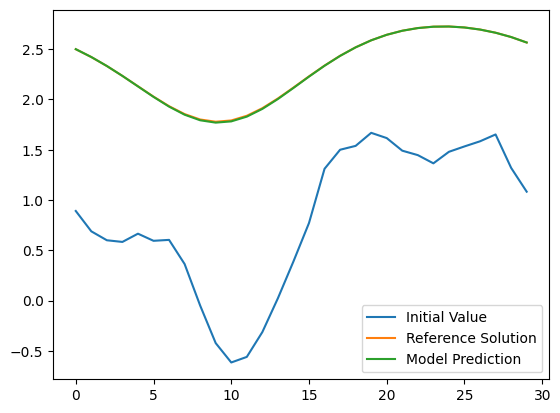

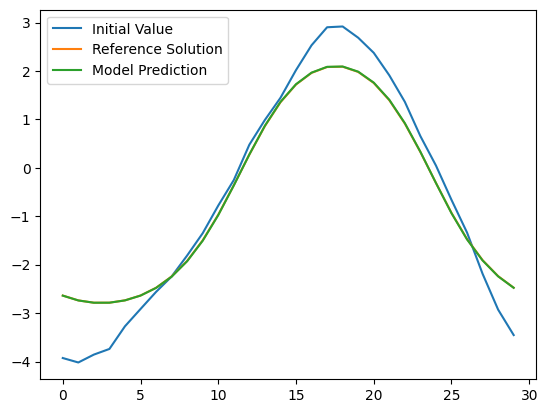

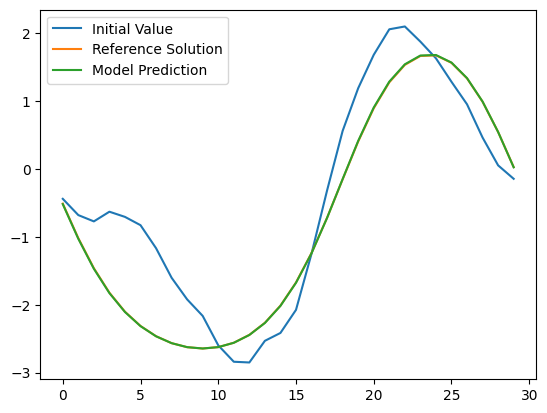

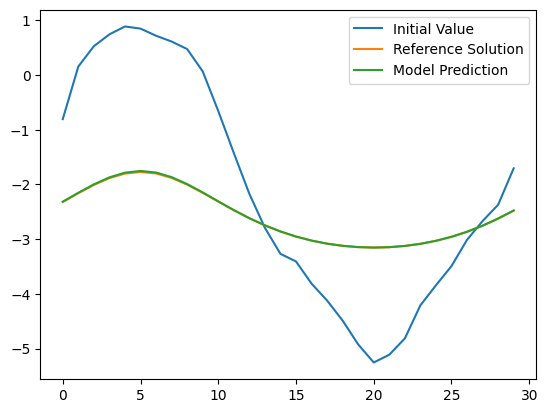

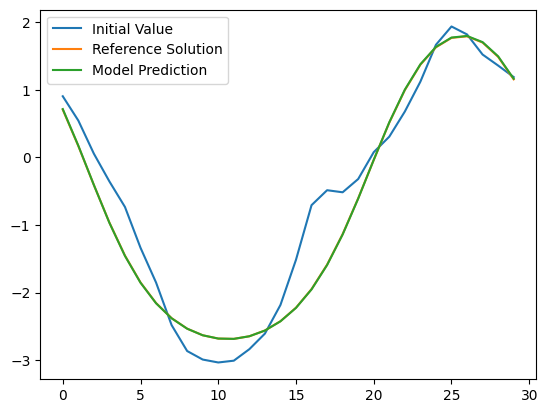

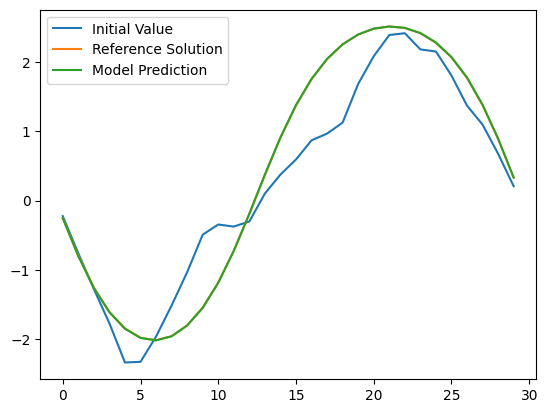

In [6]:
#Store the results
std_foldername = "Results_std"
if not os.path.exists(std_foldername):
        os.makedirs(std_foldername)
        

with open(std_foldername + '/Classical_LIRK_results.txt', 'w+') as f:
    for nr_tsteps in nr_classical_timesteps:
        
        second_order_lirk_model = Second_order_LIRK_model(T, 
                                                          pde,
                                                          nr_spacediscr,
                                                          nr_tsteps, 
                                                          [classical_p1s, classical_p2s],
                                                          training_samples_generator)
        
        error = evaluate(second_order_lirk_model, evaluate_samples = end_eval_samples)
        if nr_tsteps == nr_timesteps_classical_reference:
            classical_reference_error = error
        summary(second_order_lirk_model, write_file=f, plot_file_name = std_foldername + "/plot_LIRK_standard_" + str(nr_tsteps))
        csv_summary(second_order_lirk_model, std_foldername + "/LIRK_standard_" + str(nr_tsteps))


## ADANN Experiments

#### ADANN Experiment 1: Grid based approach

---------NEW RUN---------  i, j =  0 0
------ TRAINING BASE------


2023-01-25 18:21:53.763670: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x43307780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-25 18:21:53.763697: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-01-25 18:21:53.767410: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-25 18:21:53.891384: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


0  :  2.853e-05
10  :  1.203e-05
20  :  9.864e-06
30  :  8.213e-06
40  :  6.57e-06
50  :  5.614e-06
60  :  5.085e-06
70  :  4.629e-06
80  :  4.11e-06
90  :  3.602e-06
100  :  3.471e-06
110  :  3.346e-06
120  :  2.984e-06
130  :  2.748e-06
140  :  2.577e-06
150  :  2.457e-06
160  :  2.413e-06
170  :  2.092e-06
180  :  1.987e-06
190  :  1.868e-06
200  :  1.74e-06
210  :  1.682e-06
220  :  1.705e-06
230  :  1.574e-06
240  :  1.417e-06
250  :  1.379e-06
260  :  1.236e-06
270  :  1.185e-06
280  :  1.237e-06
290  :  1.139e-06
300  :  1.027e-06
310  :  1.053e-06
320  :  1.011e-06
330  :  1.058e-06
340  :  9.912e-07
350  :  1.029e-06
360  :  9.365e-07
370  :  8.434e-07
380  :  9.131e-07
390  :  8.246e-07
400  :  8.765e-07
410  :  8.813e-07
420  :  8.751e-07
430  :  8.276e-07
440  :  7.912e-07
450  :  7.689e-07
460  :  7.259e-07
470  :  7.333e-07
480  :  6.746e-07
490  :  7.868e-07
500  :  6.769e-07
510  :  6.597e-07
520  :  6.648e-07
530  :  6.824e-07
540  :  5.955e-07
550  :  6.271e-07
560  :

2023-01-25 18:25:43.751619: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 18:25:44.122722: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 18:25:44.493387: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.012
10  :  0.8127
20  :  0.7837
30  :  0.7815
40  :  0.7268
50  :  0.7082
60  :  0.6583
70  :  0.6346
80  :  0.4746
90  :  0.4575
100  :  0.3929
110  :  0.4127
120  :  0.3196
130  :  0.3257
140  :  0.3034
150  :  0.248
160  :  0.2973
170  :  0.2346
180  :  0.2314
190  :  0.2067
200  :  0.1767
210  :  0.1299
220  :  0.1244
230  :  0.11
240  :  0.1004
250  :  0.1764
260  :  0.08116
270  :  0.1159
280  :  0.09953
290  :  0.09079
300  :  0.09152
310  :  0.07205
320  :  0.07962
330  :  0.07639
340  :  0.08673
350  :  0.08414
360  :  0.07793
370  :  0.07548
380  :  0.08223
390  :  0.0589
400  :  0.135
410  :  0.07025
420  :  0.05804
430  :  0.07538
440  :  0.09604
450  :  0.1256
460  :  0.09634
470  :  0.05358
480  :  0.05222
490  :  0.05161
500  :  0.06752
510  :  0.06291
520  :  0.06648
530  :  0.04997
540  :  0.06745
550  :  0.05863
560  :  0.05663
570  :  0.07575
580  :  0.05248
590  :  0.04991
600  :  0.05954
610  :  0.05082
620  :  0.139
630  :  0.04744
640  :  0.04187
650  :  

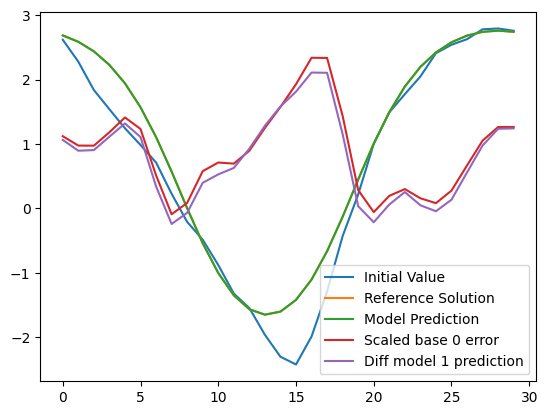

---------NEW RUN---------  i, j =  0 1
------ TRAINING BASE------
0  :  3.003e-05
10  :  1.164e-05
20  :  9.651e-06
30  :  7.671e-06
40  :  6.757e-06
50  :  5.928e-06
60  :  5.278e-06
70  :  4.92e-06
80  :  4.329e-06
90  :  4.166e-06
100  :  4.107e-06
110  :  3.601e-06
120  :  3.478e-06
130  :  3.641e-06
140  :  3.323e-06
150  :  3.049e-06
160  :  2.757e-06
170  :  2.748e-06
180  :  2.632e-06
190  :  2.42e-06
200  :  2.325e-06
210  :  2.252e-06
220  :  2.235e-06
230  :  2.174e-06
240  :  2.004e-06
250  :  1.935e-06
260  :  1.842e-06
270  :  1.654e-06
280  :  1.599e-06
290  :  1.534e-06
300  :  1.57e-06
310  :  1.377e-06
320  :  1.361e-06
330  :  1.295e-06
340  :  1.271e-06
350  :  1.242e-06
360  :  1.265e-06
370  :  1.192e-06
380  :  1.168e-06
390  :  1.082e-06
400  :  1.085e-06
410  :  1.055e-06
420  :  1.023e-06
430  :  1.015e-06
440  :  1.017e-06
450  :  9.92e-07
460  :  9.438e-07
470  :  9.458e-07
480  :  8.828e-07
490  :  9.158e-07
500  :  8.346e-07
510  :  8.456e-07
520  :  8.413

2023-01-25 18:31:12.325300: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 18:31:12.696789: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 18:31:13.067906: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.017
10  :  0.7721
20  :  0.719
30  :  0.6945
40  :  0.5691
50  :  0.5524
60  :  0.4522
70  :  0.4642
80  :  0.3803
90  :  0.3227
100  :  0.3278
110  :  0.3107
120  :  0.2468
130  :  0.2156
140  :  0.2281
150  :  0.2262
160  :  0.1675
170  :  0.2145
180  :  0.1562
190  :  0.1224
200  :  0.1254
210  :  0.122
220  :  0.1073
230  :  0.1025
240  :  0.09604
250  :  0.102
260  :  0.08199
270  :  0.07499
280  :  0.07563
290  :  0.0695
300  :  0.06914
310  :  0.07087
320  :  0.05929
330  :  0.07298
340  :  0.0567
350  :  0.08607
360  :  0.08111
370  :  0.05602
380  :  0.06075
390  :  0.06731
400  :  0.0681
410  :  0.05756
420  :  0.05605
430  :  0.06585
440  :  0.05585
450  :  0.0483
460  :  0.04664
470  :  0.04878
480  :  0.04437
490  :  0.03607
500  :  0.04374
510  :  0.043
520  :  0.04173
530  :  0.04189
540  :  0.04035
550  :  0.03959
560  :  0.03653
570  :  0.06131
580  :  0.03724
590  :  0.04954
600  :  0.03634
610  :  0.03957
620  :  0.03337
630  :  0.02859
640  :  0.03598
650  :

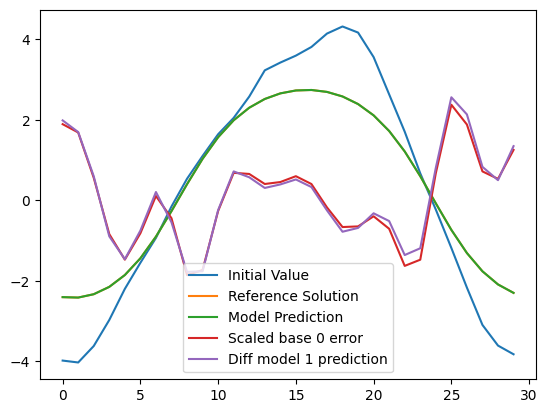

---------NEW RUN---------  i, j =  0 2
------ TRAINING BASE------
0  :  2.853e-05
10  :  1.157e-05
20  :  1.012e-05
30  :  7.746e-06
40  :  6.586e-06
50  :  5.761e-06
60  :  5.276e-06
70  :  5.016e-06
80  :  4.418e-06
90  :  4.153e-06
100  :  3.793e-06
110  :  3.769e-06
120  :  3.149e-06
130  :  3.34e-06
140  :  3.223e-06
150  :  3.157e-06
160  :  3.235e-06
170  :  2.912e-06
180  :  2.672e-06
190  :  2.627e-06
200  :  2.628e-06
210  :  2.681e-06
220  :  2.33e-06
230  :  2.096e-06
240  :  2.099e-06
250  :  1.995e-06
260  :  2.029e-06
270  :  1.958e-06
280  :  1.666e-06
290  :  1.732e-06
300  :  1.668e-06
310  :  1.598e-06
320  :  1.493e-06
330  :  1.452e-06
340  :  1.598e-06
350  :  1.384e-06
360  :  1.383e-06
370  :  1.453e-06
380  :  1.306e-06
390  :  1.23e-06
400  :  1.232e-06
410  :  1.169e-06
420  :  1.2e-06
430  :  1.162e-06
440  :  1.138e-06
450  :  1.096e-06
460  :  1.082e-06
470  :  1.01e-06
480  :  9.793e-07
490  :  9.273e-07
500  :  9.445e-07
510  :  8.934e-07
520  :  9.099e-

2023-01-25 18:37:01.166378: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 18:37:01.542084: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 18:37:01.916298: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.075
10  :  0.7438
20  :  0.6213
30  :  0.4888
40  :  0.3654
50  :  0.3105
60  :  0.2745
70  :  0.2003
80  :  0.1913
90  :  0.2025
100  :  0.1257
110  :  0.09495
120  :  0.1163
130  :  0.1379
140  :  0.09741
150  :  0.07838
160  :  0.09038
170  :  0.1099
180  :  0.1631
190  :  0.1345
200  :  0.1147
210  :  0.09513
220  :  0.08303
230  :  0.07415
240  :  0.07374
250  :  0.07431
260  :  0.0818
270  :  0.058
280  :  0.04623
290  :  0.07617
300  :  0.04065
310  :  0.03844
320  :  0.04371
330  :  0.03896
340  :  0.05248
350  :  0.03556
360  :  0.03159
370  :  0.04257
380  :  0.0309
390  :  0.03802
400  :  0.03893
410  :  0.03876
420  :  0.03432
430  :  0.05321
440  :  0.03249
450  :  0.1679
460  :  0.03722
470  :  0.0384
480  :  0.03608
490  :  0.03214
500  :  0.03629
510  :  0.03381
520  :  0.03778
530  :  0.02776
540  :  0.02781
550  :  0.02877
560  :  0.02695
570  :  0.03033
580  :  0.03261
590  :  0.02854
600  :  0.02321
610  :  0.02208
620  :  0.02668
630  :  0.03707
640  :  0.0

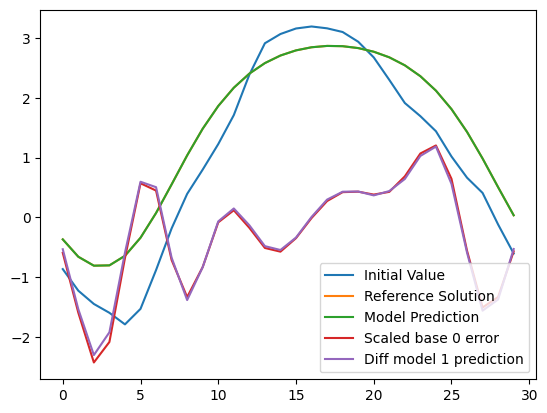

---------NEW RUN---------  i, j =  0 3
------ TRAINING BASE------
0  :  2.951e-05
10  :  1.145e-05
20  :  9.929e-06
30  :  7.792e-06
40  :  6.748e-06
50  :  5.954e-06
60  :  5.405e-06
70  :  4.375e-06
80  :  4.337e-06
90  :  4.105e-06
100  :  3.863e-06
110  :  3.483e-06
120  :  3.19e-06
130  :  3.222e-06
140  :  3.09e-06
150  :  2.971e-06
160  :  2.904e-06
170  :  2.825e-06
180  :  2.405e-06
190  :  2.616e-06
200  :  2.355e-06
210  :  2.335e-06
220  :  2.102e-06
230  :  2.214e-06
240  :  2.077e-06
250  :  1.97e-06
260  :  1.973e-06
270  :  1.896e-06
280  :  1.744e-06
290  :  1.806e-06
300  :  1.757e-06
310  :  1.601e-06
320  :  1.574e-06
330  :  1.459e-06
340  :  1.42e-06
350  :  1.415e-06
360  :  1.374e-06
370  :  1.415e-06
380  :  1.339e-06
390  :  1.249e-06
400  :  1.27e-06
410  :  1.098e-06
420  :  1.106e-06
430  :  1.134e-06
440  :  1.025e-06
450  :  1.023e-06
460  :  1.021e-06
470  :  9.967e-07
480  :  1.027e-06
490  :  9.864e-07
500  :  9.738e-07
510  :  9.759e-07
520  :  9.249e

2023-01-25 18:43:42.813863: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 18:43:43.188138: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 18:43:43.561939: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.039
10  :  0.7867
20  :  0.6837
30  :  0.5246
40  :  0.3717
50  :  0.2586
60  :  0.2552
70  :  0.1576
80  :  0.1189
90  :  0.0989
100  :  0.106
110  :  0.08291
120  :  0.155
130  :  0.06368
140  :  0.0676
150  :  0.07192
160  :  0.05403
170  :  0.04602
180  :  0.057
190  :  0.06182
200  :  0.04255
210  :  0.04825
220  :  0.03904
230  :  0.04139
240  :  0.04677
250  :  0.03788
260  :  0.09881
270  :  0.03127
280  :  0.03225
290  :  0.04257
300  :  0.04472
310  :  0.05678
320  :  0.04838
330  :  0.0297
340  :  0.02936
350  :  0.03212
360  :  0.02806
370  :  0.02516
380  :  0.02602
390  :  0.0311
400  :  0.04634
410  :  0.03733
420  :  0.0265
430  :  0.03028
440  :  0.03227
450  :  0.02867
460  :  0.05874
470  :  0.0403
480  :  0.03103
490  :  0.03735
500  :  0.02235
510  :  0.02262
520  :  0.02377
530  :  0.02566
540  :  0.02407
550  :  0.08902
560  :  0.02245
570  :  0.01963
580  :  0.03371
590  :  0.02082
600  :  0.02817
610  :  0.02142
620  :  0.01841
630  :  0.01677
640  :  0

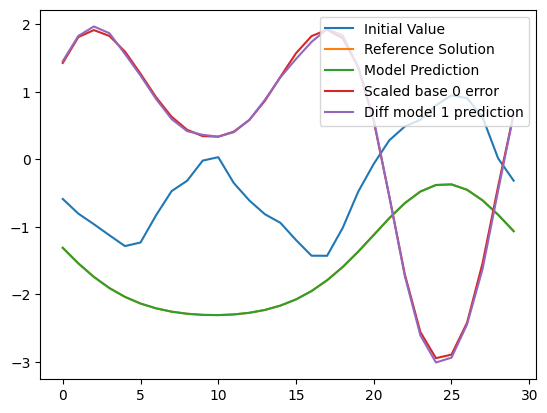

---------NEW RUN---------  i, j =  0 4
------ TRAINING BASE------
0  :  3.379e-05
10  :  1.229e-05
20  :  1.027e-05
30  :  8.242e-06
40  :  7.045e-06
50  :  6.207e-06
60  :  5.601e-06
70  :  4.971e-06
80  :  4.485e-06
90  :  4.5e-06
100  :  3.735e-06
110  :  3.512e-06
120  :  3.758e-06
130  :  3.331e-06
140  :  3.6e-06
150  :  3.128e-06
160  :  3.033e-06
170  :  2.698e-06
180  :  2.882e-06
190  :  2.67e-06
200  :  2.43e-06
210  :  2.499e-06
220  :  2.266e-06
230  :  2.347e-06
240  :  2.137e-06
250  :  2.197e-06
260  :  2.067e-06
270  :  2.039e-06
280  :  1.957e-06
290  :  1.797e-06
300  :  1.768e-06
310  :  1.735e-06
320  :  1.596e-06
330  :  1.603e-06
340  :  1.637e-06
350  :  1.599e-06
360  :  1.458e-06
370  :  1.397e-06
380  :  1.546e-06
390  :  1.347e-06
400  :  1.377e-06
410  :  1.235e-06
420  :  1.274e-06
430  :  1.174e-06
440  :  1.202e-06
450  :  1.143e-06
460  :  1.103e-06
470  :  1.126e-06
480  :  1.071e-06
490  :  1.012e-06
500  :  1.056e-06
510  :  1.071e-06
520  :  9.494e-

2023-01-25 18:49:46.621610: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 18:49:46.994777: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 18:49:47.368020: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  0.9614
10  :  0.7199
20  :  0.6219
30  :  0.5459
40  :  0.426
50  :  0.3972
60  :  0.3412
70  :  0.2908
80  :  0.3019
90  :  0.5056
100  :  0.1566
110  :  0.138
120  :  0.1538
130  :  0.1254
140  :  0.1347
150  :  0.07497
160  :  0.07088
170  :  0.07354
180  :  0.06392
190  :  0.06168
200  :  0.04745
210  :  0.07591
220  :  0.06328
230  :  0.05304
240  :  0.05405
250  :  0.06063
260  :  0.06032
270  :  0.05507
280  :  0.07399
290  :  0.04406
300  :  0.06464
310  :  0.03844
320  :  0.06021
330  :  0.03924
340  :  0.03484
350  :  0.03624
360  :  0.04102
370  :  0.04018
380  :  0.03311
390  :  0.2865
400  :  0.04618
410  :  0.03752
420  :  0.03231
430  :  0.03177
440  :  0.05639
450  :  0.03604
460  :  0.03693
470  :  0.04141
480  :  0.02735
490  :  0.0534
500  :  0.04962
510  :  0.03676
520  :  0.04116
530  :  0.03301
540  :  0.03431
550  :  0.02992
560  :  0.02985
570  :  0.04147
580  :  0.02733
590  :  0.02488
600  :  0.02399
610  :  0.02203
620  :  0.02664
630  :  0.03728
640  :

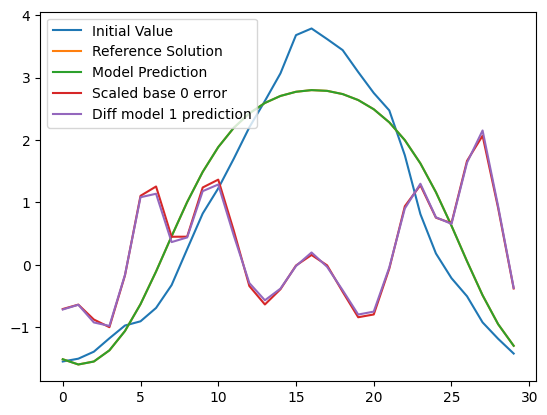

---------NEW RUN---------  i, j =  1 0
------ TRAINING BASE------
0  :  3.139e-05
10  :  1.282e-05
20  :  1.059e-05
30  :  8.433e-06
40  :  7.281e-06
50  :  6.087e-06
60  :  6.184e-06
70  :  5.176e-06
80  :  4.675e-06
90  :  4.242e-06
100  :  4.015e-06
110  :  3.702e-06
120  :  3.079e-06
130  :  3.099e-06
140  :  2.952e-06
150  :  2.839e-06
160  :  2.467e-06
170  :  2.486e-06
180  :  2.36e-06
190  :  2.175e-06
200  :  1.841e-06
210  :  1.937e-06
220  :  1.75e-06
230  :  1.741e-06
240  :  1.771e-06
250  :  1.591e-06
260  :  1.512e-06
270  :  1.358e-06
280  :  1.382e-06
290  :  1.307e-06
300  :  1.138e-06
310  :  1.208e-06
320  :  1.099e-06
330  :  1.075e-06
340  :  1.026e-06
350  :  1.033e-06
360  :  9.704e-07
370  :  9.986e-07
380  :  8.98e-07
390  :  8.772e-07
400  :  8.459e-07
410  :  8.06e-07
420  :  8.387e-07
430  :  7.457e-07
440  :  8.505e-07
450  :  7.106e-07
460  :  7.171e-07
470  :  6.53e-07
480  :  6.533e-07
490  :  7.451e-07
500  :  6.743e-07
510  :  6.727e-07
520  :  6.641e

2023-01-25 18:53:34.215466: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 18:53:34.599495: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 18:53:34.978518: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.025
10  :  0.9022
20  :  0.8029
30  :  0.6888
40  :  0.5817
50  :  0.5052
60  :  0.5038
70  :  0.3995
80  :  0.3398
90  :  0.3173
100  :  0.2969
110  :  0.2442
120  :  0.211
130  :  0.2135
140  :  0.2265
150  :  0.1529
160  :  0.1483
170  :  0.1352
180  :  0.2596
190  :  0.1303
200  :  0.1019
210  :  0.0958
220  :  0.1831
230  :  0.1541
240  :  0.172
250  :  0.1256
260  :  0.1205
270  :  0.1071
280  :  0.09068
290  :  0.06574
300  :  0.0766
310  :  0.0638
320  :  0.07933
330  :  0.05998
340  :  0.08054
350  :  0.09928
360  :  0.06909
370  :  0.06258
380  :  0.06024
390  :  0.05279
400  :  0.06186
410  :  0.05625
420  :  0.0575
430  :  0.06247
440  :  0.07528
450  :  0.06537
460  :  0.04545
470  :  0.06424
480  :  0.1196
490  :  0.06927
500  :  0.055
510  :  0.1234
520  :  0.04508
530  :  0.04906
540  :  0.04579
550  :  0.04156
560  :  0.04579
570  :  0.04728
580  :  0.04873
590  :  0.04252
600  :  0.04454
610  :  0.04985
620  :  0.0521
630  :  0.07009
640  :  0.04707
650  :  0.

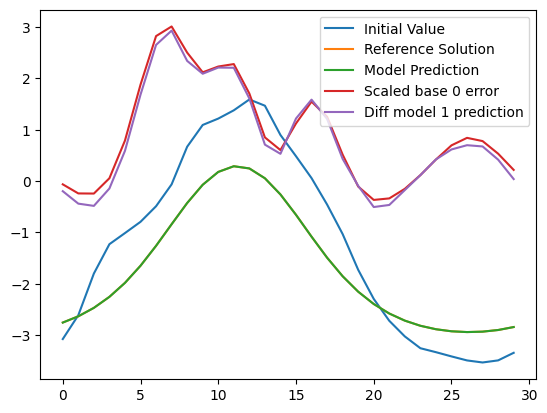

---------NEW RUN---------  i, j =  1 1
------ TRAINING BASE------
0  :  3.05e-05
10  :  1.301e-05
20  :  1.129e-05
30  :  8.791e-06
40  :  7.457e-06
50  :  6.845e-06
60  :  6.109e-06
70  :  4.904e-06
80  :  4.596e-06
90  :  4.804e-06
100  :  4.556e-06
110  :  4.284e-06
120  :  4.087e-06
130  :  3.642e-06
140  :  3.563e-06
150  :  3.614e-06
160  :  3.262e-06
170  :  3.14e-06
180  :  2.978e-06
190  :  2.756e-06
200  :  2.713e-06
210  :  2.739e-06
220  :  2.661e-06
230  :  2.444e-06
240  :  2.217e-06
250  :  2.009e-06
260  :  2.051e-06
270  :  1.966e-06
280  :  1.881e-06
290  :  1.836e-06
300  :  1.77e-06
310  :  1.731e-06
320  :  1.634e-06
330  :  1.562e-06
340  :  1.588e-06
350  :  1.537e-06
360  :  1.344e-06
370  :  1.301e-06
380  :  1.343e-06
390  :  1.205e-06
400  :  1.259e-06
410  :  1.187e-06
420  :  1.085e-06
430  :  1.12e-06
440  :  1.06e-06
450  :  1.084e-06
460  :  9.595e-07
470  :  9.921e-07
480  :  9.45e-07
490  :  9.169e-07
500  :  8.946e-07
510  :  9.239e-07
520  :  9.006e-

2023-01-25 18:59:25.038831: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 18:59:25.412933: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 18:59:25.786427: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  0.9782
10  :  0.9271
20  :  0.961
30  :  0.8848
40  :  0.6584
50  :  0.6106
60  :  0.4643
70  :  0.4198
80  :  0.337
90  :  0.2964
100  :  0.2923
110  :  0.2615
120  :  0.2223
130  :  0.1991
140  :  0.1851
150  :  0.1824
160  :  0.1713
170  :  0.155
180  :  0.1531
190  :  0.09833
200  :  0.1069
210  :  0.1015
220  :  0.0961
230  :  0.1256
240  :  0.08079
250  :  0.07716
260  :  0.08525
270  :  0.06227
280  :  0.06727
290  :  0.08479
300  :  0.06815
310  :  0.06479
320  :  0.06383
330  :  0.0603
340  :  0.07271
350  :  0.08103
360  :  0.08063
370  :  0.05598
380  :  0.05438
390  :  0.05109
400  :  0.05397
410  :  0.0525
420  :  0.04638
430  :  0.05043
440  :  0.04443
450  :  0.05841
460  :  0.07084
470  :  0.09858
480  :  0.106
490  :  0.126
500  :  0.1086
510  :  0.08348
520  :  0.07677
530  :  0.05013
540  :  0.04937
550  :  0.04458
560  :  0.0391
570  :  0.05159
580  :  0.05317
590  :  0.04751
600  :  0.04321
610  :  0.03091
620  :  0.03733
630  :  0.03587
640  :  0.03264
650  

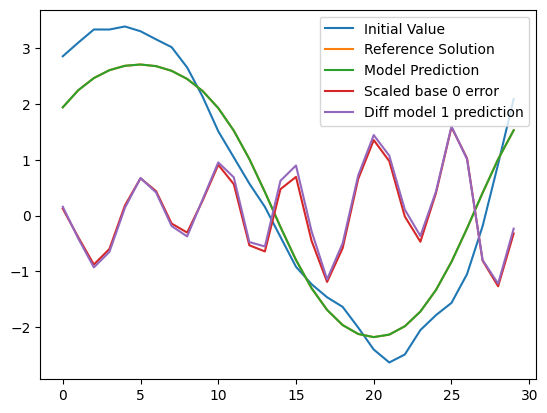

---------NEW RUN---------  i, j =  1 2
------ TRAINING BASE------
0  :  2.878e-05
10  :  1.218e-05
20  :  1.109e-05
30  :  8.374e-06
40  :  7.414e-06
50  :  6.638e-06
60  :  6.041e-06
70  :  5.469e-06
80  :  4.975e-06
90  :  4.834e-06
100  :  4.026e-06
110  :  3.904e-06
120  :  3.952e-06
130  :  3.723e-06
140  :  3.462e-06
150  :  3.573e-06
160  :  3.14e-06
170  :  3.112e-06
180  :  3.052e-06
190  :  2.906e-06
200  :  2.844e-06
210  :  2.448e-06
220  :  2.637e-06
230  :  2.498e-06
240  :  2.275e-06
250  :  2.325e-06
260  :  2.106e-06
270  :  2.24e-06
280  :  1.888e-06
290  :  1.86e-06
300  :  1.965e-06
310  :  1.867e-06
320  :  1.796e-06
330  :  1.68e-06
340  :  1.592e-06
350  :  1.557e-06
360  :  1.576e-06
370  :  1.407e-06
380  :  1.456e-06
390  :  1.435e-06
400  :  1.303e-06
410  :  1.397e-06
420  :  1.323e-06
430  :  1.266e-06
440  :  1.212e-06
450  :  1.182e-06
460  :  1.183e-06
470  :  1.187e-06
480  :  1.096e-06
490  :  1.071e-06
500  :  1.055e-06
510  :  9.982e-07
520  :  9.81e

2023-01-25 19:04:44.601081: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 19:04:44.972359: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 19:04:45.344394: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.056
10  :  0.9374
20  :  0.8187
30  :  0.6177
40  :  0.431
50  :  0.3378
60  :  0.3379
70  :  0.3223
80  :  0.3018
90  :  0.2558
100  :  0.2161
110  :  0.1668
120  :  0.155
130  :  0.1791
140  :  0.1523
150  :  0.1256
160  :  0.125
170  :  0.1225
180  :  0.1222
190  :  0.09579
200  :  0.0952
210  :  0.076
220  :  0.08106
230  :  0.0767
240  :  0.0731
250  :  0.08618
260  :  0.07402
270  :  0.09968
280  :  0.1309
290  :  0.08537
300  :  0.0726
310  :  0.06935
320  :  0.06446
330  :  0.07892
340  :  0.06007
350  :  0.0675
360  :  0.05949
370  :  0.05618
380  :  0.05351
390  :  0.0759
400  :  0.04736
410  :  0.05823
420  :  0.04977
430  :  0.04666
440  :  0.04654
450  :  0.03506
460  :  0.04189
470  :  0.04011
480  :  0.04079
490  :  0.04275
500  :  0.03344
510  :  0.03262
520  :  0.02984
530  :  0.03244
540  :  0.04781
550  :  0.04726
560  :  0.04937
570  :  0.03754
580  :  0.03913
590  :  0.029
600  :  0.03171
610  :  0.02947
620  :  0.02167
630  :  0.02669
640  :  0.02192
650  

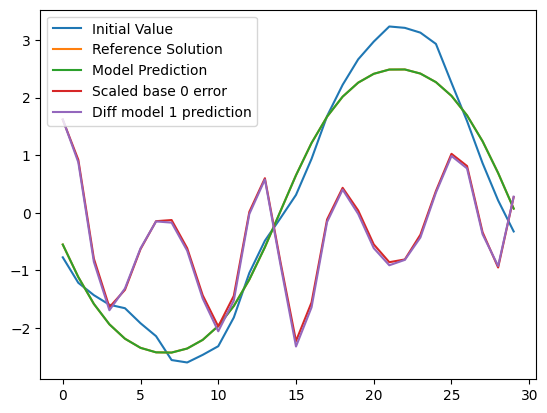

---------NEW RUN---------  i, j =  1 3
------ TRAINING BASE------
0  :  3.328e-05
10  :  1.217e-05
20  :  1.15e-05
30  :  8.305e-06
40  :  7.709e-06
50  :  7.211e-06
60  :  6.157e-06
70  :  5.614e-06
80  :  4.804e-06
90  :  4.714e-06
100  :  4.378e-06
110  :  4.158e-06
120  :  4.024e-06
130  :  3.952e-06
140  :  3.615e-06
150  :  3.489e-06
160  :  3.27e-06
170  :  3.47e-06
180  :  3.272e-06
190  :  3.01e-06
200  :  2.776e-06
210  :  2.812e-06
220  :  2.955e-06
230  :  2.633e-06
240  :  2.425e-06
250  :  2.505e-06
260  :  2.569e-06
270  :  2.028e-06
280  :  2.357e-06
290  :  2.12e-06
300  :  2.106e-06
310  :  1.878e-06
320  :  1.813e-06
330  :  1.845e-06
340  :  1.773e-06
350  :  1.694e-06
360  :  1.581e-06
370  :  1.636e-06
380  :  1.524e-06
390  :  1.462e-06
400  :  1.515e-06
410  :  1.38e-06
420  :  1.468e-06
430  :  1.357e-06
440  :  1.345e-06
450  :  1.283e-06
460  :  1.273e-06
470  :  1.164e-06
480  :  1.262e-06
490  :  1.11e-06
500  :  1.245e-06
510  :  1.065e-06
520  :  1.015e-0

2023-01-25 19:10:55.004858: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 19:10:55.376933: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 19:10:55.749228: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.033
10  :  0.8464
20  :  0.8013
30  :  0.7228
40  :  0.508
50  :  0.412
60  :  0.3217
70  :  0.2845
80  :  0.227
90  :  0.1734
100  :  0.1903
110  :  0.1443
120  :  0.1167
130  :  0.1068
140  :  0.09415
150  :  0.09363
160  :  0.08548
170  :  0.073
180  :  0.08135
190  :  0.1018
200  :  0.08792
210  :  0.09551
220  :  0.08543
230  :  0.08842
240  :  0.06582
250  :  0.07253
260  :  0.091
270  :  0.06581
280  :  0.07308
290  :  0.06937
300  :  0.05321
310  :  0.08529
320  :  0.05082
330  :  0.045
340  :  0.04522
350  :  0.04976
360  :  0.04271
370  :  0.04979
380  :  0.04694
390  :  0.0417
400  :  0.04317
410  :  0.1406
420  :  0.03982
430  :  0.04259
440  :  0.06364
450  :  0.04307
460  :  0.04703
470  :  0.04706
480  :  0.04335
490  :  0.0432
    New learning rate:  0.002
    New Batch size:  1024
500  :  0.05652
510  :  0.03031
520  :  0.02771
530  :  0.02349
540  :  0.02366
550  :  0.02692
560  :  0.02276
570  :  0.01869
580  :  0.02682
590  :  0.01841
600  :  0.02295
610  : 

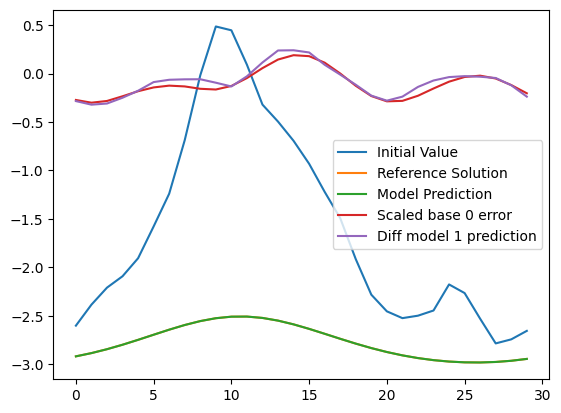

---------NEW RUN---------  i, j =  1 4
------ TRAINING BASE------
0  :  3.57e-05
10  :  1.332e-05
20  :  1.057e-05
30  :  9.376e-06
40  :  8.312e-06
50  :  7.046e-06
60  :  6.454e-06
70  :  5.464e-06
80  :  5.121e-06
90  :  4.971e-06
100  :  4.773e-06
110  :  4.581e-06
120  :  4.023e-06
130  :  3.901e-06
140  :  3.378e-06
150  :  3.539e-06
160  :  3.719e-06
170  :  3.52e-06
180  :  3.293e-06
190  :  2.953e-06
200  :  3.051e-06
210  :  3.013e-06
220  :  2.981e-06
230  :  2.647e-06
240  :  2.634e-06
250  :  2.605e-06
260  :  2.481e-06
270  :  2.344e-06
280  :  2.292e-06
290  :  2.222e-06
300  :  2.103e-06
310  :  2.042e-06
320  :  1.98e-06
330  :  1.91e-06
340  :  1.833e-06
350  :  1.734e-06
360  :  1.754e-06
370  :  1.661e-06
380  :  1.743e-06
390  :  1.665e-06
400  :  1.617e-06
410  :  1.519e-06
420  :  1.486e-06
430  :  1.472e-06
440  :  1.377e-06
450  :  1.372e-06
460  :  1.358e-06
470  :  1.301e-06
480  :  1.255e-06
490  :  1.206e-06
500  :  1.249e-06
510  :  1.277e-06
520  :  1.088

2023-01-25 19:16:09.255039: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 19:16:09.629017: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 19:16:10.001809: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.07
10  :  0.9648
20  :  0.8016
30  :  0.6939
40  :  0.5383
50  :  0.4222
60  :  0.353
70  :  0.2847
80  :  0.2583
90  :  0.2043
100  :  0.2235
110  :  0.2123
120  :  0.1935
130  :  0.1677
140  :  0.1526
150  :  0.1391
160  :  0.0948
170  :  0.08606
180  :  0.08622
190  :  0.06785
200  :  0.06703
210  :  0.07354
220  :  0.06029
230  :  0.05947
240  :  0.04915
250  :  0.04579
260  :  0.05305
270  :  0.04521
280  :  0.03727
290  :  0.04126
300  :  0.03515
310  :  0.0362
320  :  0.0528
330  :  0.05683
340  :  0.05559
350  :  0.0427
360  :  0.04153
370  :  0.0393
380  :  0.02896
390  :  0.03362
400  :  0.03066
410  :  0.02374
420  :  0.03296
430  :  0.02205
440  :  0.03445
450  :  0.02829
460  :  0.02332
470  :  0.03253
480  :  0.03492
490  :  0.03221
500  :  0.02227
510  :  0.02737
520  :  0.02753
530  :  0.03398
540  :  0.02256
550  :  0.01794
560  :  0.01907
570  :  0.01807
580  :  0.01651
590  :  0.02069
600  :  0.03246
610  :  0.02415
620  :  0.0273
630  :  0.02679
640  :  0.02

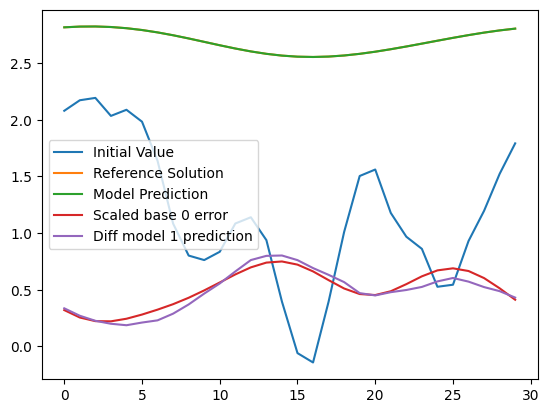

---------NEW RUN---------  i, j =  2 0
------ TRAINING BASE------
0  :  3.297e-05
10  :  1.592e-05
20  :  1.266e-05
30  :  1.114e-05
40  :  9.517e-06
50  :  8.87e-06
60  :  7.726e-06
70  :  6.557e-06
80  :  6.49e-06
90  :  5.918e-06
100  :  5.282e-06
110  :  4.86e-06
120  :  4.874e-06
130  :  4.631e-06
140  :  4.804e-06
150  :  4.24e-06
160  :  3.814e-06
170  :  3.921e-06
180  :  3.824e-06
190  :  3.401e-06
200  :  2.993e-06
210  :  3.022e-06
220  :  2.78e-06
230  :  2.694e-06
240  :  2.566e-06
250  :  2.605e-06
260  :  2.571e-06
270  :  2.225e-06
280  :  2.115e-06
290  :  2.154e-06
300  :  1.805e-06
310  :  1.892e-06
320  :  1.672e-06
330  :  1.569e-06
340  :  1.626e-06
350  :  1.615e-06
360  :  1.453e-06
370  :  1.31e-06
380  :  1.398e-06
390  :  1.37e-06
400  :  1.29e-06
410  :  1.317e-06
420  :  1.232e-06
430  :  1.205e-06
440  :  1.137e-06
450  :  1.163e-06
460  :  1.184e-06
470  :  1.13e-06
480  :  1.062e-06
490  :  1.013e-06
500  :  1.044e-06
510  :  1.002e-06
520  :  1.008e-06


4370  :  1.262e-07
4380  :  1.349e-07
4390  :  1.203e-07
4400  :  1.267e-07
4410  :  1.216e-07
4420  :  1.359e-07
    New learning rate:  2e-07
    New Batch size:  1024
4430  :  1.245e-07
4440  :  1.278e-07
4450  :  1.199e-07
4460  :  1.186e-07
4470  :  1.248e-07
4480  :  1.202e-07
4490  :  1.147e-07
4500  :  1.188e-07
4510  :  1.201e-07
4520  :  1.18e-07
4530  :  1.172e-07
4540  :  1.19e-07
4550  :  1.188e-07
4560  :  1.188e-07
4570  :  1.208e-07
4580  :  1.215e-07
4590  :  1.11e-07
4600  :  1.154e-07
    New learning rate:  4e-08
    New Batch size:  2048
4610  :  1.168e-07
4620  :  1.23e-07
4630  :  1.177e-07
4640  :  1.199e-07
4650  :  1.196e-07
4660  :  1.203e-07
4670  :  1.16e-07
4680  :  1.215e-07
4690  :  1.151e-07
4700  :  1.188e-07
4710  :  1.149e-07
4720  :  1.124e-07
4730  :  1.18e-07
Training ended due to inssuficient improvement
------ TRAINING DIFF 0 ------
Est. L2-error:  0.0003364047120115551


2023-01-25 19:23:58.010098: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 19:23:58.384457: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 19:23:58.758604: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.128
10  :  1.028
20  :  0.9178
30  :  0.8713
40  :  0.6856
50  :  0.614
60  :  0.5278
70  :  0.487
80  :  0.379
90  :  0.3307
100  :  0.2815
110  :  0.2428
120  :  0.2455
130  :  0.2952
140  :  0.2833
150  :  0.2296
160  :  0.1955
170  :  0.1591
180  :  0.142
190  :  0.1745
200  :  0.141
210  :  0.1454
220  :  0.1493
230  :  0.1231
240  :  0.1476
250  :  0.1728
260  :  0.1027
270  :  0.1116
280  :  0.1002
290  :  0.1122
300  :  0.1382
310  :  0.09715
320  :  0.1285
330  :  0.1139
340  :  0.1077
350  :  0.1161
360  :  0.08041
370  :  0.07711
380  :  0.08867
390  :  0.06836
400  :  0.05568
410  :  0.07407
420  :  0.0682
430  :  0.05343
440  :  0.1191
450  :  0.07583
460  :  0.05673
470  :  0.1042
480  :  0.06274
490  :  0.05977
500  :  0.05674
510  :  0.04537
520  :  0.05149
530  :  0.04114
540  :  0.06251
550  :  0.06309
560  :  0.06426
570  :  0.05533
580  :  0.05529
590  :  0.05095
600  :  0.04047
610  :  0.04999
620  :  0.06019
630  :  0.03874
640  :  0.04726
650  :  0.05093


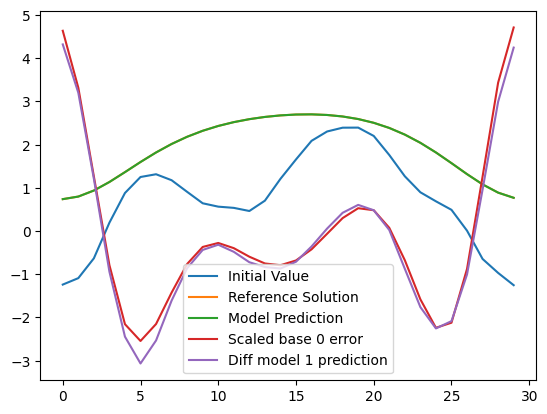

---------NEW RUN---------  i, j =  2 1
------ TRAINING BASE------
0  :  3.383e-05
10  :  1.517e-05
20  :  1.347e-05
30  :  1.055e-05
40  :  9.697e-06
50  :  9.132e-06
60  :  8.032e-06
70  :  7.374e-06
80  :  7.092e-06
90  :  7.344e-06
100  :  6.424e-06
110  :  6.311e-06
120  :  5.942e-06
130  :  5.47e-06
140  :  5.357e-06
150  :  5.31e-06
160  :  5.212e-06
170  :  5.155e-06
180  :  4.633e-06
190  :  4.398e-06
200  :  4.079e-06
210  :  4.418e-06
220  :  4.339e-06
230  :  3.796e-06
240  :  3.385e-06
250  :  3.388e-06
260  :  3.663e-06
270  :  3.247e-06
280  :  3.067e-06
290  :  3.164e-06
300  :  2.81e-06
310  :  2.66e-06
320  :  2.724e-06
330  :  2.444e-06
340  :  2.639e-06
350  :  2.53e-06
360  :  2.475e-06
370  :  2.393e-06
380  :  2.111e-06
390  :  2.194e-06
400  :  2.032e-06
410  :  1.979e-06
420  :  1.884e-06
430  :  1.935e-06
440  :  1.84e-06
450  :  1.732e-06
460  :  1.618e-06
470  :  1.798e-06
480  :  1.798e-06
490  :  1.501e-06
500  :  1.543e-06
510  :  1.516e-06
520  :  1.418e-

2023-01-25 19:28:20.315365: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 19:28:20.686916: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 19:28:21.061098: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.057
10  :  0.9167
20  :  0.8544
30  :  0.6938
40  :  0.4513
50  :  0.4347
60  :  0.2997
70  :  0.2942
80  :  0.227
90  :  0.2052
100  :  0.1968
110  :  0.1788
120  :  0.148
130  :  0.1216
140  :  0.1539
150  :  0.1344
160  :  0.1331
170  :  0.1117
180  :  0.1007
190  :  0.1015
200  :  0.07828
210  :  0.09052
220  :  0.05792
230  :  0.06455
240  :  0.05827
250  :  0.1004
260  :  0.08642
270  :  0.07646
280  :  0.06819
290  :  0.05999
300  :  0.08489
310  :  0.07682
320  :  0.06374
330  :  0.07626
340  :  0.06141
350  :  0.0624
360  :  0.0573
370  :  0.05293
380  :  0.2089
390  :  0.04631
400  :  0.04728
410  :  0.05214
420  :  0.03564
430  :  0.1443
440  :  0.05338
450  :  0.03994
460  :  0.03899
470  :  0.0505
480  :  0.04365
490  :  0.03925
500  :  0.02703
510  :  0.03133
520  :  0.06125
530  :  0.04203
540  :  0.04189
550  :  0.03523
560  :  0.02641
570  :  0.0289
580  :  0.04589
590  :  0.03668
600  :  0.031
610  :  0.02759
620  :  0.02904
630  :  0.0292
640  :  0.02925
650 

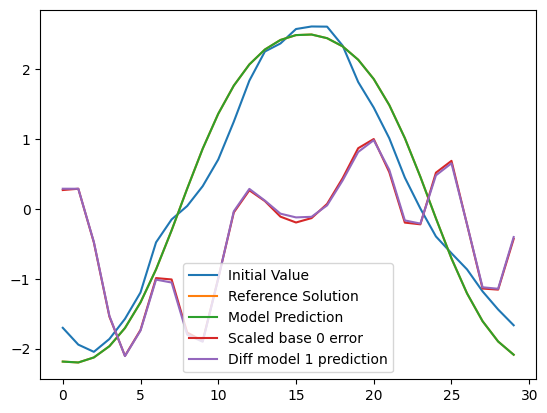

---------NEW RUN---------  i, j =  2 2
------ TRAINING BASE------
0  :  3.579e-05
10  :  1.493e-05
20  :  1.363e-05
30  :  1.046e-05
40  :  1.07e-05
50  :  9.516e-06
60  :  8.559e-06
70  :  7.853e-06
80  :  7.59e-06
90  :  6.841e-06
100  :  6.565e-06
110  :  6.174e-06
120  :  6.024e-06
130  :  5.495e-06
140  :  5.889e-06
150  :  5.384e-06
160  :  5.303e-06
170  :  5.26e-06
180  :  4.915e-06
190  :  4.964e-06
200  :  4.923e-06
210  :  4.451e-06
220  :  4.696e-06
230  :  4.141e-06
240  :  3.831e-06
250  :  3.917e-06
260  :  3.535e-06
270  :  3.467e-06
280  :  3.673e-06
290  :  3.485e-06
300  :  3.346e-06
310  :  3.206e-06
320  :  3.262e-06
330  :  2.86e-06
340  :  2.909e-06
350  :  2.856e-06
360  :  2.816e-06
370  :  2.59e-06
380  :  2.481e-06
390  :  2.495e-06
400  :  2.434e-06
410  :  2.511e-06
420  :  2.376e-06
430  :  2.202e-06
440  :  2.219e-06
450  :  2.212e-06
460  :  2.055e-06
470  :  2.083e-06
480  :  2.079e-06
490  :  1.906e-06
500  :  2.083e-06
510  :  1.849e-06
520  :  1.883e

2023-01-25 19:33:37.136701: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 19:33:37.508137: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 19:33:37.882176: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.029
10  :  0.8923
20  :  0.7411
30  :  0.5231
40  :  0.3611
50  :  0.2921
60  :  0.2009
70  :  0.1735
80  :  0.1966
90  :  0.1252
100  :  0.1323
110  :  0.1124
120  :  0.1426
130  :  0.1219
140  :  0.1636
150  :  0.1327
160  :  0.1225
170  :  0.09861
180  :  0.09568
190  :  0.1077
200  :  0.09039
210  :  0.06414
220  :  0.06217
230  :  0.05539
240  :  0.05723
250  :  0.04797
260  :  0.06155
270  :  0.05546
280  :  0.05788
290  :  0.06259
300  :  0.05555
310  :  0.06856
320  :  0.05304
330  :  0.0552
340  :  0.05814
350  :  0.06205
360  :  0.05132
370  :  0.04462
380  :  0.03607
390  :  0.04293
400  :  0.02963
410  :  0.0485
420  :  0.04643
430  :  0.04236
440  :  0.03526
450  :  0.03796
460  :  0.03601
470  :  0.035
480  :  0.04121
490  :  0.03023
500  :  0.03488
510  :  0.03421
520  :  0.03243
530  :  0.04056
540  :  0.04353
550  :  0.02764
560  :  0.03538
570  :  0.03772
580  :  0.03779
590  :  0.02901
600  :  0.05548
610  :  0.03662
620  :  0.03557
630  :  0.02451
640  :  0.

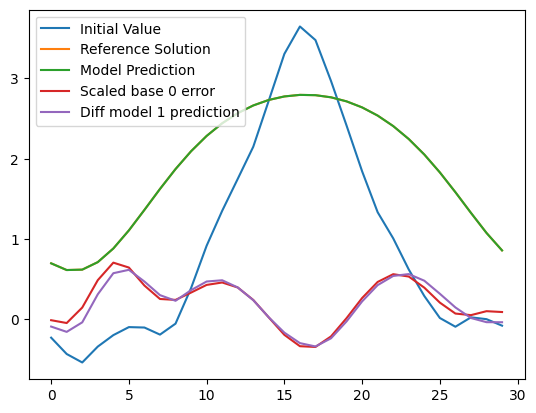

---------NEW RUN---------  i, j =  2 3
------ TRAINING BASE------
0  :  3.887e-05
10  :  1.586e-05
20  :  1.354e-05
30  :  1.046e-05
40  :  9.962e-06
50  :  8.925e-06
60  :  8.224e-06
70  :  8.066e-06
80  :  7.685e-06
90  :  7.43e-06
100  :  6.365e-06
110  :  6.582e-06
120  :  5.983e-06
130  :  5.623e-06
140  :  5.732e-06
150  :  5.129e-06
160  :  5.583e-06
170  :  5.206e-06
180  :  4.713e-06
190  :  4.814e-06
200  :  4.942e-06
210  :  4.508e-06
220  :  4.381e-06
230  :  4.311e-06
240  :  4.388e-06
250  :  4.125e-06
260  :  3.872e-06
270  :  3.955e-06
280  :  3.807e-06
290  :  3.527e-06
300  :  3.334e-06
310  :  3.31e-06
320  :  3.38e-06
330  :  3.096e-06
340  :  3.203e-06
350  :  3.101e-06
360  :  2.886e-06
370  :  2.836e-06
380  :  2.81e-06
390  :  2.86e-06
400  :  2.496e-06
410  :  2.608e-06
420  :  2.573e-06
430  :  2.397e-06
440  :  2.322e-06
450  :  2.052e-06
460  :  2.239e-06
470  :  2.143e-06
480  :  2.143e-06
490  :  2.124e-06
500  :  2.139e-06
510  :  1.964e-06
520  :  1.941e

2023-01-25 19:38:25.413238: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 19:38:25.787396: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 19:38:26.160547: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  0.979
10  :  1.012
20  :  0.9156
30  :  0.7262
40  :  0.5531
50  :  0.3738
60  :  0.302
70  :  0.2348
80  :  0.1799
90  :  0.147
100  :  0.1168
110  :  0.1023
120  :  0.08838
130  :  0.07248
140  :  0.06174
150  :  0.06031
160  :  0.09424
170  :  0.08977
180  :  0.06804
190  :  0.05676
200  :  0.06696
210  :  0.06595
220  :  0.05848
230  :  0.05419
240  :  0.04753
250  :  0.05031
260  :  0.05534
270  :  0.04093
280  :  0.04209
290  :  0.03808
300  :  0.05039
310  :  0.05051
320  :  0.05546
330  :  0.04798
340  :  0.04715
350  :  0.04913
360  :  0.04042
370  :  0.03994
380  :  0.04555
390  :  0.03299
400  :  0.03496
410  :  0.03801
420  :  0.03668
430  :  0.03648
440  :  0.03962
450  :  0.03968
460  :  0.03691
470  :  0.02851
480  :  0.03513
490  :  0.03883
500  :  0.04969
510  :  0.04119
520  :  0.03843
530  :  0.03946
540  :  0.03244
550  :  0.04611
560  :  0.04112
570  :  0.03754
    New learning rate:  0.002
    New Batch size:  1024
580  :  0.02652
590  :  0.02339
600  :  0.0

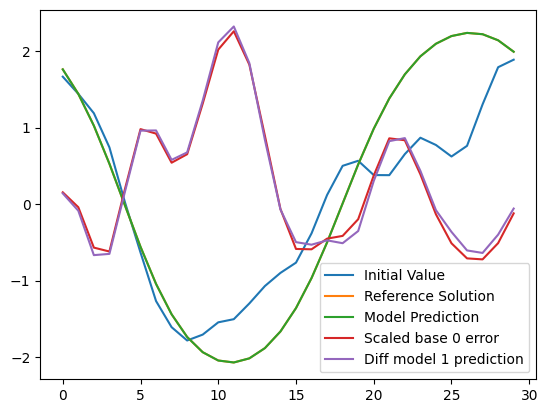

---------NEW RUN---------  i, j =  2 4
------ TRAINING BASE------
0  :  4.222e-05
10  :  1.661e-05
20  :  1.465e-05
30  :  1.117e-05
40  :  1.023e-05
50  :  9.306e-06
60  :  8.845e-06
70  :  8.195e-06
80  :  7.366e-06
90  :  6.729e-06
100  :  7.114e-06
110  :  6.214e-06
120  :  5.902e-06
130  :  5.99e-06
140  :  5.617e-06
150  :  5.494e-06
160  :  5.689e-06
170  :  4.943e-06
180  :  4.738e-06
190  :  4.881e-06
200  :  4.742e-06
210  :  4.784e-06
220  :  4.952e-06
230  :  4.453e-06
240  :  4.085e-06
250  :  4.27e-06
260  :  3.773e-06
270  :  3.876e-06
280  :  3.529e-06
290  :  3.747e-06
300  :  3.303e-06
310  :  3.679e-06
320  :  3.38e-06
330  :  3.375e-06
340  :  3.633e-06
350  :  3.152e-06
360  :  3.072e-06
370  :  2.992e-06
380  :  3.015e-06
390  :  2.982e-06
400  :  2.689e-06
410  :  2.526e-06
420  :  2.471e-06
430  :  2.621e-06
440  :  2.602e-06
450  :  2.259e-06
460  :  2.273e-06
470  :  2.487e-06
480  :  2.263e-06
490  :  2.315e-06
500  :  2.154e-06
510  :  2.242e-06
520  :  1.97

2023-01-25 19:43:32.274863: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 19:43:32.648475: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 19:43:33.021735: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  0.9401
10  :  0.9258
20  :  0.7806
30  :  0.5342
40  :  0.4174
50  :  0.3714
60  :  0.2506
70  :  0.237
80  :  0.1621
90  :  0.1621
100  :  0.1261
110  :  0.1104
120  :  0.09268
130  :  0.07663
140  :  0.1622
150  :  0.08594
160  :  0.08052
170  :  0.1133
180  :  0.1014
190  :  0.1048
200  :  0.08156
210  :  0.1155
220  :  0.09639
230  :  0.06291
240  :  0.06674
250  :  0.05592
260  :  0.053
270  :  0.04906
280  :  0.04799
290  :  0.03605
300  :  0.03219
310  :  0.04384
320  :  0.0402
330  :  0.03274
340  :  0.03635
350  :  0.03169
360  :  0.03148
370  :  0.02948
380  :  0.03448
390  :  0.03173
400  :  0.05606
410  :  0.1288
420  :  0.04606
430  :  0.0285
440  :  0.03325
450  :  0.02578
460  :  0.03029
470  :  0.0293
480  :  0.03282
490  :  0.03345
500  :  0.03619
510  :  0.03169
520  :  0.04425
530  :  0.02715
540  :  0.02369
550  :  0.02211
560  :  0.03129
570  :  0.02191
580  :  0.02314
590  :  0.02497
600  :  0.02858
610  :  0.02789
620  :  0.0213
630  :  0.02135
640  :  0.02

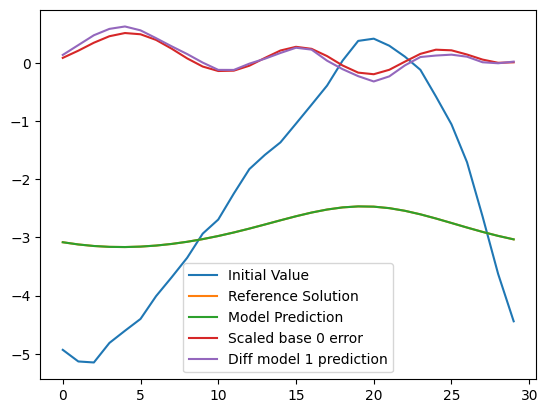

---------NEW RUN---------  i, j =  3 0
------ TRAINING BASE------
0  :  4.249e-05
10  :  2.113e-05
20  :  1.785e-05
30  :  1.514e-05
40  :  1.326e-05
50  :  1.42e-05
60  :  1.222e-05
70  :  1.163e-05
80  :  1.001e-05
90  :  1.065e-05
100  :  9.639e-06
110  :  8.81e-06
120  :  9.287e-06
130  :  8.197e-06
140  :  7.959e-06
150  :  7.444e-06
160  :  7.392e-06
170  :  6.409e-06
180  :  6.351e-06
190  :  6.438e-06
200  :  5.927e-06
210  :  5.56e-06
220  :  5.327e-06
230  :  4.993e-06
240  :  4.622e-06
250  :  4.643e-06
260  :  4.661e-06
270  :  4.531e-06
280  :  4.181e-06
290  :  4.077e-06
300  :  3.686e-06
310  :  3.565e-06
320  :  3.474e-06
330  :  3.129e-06
340  :  3.352e-06
350  :  2.994e-06
360  :  3.013e-06
370  :  2.924e-06
380  :  2.776e-06
390  :  2.572e-06
400  :  2.55e-06
410  :  2.707e-06
420  :  2.458e-06
430  :  2.343e-06
440  :  2.382e-06
450  :  2.299e-06
460  :  2.433e-06
470  :  2.227e-06
480  :  2.174e-06
490  :  2.137e-06
500  :  1.999e-06
510  :  2.303e-06
520  :  2.02e

2023-01-25 19:47:46.224194: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 19:47:46.598107: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 19:47:46.971238: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  0.9812
10  :  0.841
20  :  0.7414
30  :  0.5197
40  :  0.3805
50  :  0.2801
60  :  0.2791
70  :  0.2277
80  :  0.1843
90  :  0.2445
100  :  0.1449
110  :  0.1109
120  :  0.09855
130  :  0.1017
140  :  0.1024
150  :  0.08083
160  :  0.0792
170  :  0.07225
180  :  0.07089
190  :  0.05802
200  :  0.06806
210  :  0.0664
220  :  0.06518
230  :  0.06147
240  :  0.05255
250  :  0.0537
260  :  0.05413
270  :  0.1464
280  :  0.05482
290  :  0.06
300  :  0.0428
310  :  0.0402
320  :  0.03881
330  :  0.05765
340  :  0.03919
350  :  0.05354
360  :  0.06726
370  :  0.07693
380  :  0.04041
390  :  0.0456
400  :  0.04626
410  :  0.03252
420  :  0.04152
430  :  0.0519
440  :  0.03473
450  :  0.03337
460  :  0.03073
470  :  0.02948
480  :  0.03033
490  :  0.02344
500  :  0.04422
510  :  0.06289
520  :  0.03139
530  :  0.05717
540  :  0.04053
550  :  0.03424
560  :  0.04994
570  :  0.02655
580  :  0.03649
590  :  0.02753
600  :  0.02794
610  :  0.0222
620  :  0.02509
630  :  0.02918
640  :  0.0213

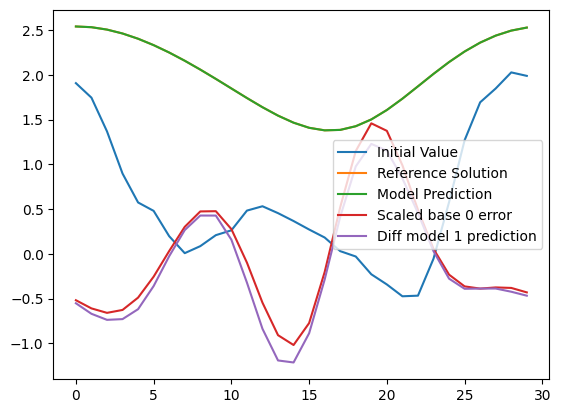

---------NEW RUN---------  i, j =  3 1
------ TRAINING BASE------
0  :  3.97e-05
10  :  2.085e-05
20  :  1.949e-05
30  :  1.59e-05
40  :  1.503e-05
50  :  1.435e-05
60  :  1.282e-05
70  :  1.198e-05
80  :  1.035e-05
90  :  1.111e-05
100  :  1.06e-05
110  :  9.505e-06
120  :  9.462e-06
130  :  9.405e-06
140  :  9.212e-06
150  :  9.032e-06
160  :  9.003e-06
170  :  9.003e-06
180  :  8.38e-06
190  :  7.838e-06
200  :  7.369e-06
210  :  7.291e-06
220  :  7.036e-06
230  :  7.472e-06
240  :  6.645e-06
250  :  5.982e-06
260  :  7.063e-06
270  :  5.634e-06
280  :  6.039e-06
290  :  5.798e-06
300  :  5.02e-06
310  :  5.34e-06
320  :  5.291e-06
330  :  5.167e-06
340  :  4.828e-06
350  :  4.897e-06
360  :  4.188e-06
370  :  4.203e-06
380  :  4.197e-06
390  :  4.202e-06
400  :  4.319e-06
410  :  3.891e-06
420  :  3.767e-06
430  :  3.72e-06
440  :  3.656e-06
450  :  3.425e-06
460  :  3.494e-06
470  :  3.556e-06
480  :  3.341e-06
490  :  3.322e-06
500  :  3.249e-06
510  :  3.153e-06
520  :  3.015e-0

2023-01-25 19:52:07.946506: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 19:52:08.319944: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 19:52:08.701447: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.054
10  :  1.381
20  :  0.8222
30  :  0.6228
40  :  0.4974
50  :  0.4064
60  :  0.2218
70  :  0.2759
80  :  0.1961
90  :  0.1378
100  :  0.1309
110  :  0.1189
120  :  0.1063
130  :  0.1545
140  :  0.1284
150  :  0.1133
160  :  0.1053
170  :  0.09583
180  :  0.09641
190  :  0.08712
200  :  0.07538
210  :  0.08666
220  :  0.0787
230  :  0.08437
240  :  0.1448
250  :  0.0594
260  :  0.0643
270  :  0.05493
280  :  0.05174
290  :  0.04324
300  :  0.03874
310  :  0.03353
320  :  0.04265
330  :  0.03973
340  :  0.0481
350  :  0.04217
360  :  0.03934
370  :  0.03845
380  :  0.05484
390  :  0.03372
400  :  0.03409
410  :  0.03232
420  :  0.03025
430  :  0.02368
440  :  0.02684
450  :  0.02692
460  :  0.02452
470  :  0.02932
480  :  0.03018
490  :  0.03595
500  :  0.03768
510  :  0.03475
520  :  0.06335
530  :  0.05803
540  :  0.05865
550  :  0.04543
560  :  0.04115
    New learning rate:  0.002
    New Batch size:  1024
570  :  0.03554
580  :  0.03039
590  :  0.02986
600  :  0.02686
610

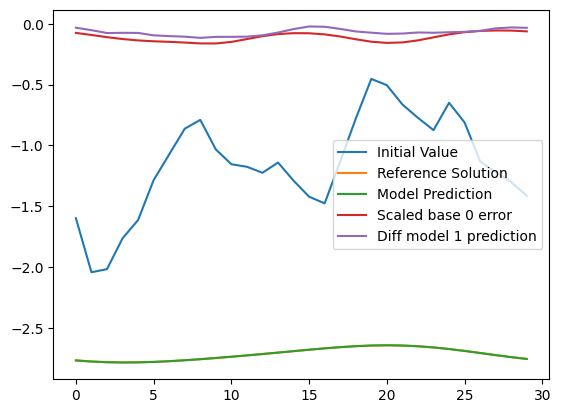

---------NEW RUN---------  i, j =  3 2
------ TRAINING BASE------
0  :  4.052e-05
10  :  2.13e-05
20  :  1.751e-05
30  :  1.57e-05
40  :  1.515e-05
50  :  1.446e-05
60  :  1.407e-05
70  :  1.265e-05
80  :  1.211e-05
90  :  1.172e-05
100  :  1.029e-05
110  :  1.081e-05
120  :  1.05e-05
130  :  9.934e-06
140  :  9.791e-06
150  :  9.834e-06
160  :  8.281e-06
170  :  8.819e-06
180  :  8.323e-06
190  :  8.364e-06
200  :  8.044e-06
210  :  8.46e-06
220  :  7.34e-06
230  :  7.599e-06
240  :  6.909e-06
250  :  6.992e-06
260  :  6.88e-06
270  :  6.743e-06
280  :  6.671e-06
290  :  6.143e-06
300  :  6.055e-06
310  :  5.475e-06
320  :  5.792e-06
330  :  5.841e-06
340  :  5.359e-06
350  :  5.273e-06
360  :  5.319e-06
370  :  4.882e-06
380  :  4.697e-06
390  :  4.902e-06
400  :  4.727e-06
410  :  4.425e-06
420  :  5.11e-06
430  :  5.146e-06
440  :  4.103e-06
450  :  4.462e-06
460  :  4.168e-06
470  :  4.131e-06
480  :  4.359e-06
490  :  3.888e-06
500  :  3.643e-06
510  :  3.387e-06
520  :  3.68e-06

2023-01-25 19:56:53.368302: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 19:56:53.749127: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 19:56:54.126581: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.001
10  :  0.895
20  :  0.6837
30  :  0.4853
40  :  0.4324
50  :  0.2941
60  :  0.2393
70  :  0.1921
80  :  0.1869
90  :  0.1487
100  :  0.1433
110  :  0.1297
120  :  0.1029
130  :  0.07805
140  :  0.08095
150  :  0.08188
160  :  0.09534
170  :  0.05935
180  :  0.07143
190  :  0.06295
200  :  0.07397
210  :  0.06834
220  :  0.06386
230  :  0.06122
240  :  0.06636
250  :  0.08116
260  :  0.06786
270  :  0.0576
280  :  0.05151
290  :  0.05831
300  :  0.04452
310  :  0.04984
320  :  0.04484
330  :  0.03844
340  :  0.04253
350  :  0.04276
360  :  0.04931
370  :  0.03335
380  :  0.03255
390  :  0.04395
400  :  0.04328
410  :  0.04208
420  :  0.0576
430  :  0.03777
440  :  0.02798
450  :  0.03462
460  :  0.03294
470  :  0.05205
480  :  0.03295
490  :  0.02568
500  :  0.4717
510  :  0.0315
520  :  0.02776
530  :  0.03674
540  :  0.03863
550  :  0.04986
560  :  0.04012
570  :  0.03492
580  :  0.08169
590  :  0.02937
600  :  0.02874
610  :  0.02085
620  :  0.03061
630  :  0.0601
640  : 

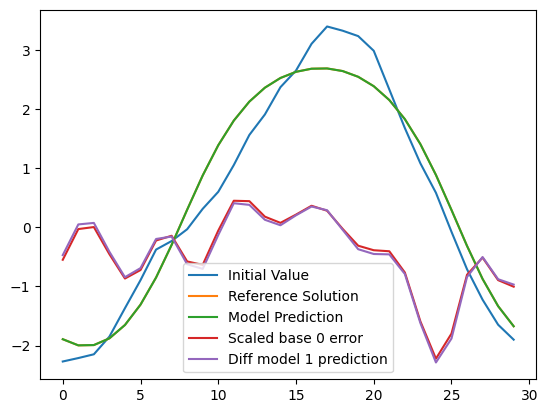

---------NEW RUN---------  i, j =  3 3
------ TRAINING BASE------
0  :  4.655e-05
10  :  2.093e-05
20  :  1.89e-05
30  :  1.772e-05
40  :  1.601e-05
50  :  1.506e-05
60  :  1.268e-05
70  :  1.181e-05
80  :  1.243e-05
90  :  1.168e-05
100  :  1.118e-05
110  :  1.041e-05
120  :  1.023e-05
130  :  9.66e-06
140  :  1.026e-05
150  :  9.362e-06
160  :  9.022e-06
170  :  9.178e-06
180  :  8.337e-06
190  :  8.562e-06
200  :  8.583e-06
210  :  8.202e-06
220  :  8.422e-06
230  :  7.736e-06
240  :  7.432e-06
250  :  7.493e-06
260  :  7.62e-06
270  :  7.376e-06
280  :  7.365e-06
290  :  6.741e-06
300  :  6.648e-06
310  :  6.519e-06
320  :  6.224e-06
330  :  6.687e-06
340  :  6.263e-06
350  :  5.822e-06
360  :  5.475e-06
370  :  5.196e-06
380  :  5.764e-06
390  :  6.191e-06
400  :  6.167e-06
410  :  5.516e-06
420  :  5.008e-06
430  :  5.693e-06
440  :  4.931e-06
450  :  4.28e-06
460  :  4.672e-06
470  :  4.529e-06
480  :  4.695e-06
490  :  4.555e-06
500  :  4.547e-06
510  :  4.115e-06
520  :  4.121

2023-01-25 20:01:21.467430: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 20:01:21.841306: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 20:01:22.215144: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  0.9781
10  :  0.9661
20  :  0.9208
30  :  0.6997
40  :  0.4458
50  :  1.388
60  :  0.227
70  :  0.154
80  :  0.1365
90  :  0.1078
100  :  0.1057
110  :  0.08825
120  :  0.07408
130  :  0.0664
140  :  0.06202
150  :  0.05663
160  :  0.04385
170  :  0.0835
180  :  0.04654
190  :  0.04833
200  :  0.04881
210  :  0.03523
220  :  0.3271
230  :  0.05761
240  :  0.04606
250  :  0.04279
260  :  0.03637
270  :  0.03559
280  :  0.2961
290  :  0.0354
300  :  0.02977
310  :  0.02683
320  :  0.02854
330  :  0.06654
340  :  0.03223
350  :  0.02793
360  :  0.03505
370  :  0.03217
380  :  0.03221
390  :  0.03273
400  :  0.02902
410  :  0.03254
420  :  0.03548
430  :  0.0227
440  :  0.02826
450  :  0.02685
460  :  0.02798
470  :  0.02671
480  :  0.02565
490  :  0.03717
500  :  0.02807
510  :  0.03289
520  :  0.02724
530  :  0.02854
540  :  0.02055
550  :  0.02893
560  :  0.01899
570  :  0.02818
580  :  0.02669
590  :  0.03342
600  :  0.02822
610  :  0.02607
620  :  0.09463
630  :  0.026
640  :  0

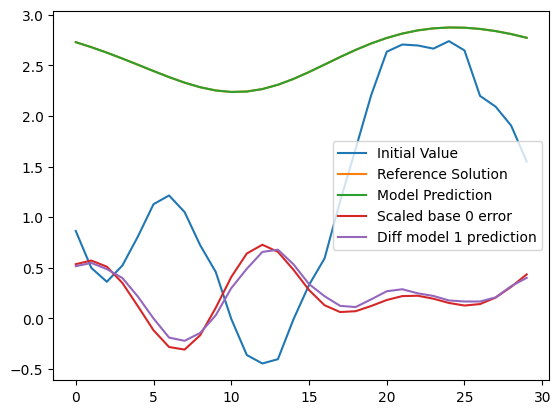

---------NEW RUN---------  i, j =  3 4
------ TRAINING BASE------
0  :  4.519e-05
10  :  2.199e-05
20  :  2.061e-05
30  :  1.775e-05
40  :  1.579e-05
50  :  1.437e-05
60  :  1.306e-05
70  :  1.301e-05
80  :  1.218e-05
90  :  1.209e-05
100  :  1.101e-05
110  :  1.115e-05
120  :  1.032e-05
130  :  1.034e-05
140  :  9.475e-06
150  :  9.948e-06
160  :  9.22e-06
170  :  9.291e-06
180  :  8.815e-06
190  :  8.934e-06
200  :  9.564e-06
210  :  8.453e-06
220  :  8.51e-06
230  :  7.523e-06
240  :  7.602e-06
250  :  7.844e-06
260  :  7.118e-06
270  :  7.434e-06
280  :  7.321e-06
290  :  7.257e-06
300  :  6.906e-06
310  :  6.667e-06
320  :  6.359e-06
330  :  6.248e-06
340  :  6.077e-06
350  :  6.347e-06
360  :  5.545e-06
370  :  5.854e-06
380  :  5.302e-06
390  :  5.194e-06
400  :  5.229e-06
410  :  5.384e-06
420  :  4.861e-06
430  :  5.012e-06
440  :  4.957e-06
450  :  4.721e-06
460  :  4.785e-06
470  :  4.536e-06
480  :  4.505e-06
490  :  4.409e-06
500  :  4.641e-06
510  :  4.037e-06
520  :  4.0

2023-01-25 20:06:18.088107: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 20:06:18.468396: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 20:06:18.852559: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  0.9724
10  :  1.02
20  :  0.7534
30  :  0.7513
40  :  0.4082
50  :  0.2846
60  :  0.2399
70  :  0.191
80  :  0.1365
90  :  0.1409
100  :  0.1113
110  :  0.1154
120  :  0.1103
130  :  0.3744
140  :  0.09823
150  :  0.07789
160  :  0.07447
170  :  0.06974
180  :  0.06355
190  :  0.06277
200  :  0.05095
210  :  0.05012
220  :  0.04469
230  :  0.04463
240  :  0.03555
250  :  0.04193
260  :  0.1587
270  :  0.0371
280  :  0.03764
290  :  0.03233
300  :  0.0353
310  :  0.03647
320  :  0.04492
330  :  0.06809
340  :  0.03382
350  :  0.06697
360  :  0.0353
370  :  0.02969
380  :  0.02708
390  :  0.02702
400  :  0.02201
410  :  0.025
420  :  0.03562
430  :  0.03242
440  :  0.03279
450  :  0.04813
460  :  0.04798
470  :  0.08768
480  :  0.0578
490  :  0.0653
500  :  0.04316
510  :  0.03497
520  :  0.03478
    New learning rate:  0.002
    New Batch size:  1024
530  :  0.02526
540  :  0.02029
550  :  0.02312
560  :  0.01626
570  :  0.01942
580  :  0.01675
590  :  0.01936
600  :  0.0185
610  

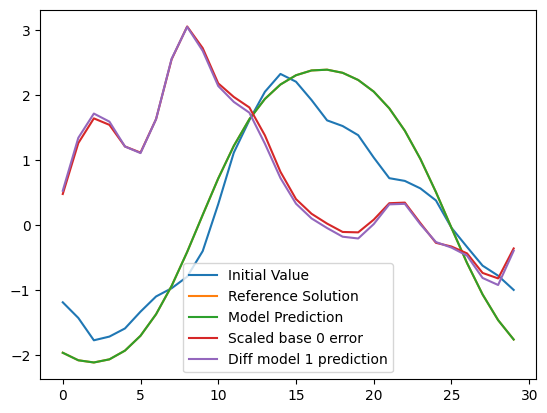

In [7]:
p1_values = np.linspace(grid_p1_low, grid_p1_high, grid_nr_p1_steps)
p2_values = np.linspace(grid_p2_low, grid_p2_high, grid_nr_p2_steps)
grid_p1s, grid_p2s = np.meshgrid(p1_values, p2_values)

#Prepare placeholders for errors
grid_start_errors = np.zeros_like(grid_p1s)
grid_end_errors_base = np.zeros_like(grid_p1s)
grid_end_errors = np.zeros_like(grid_p1s)

#Prepare placeholders for training times
base_traintimes = np.zeros_like(grid_p1s)
diff_traintimes = np.zeros_like(grid_p1s)


#Store the results
surface_foldername = "Results_surface"
surface_foldername_full = os.getcwd() + "/" + surface_foldername #for shutil.copyfile
if not os.path.exists(surface_foldername):
        os.makedirs(surface_foldername)

with open(surface_foldername + '/surface_simulation_results.txt', 'w+') as f:
    start_time = time.perf_counter()
    for i in range(grid_nr_p2_steps):
        for j in range(grid_nr_p1_steps):
            print("---------NEW RUN---------  i, j = ", i, j)
            print("--------------------------------------RUN (" + str(i) + "," + str(j) + ") : [" + str(grid_p1s[i,j]) + "," + str(grid_p2s[i,j]) + "]--------------------------------------", file = f)

            difference_learning_model = Difference_learning_model(T, 
                                                                  pde,
                                                                  nr_spacediscr,
                                                                  base = Second_order_LIRK_model, 
                                                                  nr_timesteps_base = nr_timesteps, 
                                                                  params_base = [[grid_p1s[i,j]], [grid_p2s[i,j]]], 
                                                                  diff_classes = [diff_model_class], 
                                                                  diff_params = [diff_model_params], 
                                                                  training_samples_generator = training_samples_generator,
                                                                  learning_rate = base_initial_lr)

            grid_start_errors[i,j] = evaluate(difference_learning_model.base_model, evaluate_samples = end_eval_samples)
            csv_summary(difference_learning_model.base_model, surface_foldername + "/Z_start_error_" + str(i) + str(j))
                  
            base_traintimes[i,j], diff_traintimes[i,j] = \
                            multi_difference_model_training(difference_learning_model, 
                                initial_learning_rates = [base_initial_lr, diff_initial_lr], 
                                initial_batch_sizes = [base_initial_batchsize, diff_initial_batchsize], 
                                tolerances = [base_tolerance, diff_tolerance], 
                                max_trainsteps = [base_max_trainsteps, diff_max_trainsteps], 
                                evaluate_steps = eval_steps, 
                                estimate_samples = est_samples,
                                evaluate_samples = eval_samples)
            
            grid_end_errors_base[i,j] = evaluate(difference_learning_model.base_model, evaluate_samples = end_eval_samples)
            csv_summary(difference_learning_model.base_model, surface_foldername + "/Z_end_error_base_" + str(i) + str(j))

            grid_end_errors[i,j] = evaluate(difference_learning_model, evaluate_samples = end_eval_samples)
            csv_summary(difference_learning_model, surface_foldername + "/Z_end_error_" + str(i) + str(j))
                  
            summary(difference_learning_model, multidiff_model = True, write_file = f, plot_file_name = surface_foldername + "/Z_plot_" + str(i) + str(j))
            print("\n\n", file = f)
    
    
    
    best_start = np.unravel_index(grid_start_errors.argmin(), grid_start_errors.shape)
    best_trained_base = np.unravel_index(grid_end_errors_base.argmin(), grid_end_errors_base.shape)
    best_full_adann = np.unravel_index(grid_end_errors.argmin(), grid_end_errors.shape) 
    
    total_time = time.perf_counter() - start_time 
    
    #Copy best error files
    shutil.copyfile(surface_foldername_full + "/Z_start_error_" + str(best_start[0]) + str(best_start[1]) + ".csv", surface_foldername_full + "/grid_best_start_error_" + str(best_start[0]) + str(best_start[1]) + ".csv")
    shutil.copyfile(surface_foldername_full + "/Z_end_error_base_" + str(best_trained_base[0]) + str(best_trained_base[1]) + ".csv", surface_foldername_full + "/grid_best_end_error_base_" + str(best_trained_base[0]) + str(best_trained_base[1]) + ".csv")
    shutil.copyfile(surface_foldername_full + "/Z_end_error_" + str(best_full_adann[0]) + str(best_full_adann[1]) + ".csv", surface_foldername_full + "/grid_best_end_error_" + str(best_full_adann[0]) + str(best_full_adann[1]) + ".csv")

    
    #Print some summary values
    
    print("\n\n\n--------------------------------------", file = f)
    
    print("Best errors:", file = f)
    print("    Best start: ", grid_start_errors[best_start], best_start, file = f)
    print("    Best trained base: ", grid_end_errors_base[best_trained_base], best_trained_base, file = f)
    print("    Best full ADANN: ", grid_end_errors[best_full_adann], best_full_adann, file = f)
    
    
    print("\nTrain times:", file = f)
    print("    Total time : ", total_time, file = f)
    print("    Total train time: ", np.sum(base_traintimes) + np.sum(diff_traintimes), file = f)
    print("    Total base train time: ", np.sum(base_traintimes), file = f)
    print("    Total diff train time: ", np.sum(diff_traintimes), file = f)
    print("\n    Average train time: ", np.mean(base_traintimes) + np.mean(diff_traintimes), file = f)
    print("    Average base train time: ", np.mean(base_traintimes), file = f)
    print("    Average diff train time: ", np.mean(diff_traintimes), file = f)
    

#Save error data
with open(surface_foldername + "/Y_grid_start_errors.txt", 'w+') as f:
    print(grid_start_errors, file = f)
with open(surface_foldername + "/Y_grid_end_errors_base.txt", 'w+') as f:
    print(grid_end_errors_base, file = f)
with open(surface_foldername + "/Y_end_errors.txt", 'w+') as f:
    print(grid_end_errors, file = f)
with open(surface_foldername + "/Y_grid_p1s.txt", 'w+') as f:
    print(grid_p1s, file = f)
with open(surface_foldername + "/Y_grid_p2s.txt", 'w+') as f:
    print(grid_p2s, file = f)

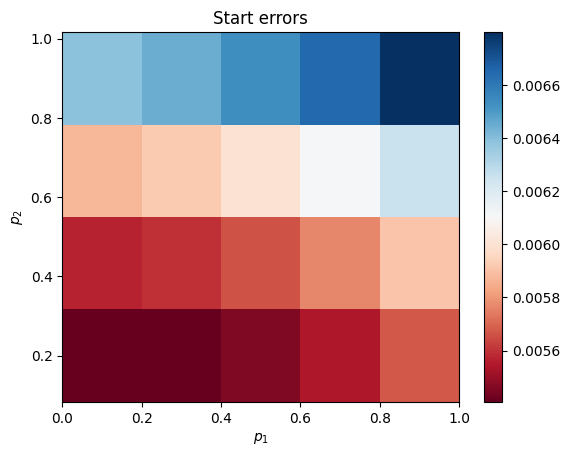

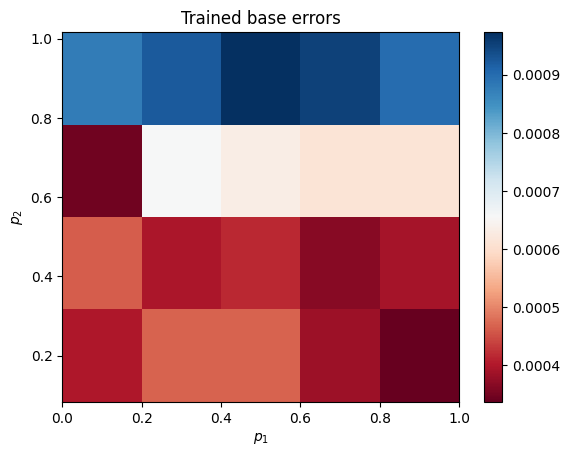

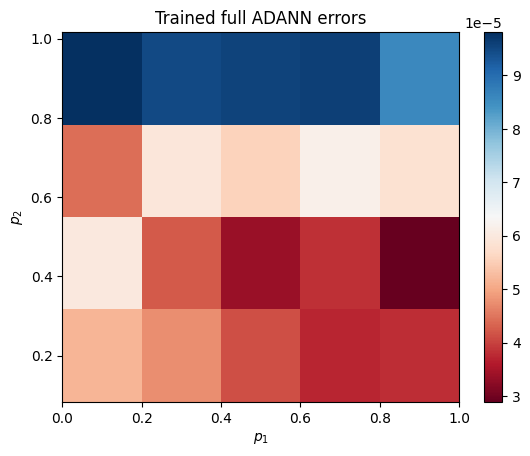

In [8]:
# start_errors = np.loadtxt("Y_start_errors.txt")
# end_errors_base = np.loadtxt("Y_end_errors_base.txt")
# end_errors = np.loadtxt("Y_end_errors.txt")

#Create heat maps to show the errors
start_errors_masked = np.ma.masked_invalid(grid_start_errors)
err_min, err_max = start_errors_masked[:].min(), start_errors_masked[:].max()

fig, ax = plt.subplots()

c = ax.pcolormesh(grid_p1s[:], grid_p2s[:], start_errors_masked[:], cmap='RdBu', vmin=err_min, vmax=err_max)
ax.set_title('Start errors')
ax.set_xlabel(r'$p_1$')
ax.set_ylabel(r'$p_2$')
fig.colorbar(c, ax=ax)
fig.savefig(surface_foldername + "/grid_start_errors.pdf")
plt.show()
##############################


end_errors_base_masked = np.ma.masked_invalid(grid_end_errors_base)
err_min, err_max = end_errors_base_masked[:].min(), end_errors_base_masked[:].max()

fig, ax = plt.subplots()

c = ax.pcolormesh(grid_p1s[:], grid_p2s[:], end_errors_base_masked[:], cmap='RdBu', vmin=err_min, vmax=err_max)
ax.set_title('Trained base errors')
ax.set_xlabel(r'$p_1$')
ax.set_ylabel(r'$p_2$')
fig.colorbar(c, ax=ax)
fig.savefig(surface_foldername + "/grid_end_errors_base.pdf")
plt.show()
##############################


end_errors_masked = np.ma.masked_invalid(grid_end_errors)
err_min, err_max = end_errors_masked[:].min(), end_errors_masked[:].max()

fig, ax = plt.subplots()

c = ax.pcolormesh(grid_p1s[:], grid_p2s[:], end_errors_masked[:], cmap='RdBu', vmin=err_min, vmax=err_max)
ax.set_title('Trained full ADANN errors')
ax.set_xlabel(r'$p_1$')
ax.set_ylabel(r'$p_2$')
fig.colorbar(c, ax=ax)
fig.savefig(surface_foldername + "/grid_end_errors.pdf")
plt.show()

#### ADANN Experiment 2: Optimization based approach

--------------------------------------RUN 0 --------------------------------------
Generated opt_params  0
0  :  3.816e-05
10  :  1.687e-05
20  :  1.468e-05
30  :  1.259e-05
40  :  1.051e-05
50  :  9.566e-06
60  :  9.009e-06
70  :  8.149e-06
80  :  7.592e-06
90  :  7.233e-06
100  :  6.847e-06
110  :  6.398e-06
120  :  6.512e-06
130  :  6.534e-06
140  :  6.105e-06
150  :  5.915e-06
160  :  5.689e-06
170  :  5.418e-06
180  :  5.167e-06
190  :  5.122e-06
200  :  4.802e-06
210  :  4.806e-06
220  :  4.715e-06
230  :  4.744e-06
240  :  4.263e-06
250  :  4.065e-06
260  :  3.975e-06
270  :  3.848e-06
280  :  3.878e-06
290  :  3.464e-06
300  :  3.4e-06
310  :  3.391e-06
320  :  3.67e-06
330  :  3.344e-06
340  :  3.302e-06
350  :  3.224e-06
360  :  3.081e-06
370  :  2.982e-06
380  :  2.717e-06
390  :  2.881e-06
400  :  2.586e-06
410  :  2.661e-06
420  :  2.528e-06
430  :  2.622e-06
440  :  2.366e-06
450  :  2.257e-06
460  :  2.373e-06
470  :  2.289e-06
480  :  2.256e-06
490  :  2.041e-06
500  : 

2023-01-25 20:11:29.212524: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 20:11:29.623571: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 20:11:30.032253: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  0.9422
10  :  0.9533
20  :  0.8369
30  :  0.6714
40  :  0.5454
50  :  0.4118
60  :  0.2999
70  :  0.5122
80  :  0.2365
90  :  0.229
100  :  0.1602
110  :  0.1606
120  :  0.1453
130  :  0.1317
140  :  0.1413
150  :  0.1045
160  :  0.09115
170  :  0.09413
180  :  0.1068
190  :  0.0822
200  :  0.09284
210  :  0.0708
220  :  0.05508
230  :  0.1255
240  :  0.06632
250  :  0.05951
260  :  0.04955
270  :  0.05496
280  :  0.07533
290  :  0.06642
300  :  0.0653
310  :  0.05699
320  :  0.05973
330  :  0.06155
340  :  0.06185
350  :  0.05082
360  :  0.04714
370  :  0.03947
380  :  0.03968
390  :  0.04032
400  :  0.04878
410  :  0.04027
420  :  0.0457
430  :  0.05134
440  :  0.04359
450  :  0.04207
460  :  0.03678
470  :  0.04401
480  :  0.08086
490  :  0.09293
500  :  0.07419
510  :  0.06871
520  :  0.05556
530  :  0.03925
540  :  0.03491
550  :  0.03216
560  :  0.0409
570  :  0.03263
580  :  0.03712
590  :  0.04321
600  :  0.04086
610  :  0.04351
620  :  0.09973
630  :  0.04238
640  :  0.0

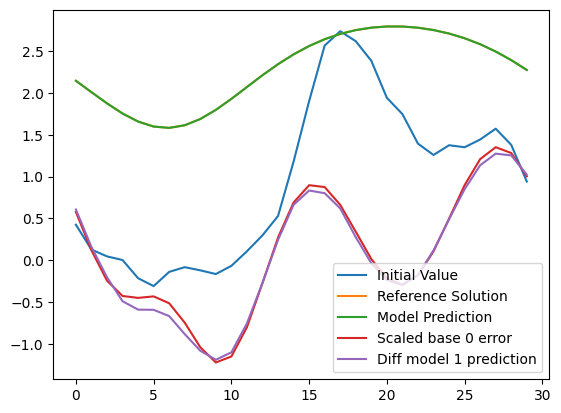

--------------------------------------RUN 1 --------------------------------------
Generated opt_params  1
0  :  3.366e-05
10  :  1.387e-05
20  :  1.229e-05
30  :  9.336e-06
40  :  8.447e-06
50  :  8.304e-06
60  :  7.39e-06
70  :  6.562e-06
80  :  6.681e-06
90  :  6.216e-06
100  :  5.097e-06
110  :  4.964e-06
120  :  4.925e-06
130  :  4.876e-06
140  :  4.661e-06
150  :  4.618e-06
160  :  4.313e-06
170  :  4.154e-06
180  :  4.106e-06
190  :  3.884e-06
200  :  3.582e-06
210  :  3.805e-06
220  :  3.318e-06
230  :  3.433e-06
240  :  3.245e-06
250  :  3.203e-06
260  :  2.983e-06
270  :  2.779e-06
280  :  2.911e-06
290  :  2.668e-06
300  :  2.386e-06
310  :  2.352e-06
320  :  2.425e-06
330  :  2.449e-06
340  :  2.366e-06
350  :  2.384e-06
360  :  2.281e-06
370  :  2.145e-06
380  :  2.458e-06
390  :  2.003e-06
400  :  1.868e-06
410  :  1.792e-06
420  :  1.836e-06
430  :  1.702e-06
440  :  1.738e-06
450  :  1.741e-06
460  :  1.583e-06
470  :  1.578e-06
480  :  1.519e-06
490  :  1.448e-06
500  

2023-01-25 20:17:31.045853: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 20:17:31.420830: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 20:17:31.795136: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.027
10  :  0.8912
20  :  0.8159
30  :  0.5927
40  :  0.4435
50  :  0.3622
60  :  0.3118
70  :  0.282
80  :  0.2457
90  :  0.2152
100  :  0.1755
110  :  0.1378
120  :  0.1146
130  :  0.1074
140  :  0.0914
150  :  0.07364
160  :  0.07419
170  :  0.06567
180  :  0.06159
190  :  0.06205
200  :  0.09779
210  :  0.05816
220  :  0.05393
230  :  0.05248
240  :  0.05597
250  :  0.04228
260  :  0.0437
270  :  0.06813
280  :  0.04116
290  :  0.03826
300  :  0.04049
310  :  0.03777
320  :  0.04883
330  :  0.04515
340  :  0.0374
350  :  0.06218
360  :  0.0563
370  :  0.04292
380  :  0.03715
390  :  0.02743
400  :  0.03515
410  :  0.03164
420  :  0.02876
430  :  0.02975
440  :  0.02585
450  :  0.02966
460  :  0.03205
470  :  0.02612
480  :  0.03392
490  :  0.02967
500  :  0.03472
510  :  0.02444
520  :  0.03141
530  :  0.03572
540  :  0.03116
550  :  0.0258
560  :  0.0274
    New learning rate:  0.002
    New Batch size:  1024
570  :  0.02063
580  :  0.01649
590  :  0.01855
600  :  0.02102
6

--------------------------------------RUN 2 --------------------------------------
Generated opt_params  2
0  :  3.375e-05
10  :  1.472e-05
20  :  1.283e-05
30  :  9.994e-06
40  :  9.409e-06
50  :  8.208e-06
60  :  7.922e-06
70  :  7.188e-06
80  :  7.018e-06
90  :  6.319e-06
100  :  6.093e-06
110  :  6.147e-06
120  :  6.13e-06
130  :  5.455e-06
140  :  5.438e-06
150  :  4.917e-06
160  :  4.983e-06
170  :  5.038e-06
180  :  4.729e-06
190  :  4.459e-06
200  :  4.59e-06
210  :  4.265e-06
220  :  4.121e-06
230  :  3.966e-06
240  :  3.718e-06
250  :  3.605e-06
260  :  3.784e-06
270  :  3.392e-06
280  :  3.051e-06
290  :  3.178e-06
300  :  3.13e-06
310  :  3.152e-06
320  :  2.889e-06
330  :  2.835e-06
340  :  2.69e-06
350  :  2.699e-06
360  :  2.468e-06
370  :  2.5e-06
380  :  2.324e-06
390  :  2.286e-06
400  :  2.212e-06
410  :  2.694e-06
420  :  1.975e-06
430  :  2.11e-06
440  :  1.912e-06
450  :  2.013e-06
460  :  1.706e-06
470  :  1.822e-06
480  :  1.709e-06
490  :  1.695e-06
500  :  1.6

2023-01-25 20:22:49.712069: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 20:22:50.112117: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 20:22:50.508432: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.04
10  :  0.9061
20  :  0.862
30  :  0.7293
40  :  0.5034
50  :  0.351
60  :  0.321
70  :  0.2711
80  :  0.2184
90  :  0.2203
100  :  0.1923
110  :  0.1784
120  :  0.148
130  :  0.1262
140  :  0.1067
150  :  0.126
160  :  0.1188
170  :  0.1058
180  :  0.0839
190  :  0.06771
200  :  0.06822
210  :  0.06562
220  :  0.0554
230  :  0.06034
240  :  0.06488
250  :  0.0665
260  :  0.05655
270  :  0.06601
280  :  0.05379
290  :  0.05126
300  :  0.04133
310  :  0.04353
320  :  0.04642
330  :  0.04399
340  :  0.0517
350  :  0.0566
360  :  0.04912
370  :  0.04642
380  :  0.05605
390  :  0.03561
400  :  0.04416
410  :  0.02504
420  :  0.03192
430  :  0.02641
440  :  0.02453
450  :  0.03139
460  :  0.02623
470  :  0.02474
480  :  0.02549
490  :  0.02621
500  :  0.02516
510  :  0.03045
520  :  0.03359
530  :  0.02507
540  :  0.0383
550  :  0.04251
560  :  0.03604
570  :  0.03241
580  :  0.0249
590  :  0.0207
600  :  0.02442
610  :  0.02163
620  :  0.0234
630  :  0.02525
640  :  0.02545
650  

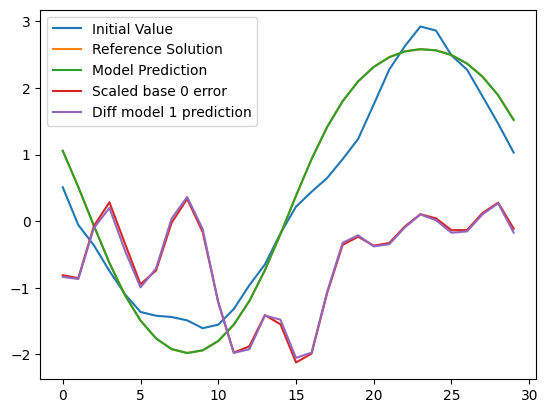

--------------------------------------RUN 3 --------------------------------------
Generated opt_params  3
0  :  3.851e-05
10  :  1.903e-05
20  :  1.687e-05
30  :  1.449e-05
40  :  1.288e-05
50  :  1.163e-05
60  :  1.091e-05
70  :  1.036e-05
80  :  9.951e-06
90  :  9.517e-06
100  :  9.48e-06
110  :  8.501e-06
120  :  8.843e-06
130  :  7.821e-06
140  :  8.044e-06
150  :  7.155e-06
160  :  7.4e-06
170  :  7.172e-06
180  :  7.297e-06
190  :  7.22e-06
200  :  6.733e-06
210  :  6.52e-06
220  :  6.485e-06
230  :  6.06e-06
240  :  5.792e-06
250  :  6.089e-06
260  :  5.179e-06
270  :  5.36e-06
280  :  4.984e-06
290  :  4.426e-06
300  :  5.03e-06
310  :  4.958e-06
320  :  4.516e-06
330  :  4.519e-06
340  :  4.51e-06
350  :  4.298e-06
360  :  4.214e-06
370  :  4.129e-06
380  :  4.121e-06
390  :  3.837e-06
400  :  3.479e-06
410  :  3.732e-06
420  :  3.683e-06
430  :  3.699e-06
440  :  3.351e-06
450  :  3.217e-06
460  :  2.891e-06
470  :  3.097e-06
480  :  3.823e-06
490  :  3.066e-06
500  :  3e-06

2023-01-25 20:27:56.830838: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 20:27:57.258164: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 20:27:57.682132: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  0.9976
10  :  0.8878
20  :  0.8672
30  :  0.6353
40  :  0.3497
50  :  0.322
60  :  0.2617
70  :  0.1841
80  :  0.1453
90  :  0.1186
100  :  1.103
110  :  0.1026
120  :  0.0766
130  :  0.1033
140  :  0.1356
150  :  0.09212
160  :  0.1138
170  :  0.1115
180  :  0.09682
190  :  0.09587
200  :  0.9768
210  :  0.09604
220  :  0.09846
230  :  0.0862
240  :  0.06613
250  :  0.05969
260  :  0.07657
270  :  0.051
280  :  0.05396
290  :  0.07132
300  :  0.06248
310  :  0.05252
320  :  0.06012
330  :  0.1991
340  :  0.05602
350  :  0.05335
360  :  0.08501
370  :  0.04553
380  :  0.04819
390  :  0.04707
400  :  0.05551
410  :  0.05215
420  :  0.04945
430  :  0.04619
440  :  0.03806
450  :  0.3217
460  :  0.03701
470  :  0.03437
480  :  0.03401
490  :  0.1177
500  :  0.03535
510  :  0.04017
520  :  0.0336
530  :  0.03959
540  :  0.05437
550  :  0.03699
560  :  0.04801
570  :  0.05186
580  :  0.03883
590  :  1.623
600  :  0.04696
610  :  0.06741
620  :  0.03682
    New learning rate:  0.002
  

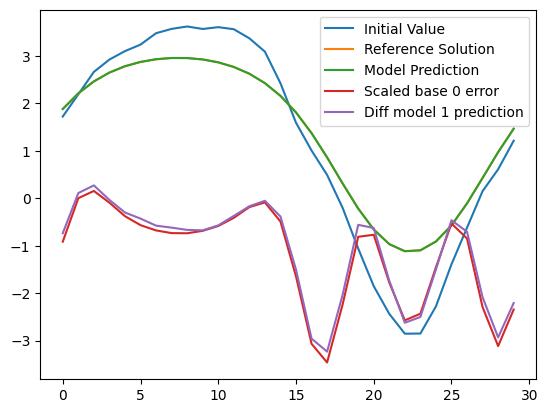

--------------------------------------RUN 4 --------------------------------------
Use opt_params  3  for the  2 th time
------ TRAINING BASE------
------ TRAINING DIFF 0 ------
Est. L2-error:  0.0007640342930812632


2023-01-25 20:31:12.285302: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 20:31:12.693487: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 20:31:13.103036: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.044
10  :  0.9083
20  :  0.8325
30  :  0.5454
40  :  0.398
50  :  0.3023
60  :  0.2462
70  :  0.1693
80  :  0.1955
90  :  0.1505
100  :  0.1287
110  :  0.1651
120  :  0.1166
130  :  0.1135
140  :  0.09775
150  :  0.1022
160  :  0.08337
170  :  0.1061
180  :  0.09204
190  :  0.07578
200  :  0.08778
210  :  0.08144
220  :  0.2343
230  :  0.05653
240  :  0.05198
250  :  0.04673
260  :  0.0478
270  :  0.03929
280  :  0.05596
290  :  0.06468
300  :  0.07001
310  :  0.04779
320  :  0.05456
330  :  0.05701
340  :  0.04721
350  :  0.06559
360  :  0.05292
370  :  0.05975
380  :  0.05506
390  :  0.05801
400  :  0.04354
410  :  0.05456
    New learning rate:  0.002
    New Batch size:  1024
420  :  0.05258
430  :  0.03003
440  :  0.0339
450  :  0.03031
460  :  0.02723
470  :  0.02943
480  :  0.03084
490  :  0.02727
500  :  0.04109
510  :  0.0275
520  :  0.02243
530  :  0.02312
540  :  0.02682
550  :  0.0251
560  :  0.0257
570  :  0.02233
580  :  0.02332
590  :  0.2038
600  :  0.04114
610 

--------------------------------------RUN 5 --------------------------------------
Use opt_params  3  for the  3 th time
------ TRAINING BASE------
------ TRAINING DIFF 0 ------
Est. L2-error:  0.0007640342930812632


2023-01-25 20:33:12.070235: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 20:33:12.472450: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 20:33:12.874162: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.008
10  :  1.01
20  :  0.7959
30  :  0.564
40  :  0.4377
50  :  0.3361
60  :  0.26
70  :  0.228
80  :  0.1973
90  :  0.1614
100  :  0.1426
110  :  0.1205
120  :  0.1109
130  :  0.09515
140  :  0.09026
150  :  0.09255
160  :  0.07477
170  :  0.08034
180  :  0.05965
190  :  0.05879
200  :  0.06288
210  :  0.06487
220  :  0.08207
230  :  0.06629
240  :  0.1155
250  :  0.06581
260  :  0.06131
270  :  0.04901
280  :  0.05884
290  :  0.04852
300  :  0.04692
310  :  0.06178
320  :  0.04642
330  :  0.05205
340  :  0.05944
350  :  0.06054
360  :  0.06835
370  :  0.07652
380  :  0.07198
390  :  0.1094
400  :  0.0763
410  :  0.1104
420  :  0.1181
430  :  0.1386
440  :  0.09604
    New learning rate:  0.002
    New Batch size:  1024
450  :  0.06742
460  :  0.059
470  :  0.04573
480  :  0.04185
490  :  0.04048
500  :  0.05017
510  :  0.03321
520  :  0.03859
530  :  0.04041
540  :  0.03561
550  :  0.03264
560  :  0.0323
570  :  0.03471
580  :  0.02958
590  :  0.0308
600  :  0.04961
610  :  0

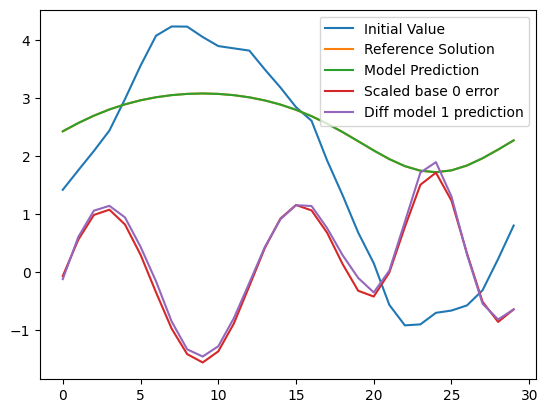

--------------------------------------RUN 6 --------------------------------------
Use opt_params  1  for the  2 th time
------ TRAINING BASE------
------ TRAINING DIFF 0 ------
Est. L2-error:  0.000520409083076337


2023-01-25 20:35:38.473471: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 20:35:38.887510: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 20:35:39.303886: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  0.9745
10  :  0.9005
20  :  0.7898
30  :  0.6008
40  :  0.4409
50  :  0.3456
60  :  0.2611
70  :  0.2522
80  :  0.2055
90  :  0.2065
100  :  0.1238
110  :  0.1116
120  :  0.1286
130  :  0.08613
140  :  0.08708
150  :  0.08826
160  :  0.08007
170  :  0.07427
180  :  0.06643
190  :  0.08017
200  :  0.06794
210  :  0.06766
220  :  0.06233
230  :  0.06456
240  :  0.09869
250  :  0.1573
260  :  0.1559
270  :  0.1375
280  :  0.1229
290  :  0.08598
300  :  0.06809
310  :  0.06808
320  :  0.05822
330  :  0.06796
340  :  0.04262
350  :  0.04272
360  :  0.03081
370  :  0.04374
380  :  0.03819
390  :  0.03919
400  :  0.03057
410  :  0.03583
420  :  0.02636
430  :  0.02751
440  :  0.04046
450  :  0.04479
460  :  0.03416
470  :  0.02532
480  :  0.02333
490  :  0.0287
500  :  0.03373
510  :  0.03407
520  :  0.03017
530  :  0.03971
540  :  0.054
550  :  0.0499
560  :  0.1935
570  :  0.03712
580  :  0.03751
590  :  0.03032
600  :  0.02828
610  :  0.02486
620  :  0.0207
630  :  0.02645
640  :  0.

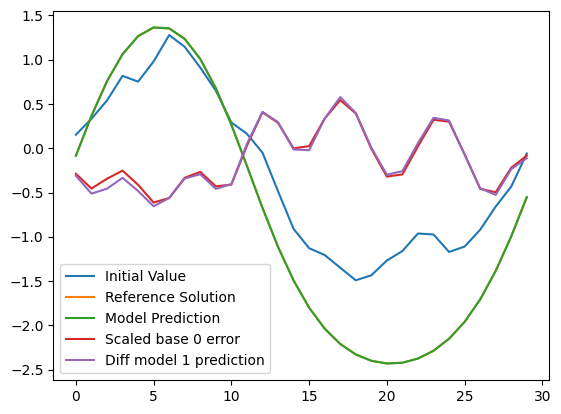

--------------------------------------RUN 7 --------------------------------------
Use opt_params  1  for the  3 th time
------ TRAINING BASE------
------ TRAINING DIFF 0 ------
Est. L2-error:  0.000520409083076337


2023-01-25 20:38:14.447002: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 20:38:14.843471: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 20:38:15.240755: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  0.9267
10  :  0.8886
20  :  0.6246
30  :  0.5099
40  :  0.4226
50  :  0.3651
60  :  0.3101
70  :  0.2819
80  :  0.2436
90  :  0.1893
100  :  0.1817
110  :  0.1537
120  :  0.1773
130  :  0.1133
140  :  0.1261
150  :  0.1149
160  :  0.1324
170  :  0.1555
180  :  0.1577
190  :  0.1348
200  :  0.1073
210  :  0.1111
220  :  0.08952
230  :  0.08128
240  :  0.07939
250  :  0.08666
260  :  0.09388
270  :  0.08588
280  :  0.08642
290  :  0.1064
300  :  0.07329
310  :  0.06286
320  :  0.07381
330  :  0.05255
340  :  0.06615
350  :  0.05409
360  :  0.04851
370  :  0.04774
380  :  0.03511
390  :  0.03523
400  :  0.04628
410  :  0.0328
420  :  0.03052
430  :  0.02787
440  :  0.02872
450  :  0.02952
460  :  0.03119
470  :  0.03216
480  :  0.0297
490  :  0.0299
500  :  0.09538
510  :  0.09498
520  :  0.06887
530  :  0.06136
540  :  0.05745
550  :  0.04392
560  :  0.03732
570  :  0.03055
580  :  0.02874
590  :  0.02979
600  :  0.02628
610  :  0.02274
620  :  0.02286
630  :  0.02327
640  :  0.034

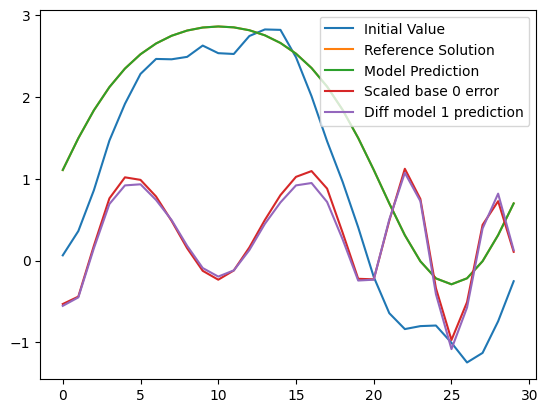

--------------------------------------RUN 8 --------------------------------------
Generated opt_params  4
0  :  3.264e-05
10  :  1.185e-05
20  :  1.003e-05
30  :  8.464e-06
40  :  7.055e-06
50  :  6.466e-06
60  :  5.307e-06
70  :  5.134e-06
80  :  4.736e-06
90  :  4.282e-06
100  :  4.005e-06
110  :  3.514e-06
120  :  3.611e-06
130  :  3.378e-06
140  :  3.259e-06
150  :  3.134e-06
160  :  2.962e-06
170  :  3.044e-06
180  :  2.999e-06
190  :  2.625e-06
200  :  2.615e-06
210  :  2.488e-06
220  :  2.478e-06
230  :  2.277e-06
240  :  2.167e-06
250  :  2.102e-06
260  :  2.07e-06
270  :  1.981e-06
280  :  1.917e-06
290  :  1.9e-06
300  :  1.663e-06
310  :  1.737e-06
320  :  1.748e-06
330  :  1.722e-06
340  :  1.511e-06
350  :  1.515e-06
360  :  1.516e-06
370  :  1.43e-06
380  :  1.373e-06
390  :  1.362e-06
400  :  1.283e-06
410  :  1.227e-06
420  :  1.251e-06
430  :  1.122e-06
440  :  1.201e-06
450  :  1.083e-06
460  :  1.091e-06
470  :  1.065e-06
480  :  1.066e-06
490  :  1.057e-06
500  :  

4310  :  7.901e-08
4320  :  7.576e-08
4330  :  7.959e-08
4340  :  7.517e-08
4350  :  7.649e-08
4360  :  7.588e-08
4370  :  7.93e-08
4380  :  7.969e-08
4390  :  7.976e-08
4400  :  7.827e-08
4410  :  7.777e-08
4420  :  7.793e-08
4430  :  7.654e-08
4440  :  7.561e-08
4450  :  8.635e-08
4460  :  7.645e-08
4470  :  7.754e-08
4480  :  7.407e-08
    New learning rate:  4e-08
    New Batch size:  2048
4490  :  7.834e-08
4500  :  7.721e-08
4510  :  7.741e-08
4520  :  7.813e-08
4530  :  7.795e-08
4540  :  7.918e-08
4550  :  7.669e-08
4560  :  7.832e-08
4570  :  7.695e-08
4580  :  7.83e-08
4590  :  7.672e-08
4600  :  8.564e-08
4610  :  7.873e-08
Training ended due to inssuficient improvement
------ TRAINING BASE------
------ TRAINING DIFF 0 ------
Est. L2-error:  0.00027626806317434095


2023-01-25 20:45:13.943387: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 20:45:14.328674: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 20:45:14.712905: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.048
10  :  0.839
20  :  0.7346
30  :  0.6013
40  :  0.4779
50  :  0.4596
60  :  0.4285
70  :  0.3407
80  :  0.4089
90  :  0.3471
100  :  0.254
110  :  0.2713
120  :  0.2136
130  :  0.2268
140  :  0.1898
150  :  0.2084
160  :  0.1559
170  :  0.2198
180  :  0.1706
190  :  0.1852
200  :  0.1931
210  :  0.134
220  :  0.1039
230  :  0.08945
240  :  0.08068
250  :  0.08031
260  :  0.0679
270  :  0.07443
280  :  0.1195
290  :  0.05068
300  :  0.04835
310  :  0.05228
320  :  0.09427
330  :  0.05286
340  :  0.04636
350  :  0.04863
360  :  0.0549
370  :  0.06004
380  :  0.04625
390  :  0.04473
400  :  0.04106
410  :  0.06184
420  :  0.05165
430  :  0.04577
440  :  0.05817
450  :  0.0611
460  :  0.05469
470  :  0.03992
480  :  0.03585
490  :  0.0362
500  :  0.09724
510  :  0.03485
520  :  0.05525
530  :  0.09975
540  :  0.03827
550  :  0.04436
560  :  0.09083
570  :  0.02983
580  :  0.03584
590  :  0.03477
600  :  0.02856
610  :  0.05194
620  :  0.02982
630  :  0.03055
640  :  0.03658
650

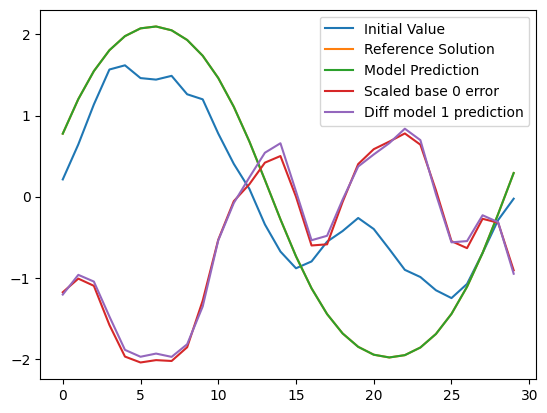

--------------------------------------RUN 9 --------------------------------------
Use opt_params  4  for the  2 th time
------ TRAINING BASE------
------ TRAINING DIFF 0 ------
Est. L2-error:  0.00027626806317434095


2023-01-25 20:48:10.442851: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 20:48:10.828423: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 20:48:11.210507: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.037
10  :  0.8693
20  :  0.7839
30  :  0.8263
40  :  0.6273
50  :  0.5431
60  :  0.3737
70  :  0.3257
80  :  0.3383
90  :  0.2588
100  :  0.2539
110  :  0.1976
120  :  0.1747
130  :  0.1654
140  :  0.1371
150  :  0.1002
160  :  0.1051
170  :  0.09338
180  :  0.08928
190  :  0.09947
200  :  0.08324
210  :  0.07757
220  :  0.07672
230  :  0.07253
240  :  0.08154
250  :  0.1614
260  :  0.06618
270  :  0.05547
280  :  0.07695
290  :  0.05995
300  :  0.05143
310  :  0.06246
320  :  0.07495
330  :  0.0596
340  :  0.03936
350  :  0.08842
360  :  0.04161
370  :  0.03437
380  :  0.09809
390  :  0.05222
400  :  0.1024
410  :  0.08084
420  :  0.05729
430  :  0.06199
440  :  0.04278
450  :  0.04283
460  :  0.03443
470  :  0.1423
480  :  0.04373
490  :  0.02773
500  :  0.03726
510  :  0.03134
520  :  0.03834
530  :  0.03107
540  :  0.08773
550  :  0.03672
560  :  0.04284
570  :  0.03122
580  :  0.03508
590  :  0.03014
600  :  0.02624
610  :  0.03163
620  :  0.03158
630  :  0.03604
640  :  0

--------------------------------------RUN 10 --------------------------------------
Use opt_params  4  for the  3 th time
------ TRAINING BASE------
------ TRAINING DIFF 0 ------
Est. L2-error:  0.00027626806317434095


2023-01-25 20:50:10.511907: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 20:50:10.895405: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 20:50:11.278436: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.023
10  :  0.854
20  :  0.9495
30  :  0.8001
40  :  0.5525
50  :  0.48
60  :  0.4239
70  :  0.4202
80  :  0.4361
90  :  0.2707
100  :  0.3133
110  :  0.2511
120  :  0.2563
130  :  0.2918
140  :  0.1818
150  :  0.196
160  :  0.1407
170  :  0.1388
180  :  0.1438
190  :  0.1625
200  :  0.1729
210  :  0.1462
220  :  0.1567
230  :  0.1263
240  :  0.1103
250  :  0.07767
260  :  0.07377
270  :  0.09509
280  :  0.09548
290  :  0.06699
300  :  0.0645
310  :  0.05107
320  :  0.05031
330  :  0.6612
340  :  0.06695
350  :  0.05672
360  :  0.04949
370  :  0.05302
380  :  0.06441
390  :  0.0671
400  :  0.0788
410  :  0.08591
420  :  0.1708
430  :  0.09581
440  :  0.07067
450  :  0.05305
    New learning rate:  0.002
    New Batch size:  1024
460  :  0.04203
470  :  0.04184
480  :  0.04613
490  :  0.03456
500  :  0.06344
510  :  0.03367
520  :  0.03033
530  :  0.03296
540  :  0.03687
550  :  0.04038
560  :  0.03786
570  :  0.03121
580  :  0.03129
590  :  0.02972
600  :  0.0347
610  :  0.02567

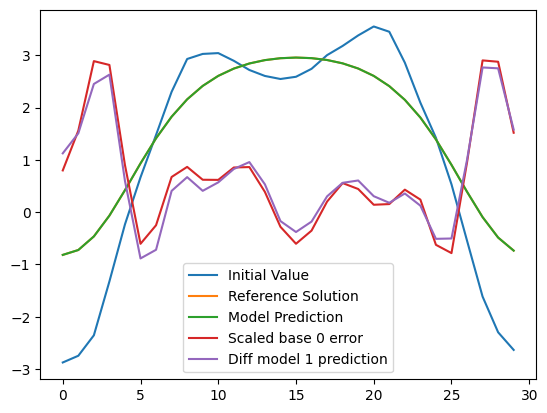

--------------------------------------RUN 11 --------------------------------------
Generated opt_params  5
0  :  3.732e-05
10  :  1.82e-05
20  :  1.676e-05
30  :  1.336e-05
40  :  1.222e-05
50  :  1.104e-05
60  :  1.099e-05
70  :  1.011e-05
80  :  1.002e-05
90  :  9.016e-06
100  :  8.554e-06
110  :  7.922e-06
120  :  8.174e-06
130  :  8.199e-06
140  :  7.304e-06
150  :  7.206e-06
160  :  6.802e-06
170  :  6.819e-06
180  :  6.631e-06
190  :  6.186e-06
200  :  6.507e-06
210  :  5.643e-06
220  :  5.722e-06
230  :  5.55e-06
240  :  5.855e-06
250  :  5.399e-06
260  :  5.219e-06
270  :  4.876e-06
280  :  4.887e-06
290  :  5.013e-06
300  :  4.612e-06
310  :  4.151e-06
320  :  4.359e-06
330  :  4.559e-06
340  :  4.119e-06
350  :  3.915e-06
360  :  3.975e-06
370  :  4.072e-06
380  :  3.568e-06
390  :  3.562e-06
400  :  3.4e-06
410  :  3.24e-06
420  :  3.276e-06
430  :  3.163e-06
440  :  3.204e-06
450  :  2.834e-06
460  :  2.884e-06
470  :  2.78e-06
480  :  2.754e-06
490  :  2.55e-06
500  :  2.

2023-01-25 20:55:41.003106: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 20:55:41.377494: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 20:55:41.751274: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.066
10  :  0.9613
20  :  0.8416
30  :  0.5851
40  :  0.4448
50  :  0.3562
60  :  0.2714
70  :  0.2153
80  :  0.1623
90  :  0.1461
100  :  0.127
110  :  0.1458
120  :  0.1266
130  :  0.1823
140  :  0.1312
150  :  0.1144
160  :  0.0946
170  :  0.1081
180  :  0.07903
190  :  0.06341
200  :  0.05307
210  :  0.06797
220  :  0.06924
230  :  0.06416
240  :  0.06976
250  :  0.0706
260  :  0.07228
270  :  0.07402
280  :  0.06373
290  :  0.09875
300  :  0.05324
310  :  0.03384
320  :  0.03132
330  :  0.02939
340  :  0.02817
350  :  0.03275
360  :  0.02588
370  :  0.03548
380  :  0.02918
390  :  0.05045
400  :  0.05016
410  :  0.03673
420  :  0.02716
430  :  0.4396
440  :  0.03755
450  :  0.03769
460  :  0.02692
470  :  0.02749
480  :  0.02751
490  :  0.0253
500  :  0.0226
510  :  0.02886
520  :  0.02614
530  :  0.02254
540  :  0.02212
550  :  0.03233
560  :  0.02941
570  :  0.03095
580  :  0.05507
590  :  0.05398
600  :  0.04024
610  :  0.03354
620  :  0.02932
630  :  0.02497
640  :  0.0

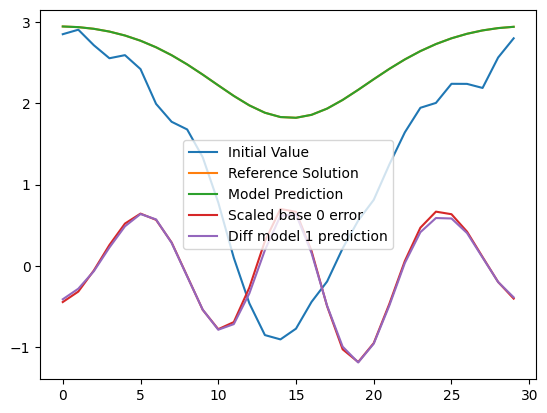

--------------------------------------RUN 12 --------------------------------------
Generated opt_params  6
0  :  3.085e-05
10  :  1.16e-05
20  :  9.916e-06
30  :  7.645e-06
40  :  6.824e-06
50  :  6.102e-06
60  :  5.422e-06
70  :  4.697e-06
80  :  4.397e-06
90  :  3.988e-06
100  :  4.114e-06
110  :  3.743e-06
120  :  3.48e-06
130  :  3.323e-06
140  :  3.191e-06
150  :  2.87e-06
160  :  3.109e-06
170  :  2.965e-06
180  :  2.51e-06
190  :  2.665e-06
200  :  2.207e-06
210  :  2.34e-06
220  :  2.29e-06
230  :  2.158e-06
240  :  2.096e-06
250  :  2.041e-06
260  :  2.016e-06
270  :  1.899e-06
280  :  1.793e-06
290  :  1.632e-06
300  :  1.561e-06
310  :  1.606e-06
320  :  1.532e-06
330  :  1.506e-06
340  :  1.503e-06
350  :  1.454e-06
360  :  1.381e-06
370  :  1.323e-06
380  :  1.245e-06
390  :  1.291e-06
400  :  1.302e-06
410  :  1.225e-06
420  :  1.162e-06
430  :  1.174e-06
440  :  1.074e-06
450  :  1.048e-06
460  :  1.037e-06
470  :  9.774e-07
480  :  1.006e-06
490  :  9.781e-07
500  :  9

2023-01-25 21:01:04.011491: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 21:01:04.383184: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 21:01:04.754273: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.064
10  :  0.8004
20  :  0.77
30  :  0.6729
40  :  0.6155
50  :  0.4813
60  :  0.3673
70  :  0.2891
80  :  0.257
90  :  0.3247
100  :  0.2207
110  :  0.1902
120  :  0.1673
130  :  0.1776
140  :  0.1364
150  :  0.1522
160  :  0.1177
170  :  0.1244
180  :  0.1116
190  :  0.0921
200  :  0.1277
210  :  0.08181
220  :  0.08799
230  :  0.07716
240  :  0.05882
250  :  0.07671
260  :  0.07648
270  :  0.08277
280  :  0.07375
290  :  0.05454
300  :  0.05528
310  :  0.05185
320  :  0.04203
330  :  0.03867
340  :  0.04768
350  :  0.08733
360  :  0.04918
370  :  0.05569
380  :  0.04913
390  :  0.04563
400  :  0.0355
410  :  0.0427
420  :  0.05526
430  :  0.03974
440  :  0.0473
450  :  0.03826
460  :  0.04153
470  :  0.03149
480  :  0.03546
490  :  0.04089
500  :  0.03237
510  :  0.04035
520  :  0.05406
530  :  0.03311
540  :  0.03324
550  :  0.03556
560  :  0.03224
570  :  0.02676
580  :  0.0326
590  :  0.02904
600  :  0.02597
610  :  0.03504
620  :  0.03021
630  :  0.02793
640  :  0.0322
6

--------------------------------------RUN 13 --------------------------------------
Generated opt_params  7
0  :  3.993e-05
10  :  1.641e-05
20  :  1.348e-05
30  :  1.129e-05
40  :  9.78e-06
50  :  8.529e-06
60  :  6.943e-06
70  :  7.104e-06
80  :  6.745e-06
90  :  6.326e-06
100  :  5.899e-06
110  :  5.438e-06
120  :  5.569e-06
130  :  5.178e-06
140  :  5.214e-06
150  :  4.843e-06
160  :  4.775e-06
170  :  4.532e-06
180  :  4.233e-06
190  :  4.158e-06
200  :  4.123e-06
210  :  3.958e-06
220  :  3.614e-06
230  :  3.932e-06
240  :  3.792e-06
250  :  3.383e-06
260  :  3.671e-06
270  :  3.387e-06
280  :  3.078e-06
290  :  3.539e-06
300  :  3.075e-06
310  :  3.085e-06
320  :  2.902e-06
330  :  2.757e-06
340  :  2.719e-06
350  :  2.466e-06
360  :  2.59e-06
370  :  2.475e-06
380  :  2.454e-06
390  :  2.46e-06
400  :  2.546e-06
410  :  2.335e-06
420  :  2.293e-06
430  :  2.224e-06
440  :  2.154e-06
450  :  2.126e-06
460  :  2.067e-06
470  :  1.991e-06
480  :  1.905e-06
490  :  1.826e-06
500  :

2023-01-25 21:06:50.976225: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 21:06:51.348616: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 21:06:51.720336: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.039
10  :  0.979
20  :  0.9212
30  :  0.7526
40  :  0.55
50  :  0.379
60  :  0.3171
70  :  0.2455
80  :  0.1748
90  :  0.137
100  :  0.1213
110  :  0.1236
120  :  0.1191
130  :  0.1303
140  :  0.07623
150  :  0.09485
160  :  0.09178
170  :  0.08713
180  :  0.09851
190  :  0.2611
200  :  0.2419
210  :  0.1289
220  :  0.1171
230  :  0.08876
240  :  0.08051
250  :  0.06267
260  :  0.05271
270  :  0.0458
280  :  0.04195
290  :  0.04699
300  :  0.08085
310  :  0.07016
320  :  0.04676
330  :  0.03906
340  :  0.05007
350  :  0.03672
360  :  0.04063
370  :  0.04862
380  :  0.03756
390  :  0.03049
400  :  0.03545
410  :  0.03537
420  :  0.02936
430  :  0.03152
440  :  0.02937
450  :  0.03633
460  :  0.02809
470  :  0.03557
480  :  0.03026
490  :  0.02963
500  :  0.03317
510  :  0.05425
520  :  0.02652
530  :  0.02211
540  :  0.02522
550  :  0.02495
560  :  0.02292
570  :  0.02224
580  :  0.0195
590  :  0.03275
600  :  0.02494
610  :  0.03483
620  :  0.02254
630  :  0.03078
640  :  0.030

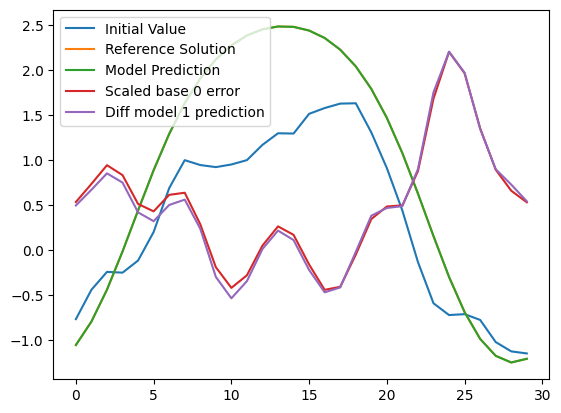

--------------------------------------RUN 14 --------------------------------------
Use opt_params  6  for the  2 th time
------ TRAINING BASE------
------ TRAINING DIFF 0 ------
Est. L2-error:  0.00032836572501372734


2023-01-25 21:09:11.358458: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 21:09:11.729692: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 21:09:12.101388: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  0.9809
10  :  0.857
20  :  0.7527
30  :  0.6731
40  :  0.5039
50  :  0.4049
60  :  0.2985
70  :  0.2738
80  :  0.235
90  :  0.1989
100  :  0.1844
110  :  0.173
120  :  0.1146
130  :  0.1162
140  :  0.1082
150  :  0.102
160  :  0.08823
170  :  0.07372
180  :  0.07654
190  :  0.07337
200  :  0.07558
210  :  0.0675
220  :  0.08255
230  :  0.07661
240  :  0.08918
250  :  0.1054
260  :  0.1551
270  :  0.09848
280  :  0.0785
290  :  0.06168
300  :  0.06669
310  :  0.06474
320  :  0.0769
330  :  0.06667
340  :  0.06138
350  :  0.0828
360  :  0.05813
370  :  0.04985
380  :  0.04604
390  :  0.05392
400  :  0.04638
410  :  0.0431
420  :  0.04442
430  :  0.03189
440  :  0.07992
450  :  0.1008
460  :  0.04641
470  :  0.04967
480  :  0.04796
490  :  0.04291
500  :  0.04049
510  :  0.04029
520  :  0.04614
530  :  0.0315
540  :  0.03829
550  :  0.04541
560  :  0.03464
570  :  0.03089
580  :  0.02338
590  :  0.02808
600  :  0.03326
610  :  0.0336
620  :  0.02922
630  :  0.03537
640  :  0.03282
6

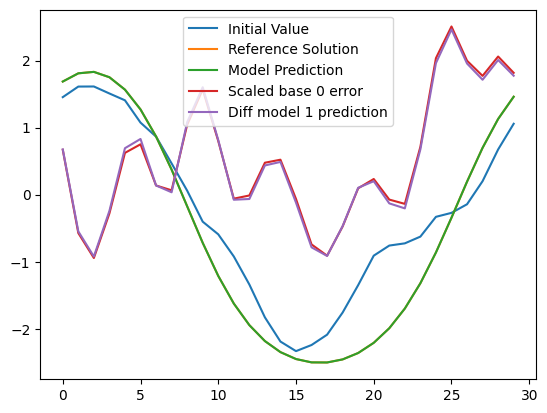

--------------------------------------RUN 15 --------------------------------------
Use opt_params  6  for the  3 th time
------ TRAINING BASE------
------ TRAINING DIFF 0 ------
Est. L2-error:  0.00032836572501372734


2023-01-25 21:11:55.023362: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 21:11:55.401770: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 21:11:55.783427: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  0.9741
10  :  0.8907
20  :  0.7738
30  :  0.6072
40  :  0.4596
50  :  0.3726
60  :  0.29
70  :  0.2752
80  :  0.2564
90  :  0.2144
100  :  0.1671
110  :  0.1498
120  :  0.2084
130  :  0.1695
140  :  0.1842
150  :  0.1486
160  :  0.1375
170  :  0.12
180  :  0.1202
190  :  0.1194
200  :  0.1082
210  :  0.0967
220  :  0.09664
230  :  0.07951
240  :  0.06512
250  :  0.1214
260  :  0.05733
270  :  0.06554
280  :  0.06308
290  :  0.0472
300  :  0.05845
310  :  0.06125
320  :  0.04957
330  :  0.05639
340  :  0.05729
350  :  0.05902
360  :  0.1158
370  :  0.04782
380  :  0.1144
390  :  0.05852
400  :  0.04213
410  :  0.04756
420  :  0.0787
430  :  0.05905
440  :  0.09507
450  :  0.09918
460  :  0.09109
470  :  0.06548
480  :  0.0526
490  :  0.05391
500  :  0.04418
510  :  0.03972
520  :  0.03877
530  :  0.1142
540  :  0.03386
550  :  0.03265
560  :  0.03065
570  :  0.02929
580  :  0.04983
590  :  0.05604
600  :  0.03848
610  :  0.0321
620  :  0.02639
630  :  0.0396
640  :  0.02716
650  :

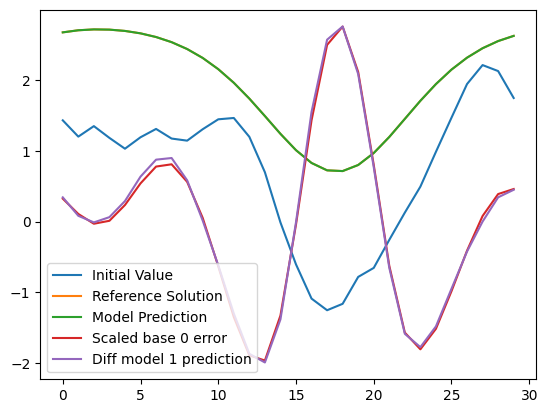

--------------------------------------RUN 16 --------------------------------------
Generated opt_params  8
0  :  2.916e-05
10  :  1.255e-05
20  :  1.028e-05
30  :  8.045e-06
40  :  7.759e-06
50  :  6.66e-06
60  :  5.841e-06
70  :  5.112e-06
80  :  4.827e-06
90  :  4.287e-06
100  :  3.883e-06
110  :  4.243e-06
120  :  3.981e-06
130  :  3.54e-06
140  :  3.084e-06
150  :  3.498e-06
160  :  3.2e-06
170  :  2.981e-06
180  :  2.929e-06
190  :  2.72e-06
200  :  2.591e-06
210  :  2.529e-06
220  :  2.429e-06
230  :  2.319e-06
240  :  2.105e-06
250  :  2.074e-06
260  :  2.134e-06
270  :  1.908e-06
280  :  2.14e-06
290  :  1.89e-06
300  :  1.724e-06
310  :  1.739e-06
320  :  1.647e-06
330  :  1.521e-06
340  :  1.533e-06
350  :  1.459e-06
360  :  1.432e-06
370  :  1.29e-06
380  :  1.33e-06
390  :  1.299e-06
400  :  1.295e-06
410  :  1.246e-06
420  :  1.202e-06
430  :  1.135e-06
440  :  1.192e-06
450  :  1.12e-06
460  :  1.086e-06
470  :  1.066e-06
480  :  1.018e-06
490  :  1.033e-06
500  :  1.011

2023-01-25 21:19:42.298733: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 21:19:42.670942: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 21:19:43.043616: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.024
10  :  0.9002
20  :  0.8462
30  :  0.7169
40  :  0.6077
50  :  0.5212
60  :  0.4869
70  :  0.3974
80  :  0.3653
90  :  0.3282
100  :  0.2249
110  :  0.2468
120  :  0.2207
130  :  0.1851
140  :  0.1725
150  :  0.2068
160  :  0.2064
170  :  0.2161
180  :  0.19
190  :  0.205
200  :  0.1508
210  :  0.1577
220  :  0.1148
230  :  0.117
240  :  0.1077
250  :  0.1039
260  :  0.1003
270  :  0.08911
280  :  0.08886
290  :  0.0897
300  :  0.08686
310  :  0.06857
320  :  0.08042
330  :  0.06833
340  :  0.0741
350  :  0.06888
360  :  0.06144
370  :  0.06132
380  :  0.06849
390  :  0.06408
400  :  0.07533
410  :  0.06958
420  :  0.06553
430  :  0.05075
440  :  0.08535
450  :  0.05683
460  :  0.05324
470  :  0.06949
480  :  0.04417
490  :  0.0401
500  :  0.04843
510  :  0.03839
520  :  0.0427
530  :  0.05161
540  :  0.04524
550  :  0.03744
560  :  0.05257
570  :  0.08429
580  :  0.05264
590  :  0.03964
600  :  0.03936
610  :  0.04219
620  :  0.04963
630  :  0.04742
640  :  0.03436
650  : 

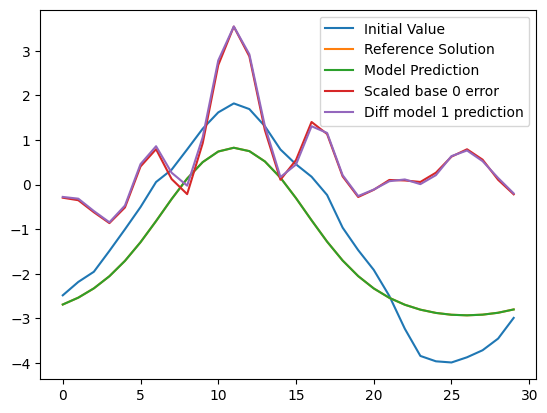

--------------------------------------RUN 17 --------------------------------------
Generated opt_params  9
0  :  2.916e-05
10  :  1.053e-05
20  :  9.937e-06
30  :  7.645e-06
40  :  6.851e-06
50  :  6.118e-06
60  :  4.872e-06
70  :  4.928e-06
80  :  4.114e-06
90  :  4.025e-06
100  :  3.819e-06
110  :  3.463e-06
120  :  3.51e-06
130  :  3.483e-06
140  :  3.188e-06
150  :  2.938e-06
160  :  3.015e-06
170  :  2.949e-06
180  :  2.769e-06
190  :  2.516e-06
200  :  2.387e-06
210  :  2.201e-06
220  :  2.284e-06
230  :  2.091e-06
240  :  1.917e-06
250  :  1.874e-06
260  :  1.814e-06
270  :  1.649e-06
280  :  1.716e-06
290  :  1.719e-06
300  :  1.514e-06
310  :  1.54e-06
320  :  1.417e-06
330  :  1.366e-06
340  :  1.359e-06
350  :  1.267e-06
360  :  1.268e-06
370  :  1.255e-06
380  :  1.248e-06
390  :  1.213e-06
400  :  1.109e-06
410  :  1.084e-06
420  :  1.001e-06
430  :  1.027e-06
440  :  1.062e-06
450  :  9.435e-07
460  :  1.06e-06
470  :  9.383e-07
480  :  9.333e-07
490  :  8.627e-07
500  :

4310  :  9.842e-08
4320  :  9.332e-08
4330  :  9.969e-08
4340  :  9.903e-08
4350  :  9.808e-08
4360  :  9.55e-08
4370  :  9.924e-08
4380  :  1.013e-07
4390  :  9.445e-08
4400  :  1.001e-07
4410  :  9.333e-08
4420  :  1.055e-07
4430  :  9.736e-08
4440  :  9.195e-08
4450  :  1.006e-07
4460  :  9.822e-08
4470  :  9.75e-08
4480  :  9.346e-08
4490  :  9.283e-08
4500  :  9.785e-08
4510  :  9.382e-08
4520  :  9.525e-08
    New learning rate:  4e-08
    New Batch size:  2048
4530  :  9.281e-08
4540  :  1.001e-07
4550  :  9.556e-08
4560  :  9.463e-08
4570  :  9.665e-08
4580  :  9.499e-08
4590  :  9.59e-08
4600  :  9.359e-08
4610  :  9.483e-08
4620  :  9.407e-08
4630  :  9.814e-08
4640  :  9.709e-08
4650  :  9.289e-08
Training ended due to inssuficient improvement
------ TRAINING BASE------
------ TRAINING DIFF 0 ------
Est. L2-error:  0.00030307398614664037


2023-01-25 21:27:34.429417: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 21:27:34.801813: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 21:27:35.174769: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.018
10  :  0.8268
20  :  0.8212
30  :  0.8731
40  :  0.7769
50  :  0.5654
60  :  0.4689
70  :  0.4605
80  :  0.3439
90  :  0.3222
100  :  0.3346
110  :  0.2878
120  :  0.2486
130  :  0.2344
140  :  0.2044
150  :  0.1878
160  :  0.1442
170  :  0.1426
180  :  0.1526
190  :  0.1421
200  :  0.1362
210  :  0.1618
220  :  0.1356
230  :  0.1373
240  :  0.1595
250  :  0.1065
260  :  0.1071
270  :  0.0945
280  :  0.093
290  :  0.0945
300  :  0.09946
310  :  0.1039
320  :  0.1135
330  :  0.1345
340  :  0.119
350  :  0.1038
360  :  0.1159
370  :  0.09066
380  :  0.07566
390  :  0.07351
400  :  0.07335
410  :  0.08975
420  :  0.06312
430  :  0.05995
440  :  0.06533
450  :  0.05996
460  :  0.07677
470  :  0.08111
480  :  0.06414
490  :  0.04963
500  :  0.05843
510  :  0.04839
520  :  0.07234
530  :  0.06379
540  :  0.05722
550  :  0.06405
560  :  0.07002
570  :  0.07241
580  :  0.07946
590  :  0.05781
600  :  0.05259
610  :  0.05221
620  :  0.05473
630  :  0.06744
640  :  0.04451
650  :  0.

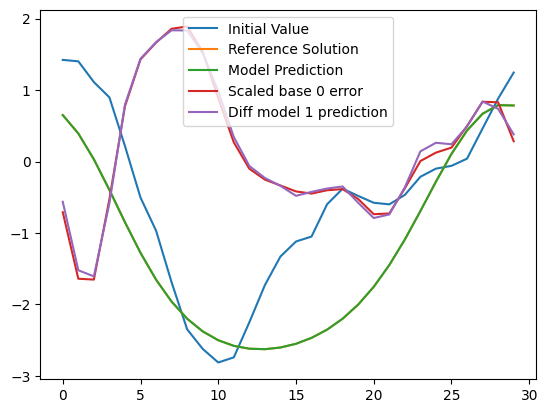

--------------------------------------RUN 18 --------------------------------------
Generated opt_params  10
0  :  3.243e-05
10  :  1.237e-05
20  :  1.026e-05
30  :  8.178e-06
40  :  7.085e-06
50  :  5.86e-06
60  :  5.568e-06
70  :  4.664e-06
80  :  4.535e-06
90  :  3.918e-06
100  :  3.819e-06
110  :  3.545e-06
120  :  3.367e-06
130  :  3.213e-06
140  :  3.016e-06
150  :  3.034e-06
160  :  2.956e-06
170  :  2.89e-06
180  :  2.705e-06
190  :  2.474e-06
200  :  2.67e-06
210  :  2.432e-06
220  :  2.443e-06
230  :  2.17e-06
240  :  2.069e-06
250  :  2.009e-06
260  :  1.971e-06
270  :  1.899e-06
280  :  1.797e-06
290  :  1.823e-06
300  :  1.58e-06
310  :  1.649e-06
320  :  1.641e-06
330  :  1.478e-06
340  :  1.368e-06
350  :  1.305e-06
360  :  1.338e-06
370  :  1.297e-06
380  :  1.232e-06
390  :  1.149e-06
400  :  1.166e-06
410  :  1.153e-06
420  :  1.119e-06
430  :  1.072e-06
440  :  1.069e-06
450  :  1.01e-06
460  :  1.045e-06
470  :  1.02e-06
480  :  1.049e-06
490  :  9.142e-07
500  :  9

4310  :  8.29e-08
4320  :  7.898e-08
4330  :  8.551e-08
4340  :  8.018e-08
4350  :  7.765e-08
4360  :  8.377e-08
4370  :  7.877e-08
4380  :  8.08e-08
4390  :  7.664e-08
4400  :  7.953e-08
4410  :  7.646e-08
4420  :  8.007e-08
4430  :  7.654e-08
4440  :  8.254e-08
4450  :  8.207e-08
4460  :  7.799e-08
4470  :  8.16e-08
4480  :  7.997e-08
4490  :  7.658e-08
4500  :  7.873e-08
4510  :  7.748e-08
4520  :  8.134e-08
4530  :  8.049e-08
4540  :  8.111e-08
4550  :  7.924e-08
4560  :  7.845e-08
4570  :  7.771e-08
4580  :  7.837e-08
    New learning rate:  4e-08
    New Batch size:  2048
4590  :  8.014e-08
4600  :  8.292e-08
4610  :  7.977e-08
4620  :  7.755e-08
4630  :  7.832e-08
4640  :  7.823e-08
4650  :  8.149e-08
4660  :  8.091e-08
4670  :  7.846e-08
4680  :  8.052e-08
4690  :  8.033e-08
4700  :  7.862e-08
4710  :  8.091e-08
Training ended due to inssuficient improvement
------ TRAINING BASE------
------ TRAINING DIFF 0 ------
Est. L2-error:  0.00027644242595866413


2023-01-25 21:34:54.055693: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 21:34:54.429267: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 21:34:54.802725: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.061
10  :  0.8464
20  :  0.8233
30  :  0.6461
40  :  0.5298
50  :  0.536
60  :  0.4896
70  :  0.5573
80  :  0.481
90  :  0.3635
100  :  0.4994
110  :  0.4006
120  :  0.3196
130  :  0.2799
140  :  0.2143
150  :  0.179
160  :  0.1629
170  :  0.1518
180  :  0.1408
190  :  0.1521
200  :  0.1125
210  :  0.1
220  :  0.1854
230  :  0.1173
240  :  0.09132
250  :  0.0965
260  :  0.1055
270  :  0.09339
280  :  0.08841
290  :  0.09606
300  :  0.0731
310  :  0.09293
320  :  0.07105
330  :  0.06446
340  :  0.08606
350  :  0.08019
360  :  0.08722
370  :  0.08611
380  :  0.07962
390  :  0.1133
400  :  0.07126
410  :  0.07383
420  :  0.06631
430  :  0.07245
440  :  0.05973
450  :  0.05497
460  :  0.05073
470  :  0.05394
480  :  0.05151
490  :  0.06563
500  :  0.05087
510  :  0.06199
520  :  0.04352
530  :  0.04704
540  :  0.08132
550  :  0.04254
560  :  0.04048
570  :  0.05295
580  :  0.04107
590  :  0.04847
600  :  0.05627
610  :  0.03435
620  :  0.03916
630  :  0.07729
640  :  0.04254
650  :

--------------------------------------RUN 19 --------------------------------------
Generated opt_params  11
0  :  3.591e-05
10  :  1.718e-05
20  :  1.331e-05
30  :  1.151e-05
40  :  1.046e-05
50  :  9.917e-06
60  :  9.331e-06
70  :  7.968e-06
80  :  7.533e-06
90  :  6.673e-06
100  :  6.998e-06
110  :  6.147e-06
120  :  6.664e-06
130  :  5.991e-06
140  :  5.907e-06
150  :  6.39e-06
160  :  5.433e-06
170  :  4.923e-06
180  :  5.466e-06
190  :  4.724e-06
200  :  5.072e-06
210  :  5.17e-06
220  :  4.45e-06
230  :  4.508e-06
240  :  4.29e-06
250  :  4.139e-06
260  :  3.981e-06
270  :  3.896e-06
280  :  3.919e-06
290  :  3.545e-06
300  :  3.801e-06
310  :  3.455e-06
320  :  3.301e-06
330  :  3.264e-06
340  :  3.122e-06
350  :  3.663e-06
360  :  3.054e-06
370  :  2.931e-06
380  :  2.825e-06
390  :  2.957e-06
400  :  2.91e-06
410  :  2.751e-06
420  :  2.652e-06
430  :  2.59e-06
440  :  2.347e-06
450  :  2.497e-06
460  :  2.304e-06
470  :  2.12e-06
480  :  2.227e-06
490  :  2.264e-06
500  :  2

2023-01-25 21:39:38.915948: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 21:39:39.289050: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 21:39:39.662004: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.077
10  :  0.991
20  :  0.9272
30  :  0.5935
40  :  0.4877
50  :  0.327
60  :  0.2645
70  :  0.21
80  :  0.2052
90  :  0.1924
100  :  0.1613
110  :  0.1405
120  :  0.09833
130  :  0.08495
140  :  0.0877
150  :  0.07554
160  :  0.07231
170  :  0.06827
180  :  0.08098
190  :  0.07861
200  :  0.05882
210  :  0.05332
220  :  0.05616
230  :  0.07258
240  :  0.06865
250  :  0.05885
260  :  0.05583
270  :  0.06816
280  :  0.05633
290  :  0.04665
300  :  0.05549
310  :  0.05123
320  :  0.05061
330  :  0.05625
340  :  0.05179
350  :  0.04421
360  :  0.04716
370  :  0.08962
380  :  0.05464
390  :  0.04697
400  :  0.0428
410  :  0.0432
420  :  0.03501
430  :  0.0398
440  :  0.04123
450  :  0.02948
460  :  0.06321
470  :  0.04072
480  :  0.04137
490  :  0.03945
500  :  0.0333
510  :  0.02814
520  :  0.03673
530  :  0.03979
540  :  0.03692
550  :  0.03121
560  :  0.03157
570  :  0.02484
580  :  0.02397
590  :  0.05004
600  :  0.02795
610  :  0.03113
620  :  0.02227
630  :  0.0278
640  :  0.

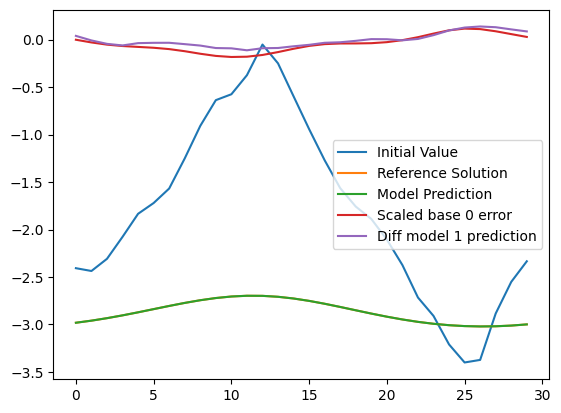

--------------------------------------RUN 20 --------------------------------------
Generated opt_params  12
0  :  3.202e-05
10  :  1.187e-05
20  :  1.053e-05
30  :  8.006e-06
40  :  7.642e-06
50  :  6.424e-06
60  :  5.904e-06
70  :  5.323e-06
80  :  4.642e-06
90  :  4.488e-06
100  :  4.341e-06
110  :  3.932e-06
120  :  3.815e-06
130  :  3.843e-06
140  :  3.631e-06
150  :  3.345e-06
160  :  3.138e-06
170  :  3.001e-06
180  :  2.937e-06
190  :  2.952e-06
200  :  2.627e-06
210  :  2.536e-06
220  :  2.617e-06
230  :  2.237e-06
240  :  2.158e-06
250  :  2.034e-06
260  :  2.016e-06
270  :  1.921e-06
280  :  1.895e-06
290  :  1.765e-06
300  :  1.826e-06
310  :  1.696e-06
320  :  1.483e-06
330  :  1.537e-06
340  :  1.488e-06
350  :  1.466e-06
360  :  1.332e-06
370  :  1.352e-06
380  :  1.378e-06
390  :  1.192e-06
400  :  1.087e-06
410  :  1.139e-06
420  :  1.106e-06
430  :  1.087e-06
440  :  1.017e-06
450  :  1.08e-06
460  :  9.94e-07
470  :  9.857e-07
480  :  9.366e-07
490  :  9.028e-07
500 

2023-01-25 21:45:22.968069: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 21:45:23.342015: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 21:45:23.714831: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.03
10  :  0.8868
20  :  0.8143
30  :  0.6915
40  :  0.5038
50  :  0.442
60  :  0.3583
70  :  0.3393
80  :  0.4119
90  :  0.2309
100  :  0.2125
110  :  0.1872
120  :  0.2448
130  :  0.1947
140  :  0.1997
150  :  0.2617
160  :  0.2026
170  :  0.1689
180  :  0.1588
190  :  0.1457
200  :  0.1344
210  :  0.1222
220  :  0.1019
230  :  0.1324
240  :  0.07771
250  :  0.07663
260  :  0.07373
270  :  0.07627
280  :  0.06936
290  :  0.07657
300  :  0.06668
310  :  0.05446
320  :  0.07013
330  :  0.07307
340  :  0.08239
350  :  0.05355
360  :  0.05315
370  :  0.04743
380  :  0.06371
390  :  0.07711
400  :  0.07066
410  :  0.06493
420  :  0.04585
430  :  0.07157
440  :  0.05392
450  :  0.05131
460  :  0.05066
470  :  0.05178
480  :  0.03756
490  :  0.03946
500  :  0.03836
510  :  0.039
520  :  0.03742
530  :  0.03317
540  :  0.04181
550  :  0.03362
560  :  0.03048
570  :  0.03454
580  :  0.03128
590  :  0.0424
600  :  0.03337
610  :  0.1419
620  :  0.04145
630  :  0.02861
640  :  0.04083
65

--------------------------------------RUN 21 --------------------------------------
Generated opt_params  13
0  :  3.251e-05
10  :  1.238e-05
20  :  1.077e-05
30  :  8.483e-06
40  :  7.257e-06
50  :  6.446e-06
60  :  5.367e-06
70  :  5.096e-06
80  :  4.672e-06
90  :  4.337e-06
100  :  4.156e-06
110  :  3.992e-06
120  :  3.784e-06
130  :  3.447e-06
140  :  3.398e-06
150  :  3.257e-06
160  :  3.097e-06
170  :  3.254e-06
180  :  2.824e-06
190  :  2.618e-06
200  :  2.593e-06
210  :  2.485e-06
220  :  2.405e-06
230  :  2.164e-06
240  :  2.247e-06
250  :  2.134e-06
260  :  2.022e-06
270  :  1.994e-06
280  :  1.905e-06
290  :  1.781e-06
300  :  1.707e-06
310  :  1.854e-06
320  :  1.722e-06
330  :  1.555e-06
340  :  1.676e-06
350  :  1.614e-06
360  :  1.419e-06
370  :  1.428e-06
380  :  1.396e-06
390  :  1.335e-06
400  :  1.305e-06
410  :  1.204e-06
420  :  1.167e-06
430  :  1.163e-06
440  :  1.053e-06
450  :  1.159e-06
460  :  1.08e-06
470  :  1.085e-06
480  :  1.026e-06
490  :  1.017e-06
500

2023-01-25 21:51:16.265870: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 21:51:16.639484: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 21:51:17.014989: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.114
10  :  0.9039
20  :  0.8418
30  :  0.655
40  :  0.5412
50  :  0.4257
60  :  0.412
70  :  0.304
80  :  0.2619
90  :  0.219
100  :  0.2211
110  :  0.1771
120  :  0.1541
130  :  0.156
140  :  0.118
150  :  0.1216
160  :  0.1121
170  :  0.1064
180  :  0.1276
190  :  0.0953
200  :  0.1261
210  :  0.1024
220  :  0.0795
230  :  0.08992
240  :  0.09038
250  :  0.1036
260  :  0.06297
270  :  0.06164
280  :  0.06319
290  :  0.04322
300  :  0.05175
310  :  0.08745
320  :  0.06811
330  :  0.06779
340  :  0.06812
350  :  0.08009
360  :  0.0497
370  :  0.06172
380  :  0.05393
390  :  0.05042
400  :  0.05761
410  :  0.03586
420  :  0.1126
430  :  0.0447
440  :  0.05517
450  :  0.04074
460  :  0.04158
470  :  0.1347
480  :  0.038
490  :  0.04429
500  :  0.03403
510  :  0.03905
520  :  0.0415
530  :  0.03691
540  :  0.06635
550  :  0.04054
560  :  0.04121
570  :  0.03899
580  :  0.1603
590  :  0.03328
600  :  0.029
610  :  0.03052
620  :  0.03214
630  :  0.03425
640  :  0.02931
650  :  0.03

--------------------------------------RUN 22 --------------------------------------
Generated opt_params  14
0  :  3.059e-05
10  :  1.176e-05
20  :  1.029e-05
30  :  8.326e-06
40  :  6.432e-06
50  :  5.774e-06
60  :  5.291e-06
70  :  5.047e-06
80  :  4.652e-06
90  :  3.953e-06
100  :  3.786e-06
110  :  3.467e-06
120  :  3.548e-06
130  :  3.141e-06
140  :  3.179e-06
150  :  2.854e-06
160  :  2.787e-06
170  :  2.556e-06
180  :  2.44e-06
190  :  2.366e-06
200  :  2.196e-06
210  :  2.109e-06
220  :  1.975e-06
230  :  2.038e-06
240  :  1.955e-06
250  :  1.63e-06
260  :  1.621e-06
270  :  1.654e-06
280  :  1.575e-06
290  :  1.486e-06
300  :  1.369e-06
310  :  1.37e-06
320  :  1.243e-06
330  :  1.235e-06
340  :  1.216e-06
350  :  1.104e-06
360  :  1.098e-06
370  :  1.102e-06
380  :  1.09e-06
390  :  1.01e-06
400  :  9.778e-07
410  :  9.696e-07
420  :  9.299e-07
430  :  9.084e-07
440  :  9.217e-07
450  :  8.227e-07
460  :  9.164e-07
470  :  8.224e-07
480  :  8.137e-07
490  :  7.898e-07
500  : 

4310  :  1.057e-07
4320  :  1.085e-07
4330  :  9.748e-08
4340  :  9.672e-08
    New learning rate:  4e-08
    New Batch size:  2048
4350  :  1.034e-07
4360  :  1.03e-07
4370  :  1.017e-07
4380  :  1.056e-07
4390  :  9.973e-08
4400  :  1.033e-07
4410  :  1.065e-07
4420  :  1.032e-07
4430  :  1.037e-07
4440  :  1.007e-07
4450  :  9.818e-08
4460  :  9.994e-08
4470  :  1.095e-07
Training ended due to inssuficient improvement
------ TRAINING BASE------
------ TRAINING DIFF 0 ------
Est. L2-error:  0.00031178878858230234


2023-01-25 21:57:45.065940: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 21:57:45.438789: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 21:57:45.814674: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.135
10  :  0.9844
20  :  1.169
30  :  0.784
40  :  0.75
50  :  0.6555
60  :  0.6954
70  :  0.52
80  :  0.4856
90  :  0.505
100  :  0.4053
110  :  0.4132
120  :  0.3947
130  :  0.3431
140  :  0.3162
150  :  0.3595
160  :  0.2824
170  :  0.2975
180  :  0.2607
190  :  0.2128
200  :  0.1641
210  :  0.1956
220  :  0.1773
230  :  0.1469
240  :  0.1568
250  :  0.1156
260  :  0.1736
270  :  0.1279
280  :  0.09891
290  :  0.0964
300  :  0.105
310  :  0.1021
320  :  0.08529
330  :  0.06948
340  :  0.09854
350  :  0.08033
360  :  0.07229
370  :  0.1198
380  :  0.0848
390  :  0.07089
400  :  0.08101
410  :  0.07664
420  :  0.05438
430  :  0.06891
440  :  0.09566
450  :  0.07927
460  :  0.05839
470  :  0.05137
480  :  0.04485
490  :  0.1036
500  :  0.05887
510  :  0.05362
520  :  0.04873
530  :  0.04721
540  :  0.05295
550  :  0.04349
560  :  0.08502
570  :  0.04222
580  :  0.05186
590  :  0.03877
600  :  0.0334
610  :  0.04119
620  :  0.06379
630  :  0.06453
640  :  0.06963
650  :  0.05407

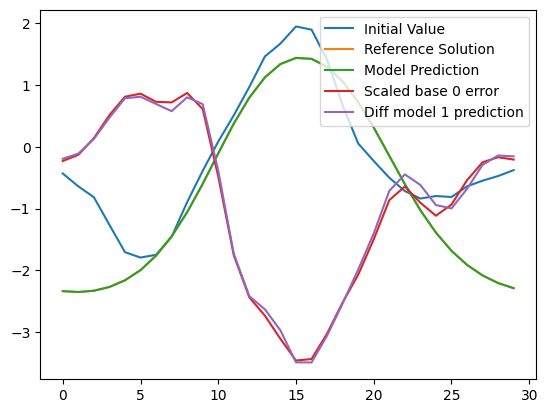

--------------------------------------RUN 23 --------------------------------------
Generated opt_params  15
0  :  3.245e-05
10  :  1.167e-05
20  :  1.012e-05
30  :  8.127e-06
40  :  6.641e-06
50  :  5.993e-06
60  :  5.392e-06
70  :  4.748e-06
80  :  4.451e-06
90  :  3.897e-06
100  :  3.558e-06
110  :  3.583e-06
120  :  3.537e-06
130  :  3.294e-06
140  :  3.086e-06
150  :  2.918e-06
160  :  2.872e-06
170  :  2.876e-06
180  :  2.587e-06
190  :  2.506e-06
200  :  2.334e-06
210  :  2.44e-06
220  :  2.217e-06
230  :  2.074e-06
240  :  1.994e-06
250  :  2.015e-06
260  :  1.854e-06
270  :  1.777e-06
280  :  1.773e-06
290  :  1.658e-06
300  :  1.633e-06
310  :  1.576e-06
320  :  1.625e-06
330  :  1.414e-06
340  :  1.539e-06
350  :  1.465e-06
360  :  1.359e-06
370  :  1.272e-06
380  :  1.255e-06
390  :  1.259e-06
400  :  1.208e-06
410  :  1.084e-06
420  :  1.137e-06
430  :  1.126e-06
440  :  1.089e-06
450  :  1.013e-06
460  :  9.635e-07
470  :  9.682e-07
480  :  9.735e-07
490  :  8.726e-07
500

2023-01-25 22:03:45.778615: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 22:03:46.156607: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 22:03:46.536199: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.012
10  :  0.7998
20  :  0.7464
30  :  0.6399
40  :  0.562
50  :  0.4141
60  :  0.3864
70  :  0.3225
80  :  0.3471
90  :  0.2967
100  :  0.2453
110  :  0.2502
120  :  0.205
130  :  0.1653
140  :  0.1363
150  :  0.1254
160  :  0.1086
170  :  0.1188
180  :  0.07007
190  :  0.06861
200  :  0.07252
210  :  0.08544
220  :  0.06652
230  :  0.06772
240  :  0.06315
250  :  0.05492
260  :  0.05032
270  :  0.05638
280  :  0.04227
290  :  0.04122
300  :  0.06358
310  :  0.04563
320  :  0.04164
330  :  0.02944
340  :  0.03527
350  :  0.07318
360  :  0.04601
370  :  0.0332
380  :  0.05138
390  :  0.02998
400  :  0.03012
410  :  0.02631
420  :  0.03416
430  :  0.03147
440  :  0.02734
450  :  0.02225
460  :  0.02968
470  :  0.02526
480  :  0.02624
490  :  0.02544
500  :  0.03016
510  :  0.02792
520  :  0.02571
530  :  0.0408
540  :  0.02778
550  :  0.02488
560  :  0.02413
570  :  0.02924
580  :  0.02195
590  :  0.01609
600  :  0.01775
610  :  0.02775
620  :  0.01952
630  :  0.01754
640  :  0.

--------------------------------------RUN 24 --------------------------------------
Generated opt_params  16
0  :  3.019e-05
10  :  1.158e-05
20  :  1.051e-05
30  :  8.227e-06
40  :  7.391e-06
50  :  6.362e-06
60  :  4.914e-06
70  :  4.87e-06
80  :  4.506e-06
90  :  4.317e-06
100  :  4.062e-06
110  :  3.608e-06
120  :  3.525e-06
130  :  3.375e-06
140  :  3.183e-06
150  :  2.954e-06
160  :  2.812e-06
170  :  2.762e-06
180  :  2.736e-06
190  :  2.569e-06
200  :  2.454e-06
210  :  2.496e-06
220  :  2.38e-06
230  :  2.266e-06
240  :  2.062e-06
250  :  2.063e-06
260  :  1.973e-06
270  :  1.978e-06
280  :  1.816e-06
290  :  1.88e-06
300  :  1.735e-06
310  :  1.641e-06
320  :  1.621e-06
330  :  1.638e-06
340  :  1.521e-06
350  :  1.473e-06
360  :  1.376e-06
370  :  1.453e-06
380  :  1.342e-06
390  :  1.275e-06
400  :  1.325e-06
410  :  1.184e-06
420  :  1.18e-06
430  :  1.171e-06
440  :  1.082e-06
450  :  1.111e-06
460  :  1.053e-06
470  :  1.128e-06
480  :  1.017e-06
490  :  1.05e-06
500  : 

2023-01-25 22:09:29.630094: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 22:09:30.003781: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 22:09:30.377634: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  0.98
10  :  0.8873
20  :  0.7825
30  :  0.8526
40  :  0.6195
50  :  0.495
60  :  0.3546
70  :  0.2844
80  :  0.2529
90  :  0.2359
100  :  0.1993
110  :  0.1343
120  :  0.201
130  :  0.1336
140  :  0.1155
150  :  0.09269
160  :  0.09056
170  :  0.07203
180  :  0.07583
190  :  0.09217
200  :  0.05801
210  :  0.05406
220  :  0.05509
230  :  0.09196
240  :  0.05892
250  :  0.05814
260  :  0.06082
270  :  0.0524
280  :  0.055
290  :  0.04625
300  :  0.03814
310  :  0.03629
320  :  0.04011
330  :  0.04067
340  :  0.04018
350  :  0.03089
360  :  0.04938
370  :  0.05241
380  :  0.04254
390  :  0.04238
400  :  0.04928
410  :  0.05151
420  :  0.03524
430  :  0.04123
440  :  0.02633
450  :  0.03566
460  :  0.03685
470  :  0.03014
480  :  0.0457
490  :  0.0339
500  :  0.03098
510  :  0.02458
520  :  0.02479
530  :  0.03913
540  :  0.05037
550  :  0.03092
560  :  0.02659
570  :  0.02712
580  :  0.02415
590  :  0.02286
600  :  0.02249
610  :  0.02273
620  :  0.09626
630  :  0.04058
640  :  0.0

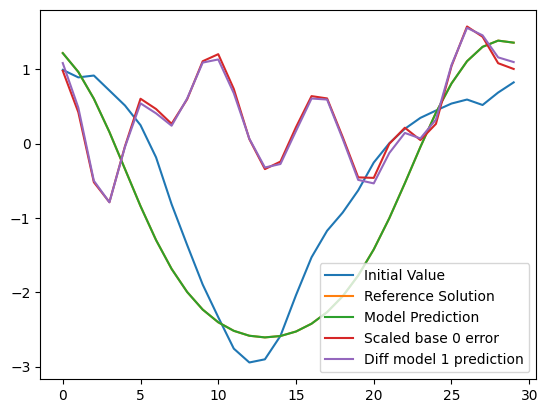

--------------------------------------RUN 25 --------------------------------------
Generated opt_params  17
0  :  4.559e-05
10  :  2.366e-05
20  :  1.962e-05
30  :  1.632e-05
40  :  1.566e-05
50  :  1.445e-05
60  :  1.329e-05
70  :  1.262e-05
80  :  1.176e-05
90  :  1.096e-05
100  :  1.052e-05
110  :  1.052e-05
120  :  1.021e-05
130  :  1.096e-05
140  :  1.053e-05
150  :  9.86e-06
160  :  9.203e-06
170  :  8.891e-06
180  :  8.663e-06
190  :  8.876e-06
200  :  8.492e-06
210  :  7.898e-06
220  :  7.726e-06
230  :  7.127e-06
240  :  7.175e-06
250  :  6.9e-06
260  :  7.361e-06
270  :  6.857e-06
280  :  6.893e-06
290  :  6.823e-06
300  :  6.41e-06
310  :  6.734e-06
320  :  5.988e-06
330  :  5.698e-06
340  :  6.474e-06
350  :  5.937e-06
360  :  5.684e-06
370  :  5.176e-06
380  :  5.686e-06
390  :  5.096e-06
400  :  5.083e-06
410  :  4.879e-06
420  :  4.739e-06
430  :  4.567e-06
440  :  4.638e-06
450  :  4.175e-06
460  :  4.333e-06
470  :  4.327e-06
480  :  4.494e-06
490  :  4.468e-06
500  :

2023-01-25 22:14:24.841263: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 22:14:25.216371: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 22:14:25.589815: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.039
10  :  0.9354
20  :  0.8596
30  :  0.4767
40  :  0.3492
50  :  0.2733
60  :  0.2103
70  :  0.16
80  :  0.1258
90  :  0.1272
100  :  0.1065
110  :  0.08946
120  :  0.0702
130  :  0.05212
140  :  0.04576
150  :  0.0514
160  :  0.07111
170  :  0.05351
180  :  0.05249
190  :  0.04329
200  :  0.04702
210  :  0.07223
220  :  0.05314
230  :  0.07787
240  :  0.08024
250  :  0.08114
260  :  0.07521
270  :  0.08872
280  :  0.1098
290  :  0.1303
300  :  0.08981
310  :  0.07945
320  :  0.08727
    New learning rate:  0.002
    New Batch size:  1024
330  :  0.06436
340  :  0.03643
350  :  0.03493
360  :  0.03572
370  :  0.02867
380  :  0.03002
390  :  0.1051
400  :  0.0247
410  :  0.02307
420  :  0.02247
430  :  0.0218
440  :  0.02334
450  :  0.02326
460  :  0.07256
470  :  0.02378
480  :  0.02396
490  :  0.01904
500  :  0.02261
510  :  0.02368
520  :  0.02291
530  :  0.1299
540  :  0.02058
550  :  0.0237
560  :  0.01934
570  :  0.01788
580  :  0.02646
590  :  0.01902
600  :  0.03191
61

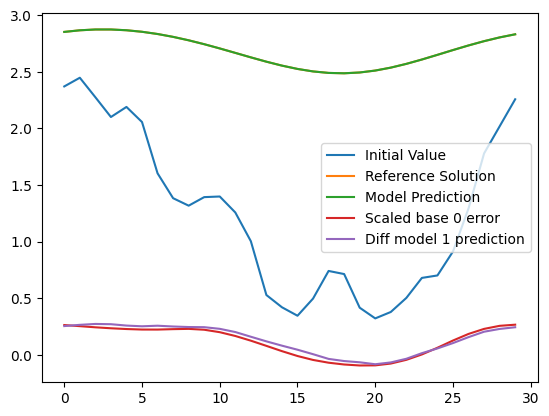

--------------------------------------RUN 26 --------------------------------------
Generated opt_params  18
0  :  2.989e-05
10  :  1.144e-05
20  :  9.572e-06
30  :  7.875e-06
40  :  6.859e-06
50  :  5.726e-06
60  :  5.16e-06
70  :  4.448e-06
80  :  4.155e-06
90  :  3.84e-06
100  :  3.386e-06
110  :  3.118e-06
120  :  3.038e-06
130  :  2.793e-06
140  :  2.658e-06
150  :  2.519e-06
160  :  2.329e-06
170  :  2.173e-06
180  :  2.078e-06
190  :  1.972e-06
200  :  1.915e-06
210  :  1.787e-06
220  :  1.5e-06
230  :  1.618e-06
240  :  1.452e-06
250  :  1.352e-06
260  :  1.272e-06
270  :  1.365e-06
280  :  1.167e-06
290  :  1.116e-06
300  :  1.102e-06
310  :  1.05e-06
320  :  9.669e-07
330  :  1.014e-06
340  :  9.35e-07
350  :  8.638e-07
360  :  8.987e-07
370  :  8.704e-07
380  :  9.022e-07
390  :  8.028e-07
400  :  8.321e-07
410  :  7.606e-07
420  :  7.663e-07
430  :  6.972e-07
440  :  6.851e-07
450  :  6.798e-07
460  :  6.697e-07
470  :  6.365e-07
480  :  6.808e-07
490  :  6.033e-07
500  :  

2023-01-25 22:20:36.982173: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 22:20:37.357360: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 22:20:37.731098: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.015
10  :  0.9153
20  :  0.792
30  :  0.8777
40  :  0.8031
50  :  0.653
60  :  0.6225
70  :  0.5922
80  :  0.5955
90  :  0.5003
100  :  0.3894
110  :  0.4375
120  :  0.4222
130  :  0.3476
140  :  0.3595
150  :  0.2711
160  :  0.2448
170  :  0.2953
180  :  0.2271
190  :  0.1746
200  :  0.1949
210  :  0.2018
220  :  0.1635
230  :  0.1717
240  :  0.1406
250  :  0.1666
260  :  0.1115
270  :  0.1216
280  :  0.1181
290  :  0.1157
300  :  0.09923
310  :  0.1509
320  :  0.1242
330  :  0.1263
340  :  0.1071
350  :  0.1129
360  :  0.09901
370  :  0.09654
380  :  0.108
390  :  0.1005
400  :  0.08978
410  :  0.08166
420  :  0.07464
430  :  0.0992
440  :  0.07915
450  :  0.06248
460  :  0.09911
470  :  0.2249
480  :  0.07071
490  :  0.0635
500  :  0.06032
510  :  0.08799
520  :  0.0681
530  :  0.07025
540  :  0.06204
550  :  0.07009
560  :  0.04892
570  :  0.1024
580  :  0.07498
590  :  0.05564
600  :  0.06005
610  :  0.05326
620  :  0.17
630  :  0.05402
640  :  0.06973
650  :  0.05311
660 

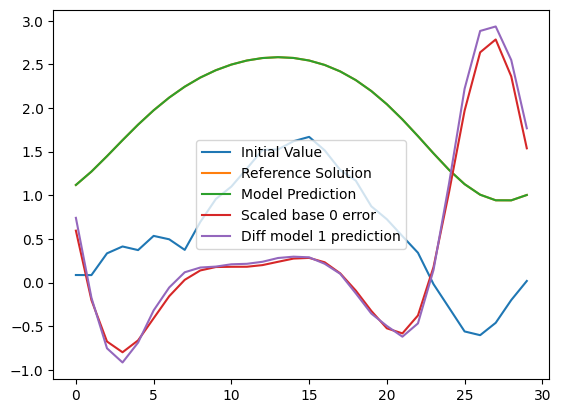

--------------------------------------RUN 27 --------------------------------------
Generated opt_params  19
0  :  2.905e-05
10  :  1.211e-05
20  :  9.875e-06
30  :  8.316e-06
40  :  6.93e-06
50  :  5.802e-06
60  :  4.848e-06
70  :  4.564e-06
80  :  4.364e-06
90  :  3.454e-06
100  :  3.672e-06
110  :  3.255e-06
120  :  2.891e-06
130  :  3.171e-06
140  :  2.781e-06
150  :  2.393e-06
160  :  2.338e-06
170  :  2.246e-06
180  :  2.275e-06
190  :  1.997e-06
200  :  1.687e-06
210  :  1.725e-06
220  :  1.605e-06
230  :  1.549e-06
240  :  1.47e-06
250  :  1.42e-06
260  :  1.432e-06
270  :  1.297e-06
280  :  1.274e-06
290  :  1.18e-06
300  :  1.141e-06
310  :  1.126e-06
320  :  1.017e-06
330  :  1.063e-06
340  :  1.093e-06
350  :  9.484e-07
360  :  8.79e-07
370  :  9.395e-07
380  :  8.523e-07
390  :  8.464e-07
400  :  8.985e-07
410  :  7.771e-07
420  :  7.992e-07
430  :  7.621e-07
440  :  7.633e-07
450  :  7.58e-07
460  :  7.601e-07
470  :  7.796e-07
480  :  6.978e-07
490  :  6.873e-07
500  :  

2023-01-25 22:27:06.826766: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 22:27:07.200650: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 22:27:07.574420: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.087
10  :  0.8603
20  :  0.8367
30  :  0.8111
40  :  0.7561
50  :  0.6313
60  :  0.5877
70  :  0.4959
80  :  0.4459
90  :  0.401
100  :  0.3668
110  :  0.3451
120  :  0.3841
130  :  0.289
140  :  0.2503
150  :  0.2342
160  :  0.1879
170  :  0.1741
180  :  0.1845
190  :  0.1981
200  :  0.2088
210  :  0.1337
220  :  0.1294
230  :  0.2442
240  :  0.1433
250  :  0.09727
260  :  0.1123
270  :  0.1199
280  :  0.09795
290  :  0.1028
300  :  0.1156
310  :  0.07352
320  :  0.08656
330  :  0.08563
340  :  0.0682
350  :  0.07524
360  :  0.08579
370  :  0.0875
380  :  0.08609
390  :  0.1054
400  :  0.09062
410  :  0.08583
420  :  0.1024
430  :  0.07664
440  :  0.07998
450  :  0.07502
460  :  0.06165
470  :  0.08746
480  :  0.05711
490  :  0.06322
500  :  0.06818
510  :  0.11
520  :  0.06389
530  :  0.09485
540  :  0.06817
550  :  0.06439
560  :  0.06689
570  :  0.05556
580  :  0.0599
590  :  0.05628
600  :  0.04796
610  :  0.1239
620  :  0.08339
630  :  0.04184
640  :  0.04579
650  :  0.04

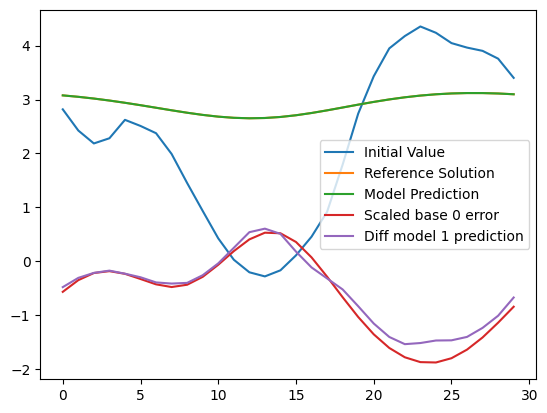

--------------------------------------RUN 28 --------------------------------------
Generated opt_params  20
0  :  3.111e-05
10  :  1.183e-05
20  :  9.814e-06
30  :  7.968e-06
40  :  6.731e-06
50  :  5.797e-06
60  :  5.269e-06
70  :  4.372e-06
80  :  4.211e-06
90  :  4.04e-06
100  :  3.504e-06
110  :  3.389e-06
120  :  3.311e-06
130  :  2.909e-06
140  :  2.883e-06
150  :  2.511e-06
160  :  2.363e-06
170  :  2.505e-06
180  :  2.193e-06
190  :  2.156e-06
200  :  1.903e-06
210  :  1.844e-06
220  :  1.713e-06
230  :  1.537e-06
240  :  1.505e-06
250  :  1.439e-06
260  :  1.416e-06
270  :  1.253e-06
280  :  1.442e-06
290  :  1.195e-06
300  :  1.187e-06
310  :  1.16e-06
320  :  1.08e-06
330  :  1.075e-06
340  :  1.079e-06
350  :  9.549e-07
360  :  9.271e-07
370  :  8.976e-07
380  :  8.586e-07
390  :  8.831e-07
400  :  8.344e-07
410  :  7.741e-07
420  :  8.085e-07
430  :  7.582e-07
440  :  7.321e-07
450  :  7.719e-07
460  :  7.411e-07
470  :  7.127e-07
480  :  6.995e-07
490  :  6.958e-07
500  

4310  :  7.319e-08
4320  :  7.475e-08
4330  :  7.466e-08
4340  :  7.498e-08
4350  :  7.829e-08
4360  :  7.443e-08
4370  :  7.523e-08
4380  :  7.139e-08
4390  :  7.362e-08
4400  :  7.649e-08
4410  :  7.363e-08
4420  :  7.522e-08
4430  :  7.604e-08
4440  :  7.458e-08
4450  :  7.985e-08
4460  :  7.524e-08
4470  :  7.91e-08
4480  :  7.542e-08
4490  :  7.54e-08
4500  :  6.962e-08
4510  :  7.32e-08
4520  :  7.581e-08
4530  :  7.648e-08
4540  :  7.583e-08
4550  :  7.018e-08
4560  :  7.633e-08
4570  :  7.748e-08
4580  :  7.277e-08
    New learning rate:  4e-08
    New Batch size:  2048
4590  :  7.117e-08
4600  :  7.638e-08
4610  :  7.019e-08
4620  :  7.71e-08
4630  :  7.397e-08
4640  :  7.205e-08
4650  :  7.26e-08
4660  :  7.437e-08
4670  :  6.934e-08
4680  :  7.242e-08
4690  :  7.294e-08
4700  :  7.274e-08
4710  :  7.18e-08
4720  :  7.625e-08
4730  :  7.475e-08
4740  :  7.29e-08
    New learning rate:  8e-09
4750  :  7.331e-08
4760  :  7.2e-08
4770  :  7.55e-08
4780  :  7.172e-08
4790  :  7.1

2023-01-25 22:34:26.256676: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 22:34:26.632140: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 22:34:27.009637: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.144
10  :  1.015
20  :  0.8327
30  :  1.156
40  :  0.6603
50  :  0.593
60  :  0.598
70  :  0.5665
80  :  0.5126
90  :  0.493
100  :  0.4688
110  :  0.4073
120  :  0.4329
130  :  0.3448
140  :  0.3246
150  :  0.2539
160  :  0.3863
170  :  0.2276
180  :  0.1603
190  :  0.1759
200  :  0.1511
210  :  0.1403
220  :  0.1193
230  :  0.1938
240  :  0.1187
250  :  0.5661
260  :  0.1036
270  :  0.09983
280  :  0.1261
290  :  0.1073
300  :  0.08676
310  :  0.07939
320  :  0.08889
330  :  0.09252
340  :  0.1263
350  :  0.08802
360  :  0.1048
370  :  0.09224
380  :  0.08166
390  :  0.1688
400  :  0.09888
410  :  0.09064
420  :  0.07057
430  :  0.0777
440  :  0.1402
450  :  0.07993
460  :  0.08282
470  :  0.1127
480  :  0.08032
490  :  0.07019
500  :  0.08203
510  :  0.06557
520  :  0.06079
530  :  0.05624
540  :  0.05556
550  :  0.05156
560  :  0.1214
570  :  0.06065
580  :  0.06392
590  :  0.05558
600  :  0.06347
610  :  0.104
620  :  0.1351
630  :  0.06082
640  :  0.07162
650  :  0.05012


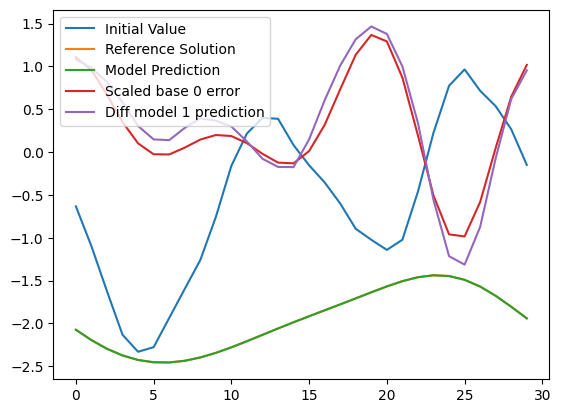

--------------------------------------RUN 29 --------------------------------------
Generated opt_params  21
0  :  2.961e-05
10  :  1.254e-05
20  :  9.407e-06
30  :  8.424e-06
40  :  6.804e-06
50  :  5.775e-06
60  :  5.358e-06
70  :  4.315e-06
80  :  3.927e-06
90  :  3.898e-06
100  :  3.645e-06
110  :  3.325e-06
120  :  3.094e-06
130  :  2.755e-06
140  :  2.735e-06
150  :  2.755e-06
160  :  2.394e-06
170  :  2.274e-06
180  :  2.21e-06
190  :  2.04e-06
200  :  1.928e-06
210  :  1.884e-06
220  :  1.772e-06
230  :  1.696e-06
240  :  1.677e-06
250  :  1.591e-06
260  :  1.422e-06
270  :  1.427e-06
280  :  1.355e-06
290  :  1.166e-06
300  :  1.146e-06
310  :  1.157e-06
320  :  1.136e-06
330  :  1.089e-06
340  :  1.058e-06
350  :  9.719e-07
360  :  9.769e-07
370  :  1.017e-06
380  :  8.973e-07
390  :  8.246e-07
400  :  8.715e-07
410  :  8.149e-07
420  :  8.458e-07
430  :  8.264e-07
440  :  8.347e-07
450  :  7.725e-07
460  :  7.81e-07
470  :  7.256e-07
480  :  7.234e-07
490  :  7.429e-07
500  

2023-01-25 22:40:04.342027: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 22:40:04.715838: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 22:40:05.089761: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.149
10  :  0.8235
20  :  0.7908
30  :  0.9142
40  :  0.7864
50  :  0.6787
60  :  0.5925
70  :  0.503
80  :  0.4301
90  :  0.3826
100  :  0.385
110  :  0.282
120  :  0.2967
130  :  0.3009
140  :  0.2884
150  :  0.2359
160  :  0.1704
170  :  0.1845
180  :  0.1511
190  :  0.1766
200  :  0.2361
210  :  0.1189
220  :  0.1154
230  :  0.1142
240  :  0.1007
250  :  0.09826
260  :  0.1222
270  :  0.1028
280  :  0.1073
290  :  0.09004
300  :  0.07391
310  :  0.08401
320  :  0.09763
330  :  0.08065
340  :  0.06214
350  :  0.07514
360  :  0.05986
370  :  0.05341
380  :  0.1016
390  :  0.06874
400  :  0.06569
410  :  0.07049
420  :  0.05452
430  :  0.1296
440  :  0.05668
450  :  0.06946
460  :  0.05969
470  :  0.05825
480  :  0.05311
490  :  0.07291
500  :  0.04636
510  :  0.09285
520  :  0.06026
530  :  0.05269
540  :  0.06397
550  :  0.05504
560  :  0.04736
570  :  0.05015
580  :  0.04385
590  :  0.04165
600  :  0.04929
610  :  0.06931
620  :  0.06517
630  :  0.04708
640  :  0.04105
650  

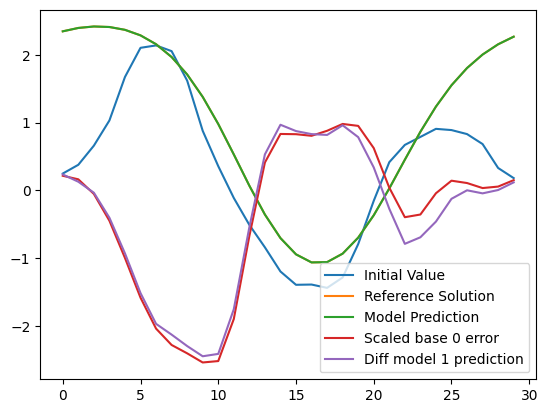

--------------------------------------RUN 30 --------------------------------------
Generated opt_params  22
0  :  3.076e-05
10  :  1.137e-05
20  :  1.042e-05
30  :  7.738e-06
40  :  7.009e-06
50  :  6.145e-06
60  :  4.963e-06
70  :  4.722e-06
80  :  4.425e-06
90  :  3.996e-06
100  :  3.774e-06
110  :  3.653e-06
120  :  3.547e-06
130  :  3.328e-06
140  :  2.911e-06
150  :  2.869e-06
160  :  2.748e-06
170  :  2.815e-06
180  :  2.596e-06
190  :  2.47e-06
200  :  2.375e-06
210  :  2.274e-06
220  :  2.181e-06
230  :  1.969e-06
240  :  1.937e-06
250  :  1.858e-06
260  :  1.781e-06
270  :  1.658e-06
280  :  1.651e-06
290  :  1.678e-06
300  :  1.616e-06
310  :  1.513e-06
320  :  1.334e-06
330  :  1.327e-06
340  :  1.267e-06
350  :  1.155e-06
360  :  1.24e-06
370  :  1.107e-06
380  :  1.045e-06
390  :  1.101e-06
400  :  1.015e-06
410  :  1.007e-06
420  :  9.777e-07
430  :  9.626e-07
440  :  9.797e-07
450  :  8.691e-07
460  :  9.191e-07
470  :  8.164e-07
480  :  7.963e-07
490  :  7.887e-07
500 

2023-01-25 22:45:12.296411: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 22:45:12.669241: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 22:45:13.049568: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.063
10  :  0.8122
20  :  0.7486
30  :  0.7139
40  :  0.6651
50  :  0.5003
60  :  0.4366
70  :  0.3487
80  :  0.356
90  :  0.3354
100  :  0.2425
110  :  0.2349
120  :  0.1989
130  :  0.1638
140  :  0.1721
150  :  0.1381
160  :  0.1067
170  :  0.1067
180  :  0.1141
190  :  0.09274
200  :  0.0776
210  :  0.07639
220  :  0.2023
230  :  0.07553
240  :  0.08963
250  :  0.07075
260  :  0.05811
270  :  0.064
280  :  0.0685
290  :  0.06027
300  :  0.05438
310  :  0.04555
320  :  0.05616
330  :  0.06024
340  :  0.04242
350  :  0.04877
360  :  0.04676
370  :  0.05438
380  :  0.03853
390  :  0.04338
400  :  0.04554
410  :  0.04702
420  :  0.04211
430  :  0.0393
440  :  0.03979
450  :  0.04025
460  :  0.03472
470  :  0.04188
480  :  0.03059
490  :  0.03863
500  :  0.04399
510  :  0.03399
520  :  0.02704
530  :  0.03203
540  :  0.02818
550  :  0.02694
560  :  0.05527
570  :  0.02649
580  :  0.07294
590  :  0.02602
600  :  0.02723
610  :  0.02757
620  :  0.03241
630  :  0.03222
640  :  0.0287

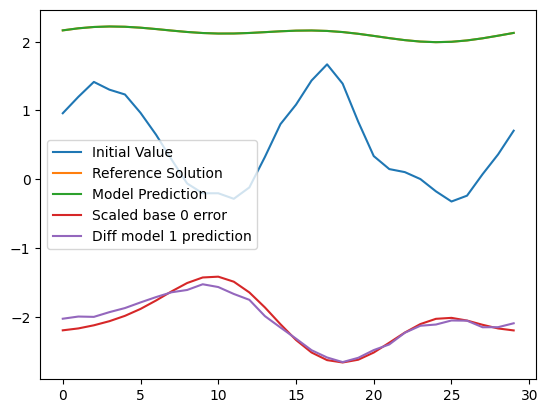

--------------------------------------RUN 31 --------------------------------------
Generated opt_params  23
0  :  3.385e-05
10  :  1.292e-05
20  :  1.136e-05
30  :  8.177e-06
40  :  7.176e-06
50  :  6.131e-06
60  :  5.694e-06
70  :  5.064e-06
80  :  4.796e-06
90  :  4.924e-06
100  :  4.225e-06
110  :  4.035e-06
120  :  3.924e-06
130  :  4.085e-06
140  :  3.558e-06
150  :  3.265e-06
160  :  3.19e-06
170  :  2.92e-06
180  :  2.899e-06
190  :  2.871e-06
200  :  2.7e-06
210  :  2.631e-06
220  :  2.336e-06
230  :  2.452e-06
240  :  2.496e-06
250  :  2.027e-06
260  :  2.024e-06
270  :  1.966e-06
280  :  2.078e-06
290  :  1.95e-06
300  :  1.744e-06
310  :  1.767e-06
320  :  1.618e-06
330  :  1.535e-06
340  :  1.42e-06
350  :  1.396e-06
360  :  1.52e-06
370  :  1.358e-06
380  :  1.279e-06
390  :  1.261e-06
400  :  1.256e-06
410  :  1.228e-06
420  :  1.123e-06
430  :  1.128e-06
440  :  1.12e-06
450  :  1.046e-06
460  :  1.001e-06
470  :  9.742e-07
480  :  1.003e-06
490  :  9.876e-07
500  :  9.

4310  :  9.09e-08
4320  :  8.689e-08
4330  :  9.096e-08
4340  :  9.162e-08
4350  :  9.001e-08
4360  :  8.574e-08
4370  :  8.851e-08
4380  :  9.038e-08
4390  :  9.211e-08
4400  :  9.19e-08
4410  :  8.798e-08
4420  :  8.938e-08
4430  :  9.485e-08
4440  :  9.514e-08
4450  :  8.956e-08
4460  :  8.943e-08
4470  :  8.982e-08
4480  :  9.454e-08
4490  :  8.95e-08
4500  :  8.909e-08
4510  :  8.955e-08
4520  :  9.444e-08
    New learning rate:  4e-08
    New Batch size:  2048
4530  :  9.075e-08
4540  :  8.888e-08
4550  :  8.975e-08
4560  :  8.929e-08
4570  :  8.94e-08
4580  :  8.88e-08
4590  :  8.99e-08
4600  :  9.053e-08
4610  :  8.887e-08
4620  :  8.877e-08
4630  :  8.661e-08
4640  :  9.012e-08
4650  :  9.19e-08
Training ended due to inssuficient improvement
------ TRAINING BASE------
------ TRAINING DIFF 0 ------
Est. L2-error:  0.0002921179578589905


2023-01-25 22:52:42.393807: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 22:52:42.768094: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 22:52:43.143055: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.018
10  :  0.9626
20  :  0.9221
30  :  0.7989
40  :  0.5824
50  :  0.5138
60  :  0.4273
70  :  0.4131
80  :  0.329
90  :  0.3451
100  :  0.2667
110  :  0.2458
120  :  0.2618
130  :  0.1556
140  :  0.1449
150  :  0.1578
160  :  0.187
170  :  0.1949
180  :  0.1333
190  :  0.1269
200  :  0.1266
210  :  0.1433
220  :  0.1299
230  :  0.09118
240  :  0.1178
250  :  0.1159
260  :  0.07834
270  :  0.07017
280  :  0.06747
290  :  0.06943
300  :  0.06853
310  :  0.07164
320  :  0.07343
330  :  0.06355
340  :  0.0725
350  :  0.08898
360  :  0.0798
370  :  0.05879
380  :  0.05468
390  :  0.06048
400  :  0.06453
410  :  0.1104
420  :  0.07243
430  :  0.057
440  :  0.09442
450  :  0.04894
460  :  0.06452
470  :  0.0431
480  :  0.05159
490  :  0.05316
500  :  0.0438
510  :  0.05977
520  :  0.05892
530  :  0.06615
540  :  0.0965
550  :  0.07332
560  :  0.04485
570  :  0.06018
580  :  0.05825
590  :  0.06006
600  :  0.04741
610  :  0.04433
620  :  0.03853
630  :  0.04468
640  :  0.09933
650  : 

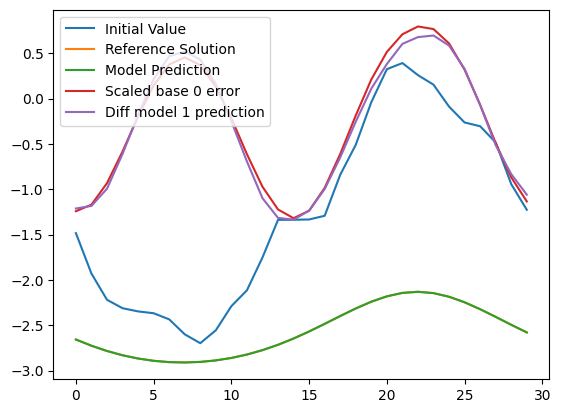

--------------------------------------RUN 32 --------------------------------------
Generated opt_params  24
0  :  3.664e-05
10  :  1.538e-05
20  :  1.245e-05
30  :  1.079e-05
40  :  9.933e-06
50  :  9.373e-06
60  :  8.089e-06
70  :  7.213e-06
80  :  6.98e-06
90  :  6.607e-06
100  :  5.755e-06
110  :  5.834e-06
120  :  5.428e-06
130  :  5.126e-06
140  :  4.908e-06
150  :  4.796e-06
160  :  4.711e-06
170  :  4.93e-06
180  :  4.499e-06
190  :  4.316e-06
200  :  4.411e-06
210  :  4.26e-06
220  :  4.045e-06
230  :  3.938e-06
240  :  3.739e-06
250  :  3.549e-06
260  :  3.672e-06
270  :  3.356e-06
280  :  3.043e-06
290  :  3.002e-06
300  :  3.152e-06
310  :  2.858e-06
320  :  2.73e-06
330  :  2.911e-06
340  :  2.788e-06
350  :  2.849e-06
360  :  2.656e-06
370  :  2.738e-06
380  :  2.242e-06
390  :  2.344e-06
400  :  2.236e-06
410  :  2.204e-06
420  :  2.268e-06
430  :  2.166e-06
440  :  2.018e-06
450  :  1.976e-06
460  :  1.935e-06
470  :  1.803e-06
480  :  1.811e-06
490  :  1.792e-06
500  :

2023-01-25 22:58:04.549573: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 22:58:04.924496: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 22:58:05.300896: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.007
10  :  0.9628
20  :  0.8168
30  :  0.6945
40  :  0.5556
50  :  0.402
60  :  0.3015
70  :  0.2643
80  :  0.2242
90  :  0.2411
100  :  0.1549
110  :  0.1438
120  :  0.1077
130  :  0.1159
140  :  0.08327
150  :  0.09216
160  :  0.06944
170  :  0.06688
180  :  0.07069
190  :  0.08168
200  :  0.05682
210  :  0.05051
220  :  0.06142
230  :  0.04979
240  :  0.06017
250  :  0.0605
260  :  0.09036
270  :  0.0554
280  :  0.05047
290  :  0.04137
300  :  0.05002
310  :  0.047
320  :  0.05687
330  :  0.04955
340  :  0.04028
350  :  0.04513
360  :  0.03757
370  :  0.04612
380  :  0.05204
390  :  0.03768
400  :  0.03647
410  :  0.04928
420  :  0.03816
430  :  0.02957
440  :  0.0462
450  :  0.0249
460  :  0.03432
470  :  0.02784
480  :  0.02335
490  :  0.03302
500  :  0.02471
510  :  0.02547
520  :  0.02135
530  :  0.03227
540  :  0.03235
550  :  0.02668
560  :  0.0456
570  :  0.03435
580  :  0.0299
590  :  0.02595
600  :  0.02686
610  :  0.02285
620  :  0.05779
630  :  0.0307
640  :  0.02

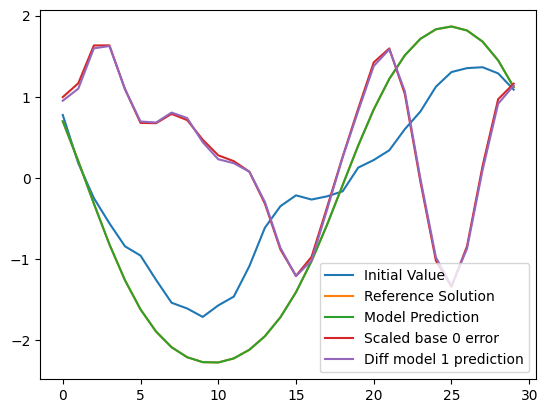

--------------------------------------RUN 33 --------------------------------------
Generated opt_params  25
0  :  3.959e-05
10  :  2.141e-05
20  :  1.806e-05
30  :  1.668e-05
40  :  1.404e-05
50  :  1.353e-05
60  :  1.219e-05
70  :  1.095e-05
80  :  1.091e-05
90  :  1.046e-05
100  :  1.003e-05
110  :  1.027e-05
120  :  9.109e-06
130  :  9.127e-06
140  :  9.127e-06
150  :  7.601e-06
160  :  8.762e-06
170  :  8.1e-06
180  :  8.233e-06
190  :  7.492e-06
200  :  7.515e-06
210  :  7.417e-06
220  :  6.833e-06
230  :  7.347e-06
240  :  6.635e-06
250  :  6.826e-06
260  :  6.585e-06
270  :  6.117e-06
280  :  6.456e-06
290  :  6.419e-06
300  :  5.773e-06
310  :  5.337e-06
320  :  5.114e-06
330  :  5.307e-06
340  :  5.492e-06
350  :  5.356e-06
360  :  5.234e-06
370  :  4.971e-06
380  :  4.702e-06
390  :  4.686e-06
400  :  4.317e-06
410  :  4.173e-06
420  :  4.399e-06
430  :  4.538e-06
440  :  3.803e-06
450  :  4.03e-06
460  :  3.873e-06
470  :  3.425e-06
480  :  3.745e-06
490  :  3.602e-06
500  

2023-01-25 23:02:14.608050: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 23:02:14.982708: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 23:02:15.372951: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.065
10  :  0.8865
20  :  0.612
30  :  0.5098
40  :  0.3381
50  :  0.2316
60  :  0.1634
70  :  0.1304
80  :  0.121
90  :  0.09832
100  :  0.09878
110  :  0.1016
120  :  0.06297
130  :  0.0673
140  :  0.0594
150  :  0.066
160  :  0.05869
170  :  0.06296
180  :  0.05549
190  :  0.07051
200  :  0.05509
210  :  0.05219
220  :  0.04958
230  :  0.04711
240  :  0.04867
250  :  0.05076
260  :  0.04346
270  :  0.03732
280  :  0.03403
290  :  0.05497
300  :  0.0317
310  :  0.07696
320  :  0.03658
330  :  0.02621
340  :  0.02904
350  :  0.03267
360  :  0.1054
370  :  0.02413
380  :  0.02794
390  :  0.09691
400  :  0.04386
410  :  0.04274
420  :  0.03186
430  :  0.03032
440  :  0.024
450  :  0.02018
460  :  0.01999
470  :  0.02706
480  :  0.03394
490  :  0.0243
500  :  0.05651
510  :  0.04019
520  :  0.03193
530  :  0.02656
540  :  0.02771
550  :  0.02303
560  :  0.02076
570  :  0.02156
580  :  0.02148
590  :  0.04173
600  :  0.01588
610  :  0.02008
620  :  0.02442
630  :  0.0186
640  :  0.

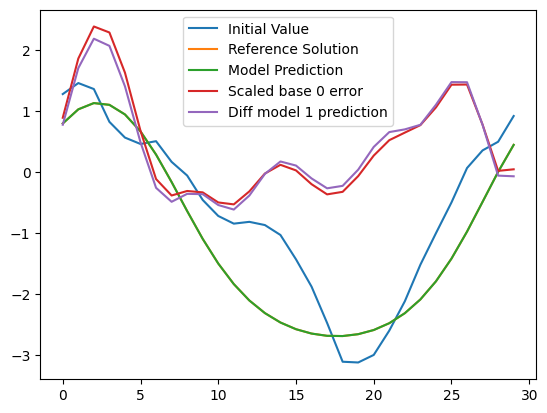

--------------------------------------RUN 34 --------------------------------------
Generated opt_params  26
0  :  3.097e-05
10  :  1.135e-05
20  :  9.78e-06
30  :  7.998e-06
40  :  7.516e-06
50  :  6.012e-06
60  :  5.477e-06
70  :  4.996e-06
80  :  4.579e-06
90  :  4.456e-06
100  :  3.943e-06
110  :  3.754e-06
120  :  3.39e-06
130  :  3.551e-06
140  :  3.092e-06
150  :  3.064e-06
160  :  3.236e-06
170  :  2.668e-06
180  :  2.813e-06
190  :  2.581e-06
200  :  2.589e-06
210  :  2.322e-06
220  :  2.296e-06
230  :  2.324e-06
240  :  2.021e-06
250  :  2.11e-06
260  :  1.992e-06
270  :  1.956e-06
280  :  1.674e-06
290  :  1.732e-06
300  :  1.76e-06
310  :  1.54e-06
320  :  1.676e-06
330  :  1.586e-06
340  :  1.425e-06
350  :  1.35e-06
360  :  1.393e-06
370  :  1.274e-06
380  :  1.219e-06
390  :  1.218e-06
400  :  1.205e-06
410  :  1.128e-06
420  :  1.136e-06
430  :  1.134e-06
440  :  1.088e-06
450  :  1.042e-06
460  :  9.261e-07
470  :  8.882e-07
480  :  9.789e-07
490  :  9.569e-07
500  :  

2023-01-25 23:07:14.373749: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 23:07:14.745880: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 23:07:15.124952: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.087
10  :  0.8176
20  :  0.7622
30  :  0.6235
40  :  0.5141
50  :  0.3788
60  :  0.3822
70  :  0.3091
80  :  0.2864
90  :  0.2139
100  :  0.2184
110  :  0.1809
120  :  0.1631
130  :  0.1552
140  :  0.1441
150  :  0.1495
160  :  0.112
170  :  0.1337
180  :  0.08487
190  :  0.07963
200  :  0.0955
210  :  0.08649
220  :  0.09107
230  :  0.1336
240  :  0.08384
250  :  0.09387
260  :  0.07917
270  :  0.0635
280  :  0.05437
290  :  0.05819
300  :  0.07564
310  :  0.04786
320  :  0.06096
330  :  0.04526
340  :  0.04301
350  :  0.04875
360  :  0.0409
370  :  0.03961
380  :  0.03449
390  :  0.03525
400  :  0.03912
410  :  0.03108
420  :  0.03398
430  :  0.03039
440  :  0.0393
450  :  0.03153
460  :  0.03068
470  :  0.03351
480  :  0.05184
490  :  0.03005
500  :  0.03725
510  :  0.03104
520  :  0.02706
530  :  0.0844
540  :  0.0225
550  :  0.04435
560  :  0.02184
570  :  0.02808
580  :  0.03567
590  :  0.02697
600  :  0.03748
610  :  0.0311
620  :  0.02639
630  :  0.01952
640  :  0.02475

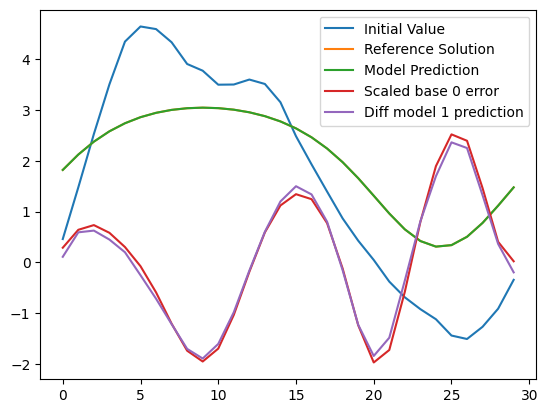

--------------------------------------RUN 35 --------------------------------------
Generated opt_params  27
0  :  4.331e-05
10  :  2.228e-05
20  :  1.829e-05
30  :  1.617e-05
40  :  1.498e-05
50  :  1.439e-05
60  :  1.32e-05
70  :  1.248e-05
80  :  1.224e-05
90  :  1.196e-05
100  :  1.055e-05
110  :  1.003e-05
120  :  1.075e-05
130  :  9.686e-06
140  :  1.082e-05
150  :  1.008e-05
160  :  9.357e-06
170  :  8.268e-06
180  :  8.978e-06
190  :  8.491e-06
200  :  7.984e-06
210  :  8.195e-06
220  :  7.954e-06
230  :  7.71e-06
240  :  7.364e-06
250  :  7.833e-06
260  :  7.21e-06
270  :  6.609e-06
280  :  6.01e-06
290  :  6.513e-06
300  :  6.172e-06
310  :  5.657e-06
320  :  5.73e-06
330  :  5.515e-06
340  :  5.788e-06
350  :  5.421e-06
360  :  5.072e-06
370  :  5.363e-06
380  :  5.373e-06
390  :  4.91e-06
400  :  4.906e-06
410  :  4.737e-06
420  :  4.96e-06
430  :  4.246e-06
440  :  4.952e-06
450  :  4.31e-06
460  :  3.967e-06
470  :  4.163e-06
480  :  4.21e-06
490  :  4.077e-06
500  :  3.9

2023-01-25 23:11:55.804410: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 23:11:56.185186: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 23:11:56.559149: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  0.9614
10  :  1.046
20  :  0.8238
30  :  0.5132
40  :  0.3752
50  :  0.2565
60  :  0.2189
70  :  0.1713
80  :  0.1253
90  :  0.1027
100  :  0.1071
110  :  0.09742
120  :  0.08969
130  :  0.07561
140  :  0.4022
150  :  0.06128
160  :  0.054
170  :  0.06321
180  :  0.05186
190  :  0.05369
200  :  0.0653
210  :  0.1142
220  :  0.05228
230  :  0.06636
240  :  0.07024
250  :  0.09648
260  :  0.1021
270  :  0.1176
280  :  0.1126
290  :  0.101
300  :  0.08331
310  :  0.06274
320  :  0.03909
330  :  0.03486
340  :  0.04664
350  :  0.04438
360  :  0.03747
370  :  0.03003
380  :  0.04414
390  :  0.03814
400  :  0.03392
410  :  0.04202
420  :  0.03652
430  :  0.03151
440  :  0.03429
450  :  0.02537
460  :  0.03364
470  :  0.03041
480  :  0.02668
490  :  0.02554
500  :  0.0246
510  :  0.02002
520  :  0.02461
530  :  0.02869
540  :  0.0248
550  :  0.02373
560  :  0.0172
570  :  0.01781
580  :  0.0248
590  :  0.02084
600  :  0.01993
610  :  0.02072
620  :  0.02039
630  :  0.03664
640  :  0.026

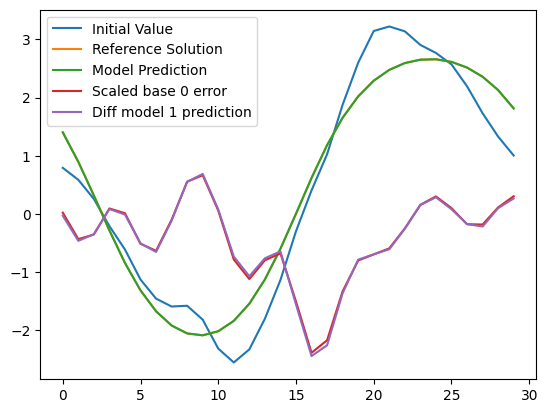

--------------------------------------RUN 36 --------------------------------------
Generated opt_params  28
0  :  4.001e-05
10  :  2.124e-05
20  :  1.556e-05
30  :  1.419e-05
40  :  1.224e-05
50  :  1.142e-05
60  :  1.056e-05
70  :  9.424e-06
80  :  8.839e-06
90  :  9.02e-06
100  :  8.094e-06
110  :  7.449e-06
120  :  7.51e-06
130  :  7.118e-06
140  :  7.163e-06
150  :  6.523e-06
160  :  6.335e-06
170  :  6.359e-06
180  :  5.564e-06
190  :  5.535e-06
200  :  5.319e-06
210  :  5.112e-06
220  :  4.871e-06
230  :  4.449e-06
240  :  4.117e-06
250  :  4.312e-06
260  :  3.979e-06
270  :  4.084e-06
280  :  3.548e-06
290  :  3.375e-06
300  :  3.463e-06
310  :  3.388e-06
320  :  3.123e-06
330  :  2.942e-06
340  :  2.904e-06
350  :  2.891e-06
360  :  2.545e-06
370  :  2.75e-06
380  :  2.582e-06
390  :  2.525e-06
400  :  2.332e-06
410  :  2.174e-06
420  :  2.047e-06
430  :  2.085e-06
440  :  2.12e-06
450  :  2.071e-06
460  :  1.994e-06
470  :  2.014e-06
480  :  2.055e-06
490  :  1.728e-06
500  :

2023-01-25 23:17:01.450217: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 23:17:01.824344: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 23:17:02.199997: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.011
10  :  0.8652
20  :  0.8319
30  :  0.675
40  :  0.4683
50  :  0.4023
60  :  0.3067
70  :  0.2731
80  :  0.4201
90  :  0.2139
100  :  0.1546
110  :  0.1184
120  :  0.1099
130  :  0.09876
140  :  0.08068
150  :  0.1148
160  :  0.1246
170  :  0.603
180  :  0.0865
190  :  0.07652
200  :  0.06038
210  :  0.07438
220  :  1.551
230  :  0.08428
240  :  0.07929
250  :  0.07211
260  :  0.07302
270  :  0.06182
280  :  0.06202
290  :  0.06115
300  :  0.05069
310  :  0.04278
320  :  0.09019
330  :  0.05743
340  :  0.05308
350  :  0.04766
360  :  0.05642
370  :  0.0484
380  :  0.03891
390  :  0.03578
400  :  0.03529
410  :  0.03145
420  :  0.03248
430  :  0.03393
440  :  0.03137
450  :  0.02597
460  :  0.02518
470  :  0.02502
480  :  0.0364
490  :  0.07151
500  :  0.04748
510  :  0.05005
520  :  0.03314
530  :  0.07013
540  :  0.03476
550  :  0.0392
560  :  0.0269
570  :  0.02307
580  :  0.02325
590  :  0.03107
600  :  0.0291
610  :  0.0264
620  :  0.03264
630  :  0.0246
640  :  0.0333
6

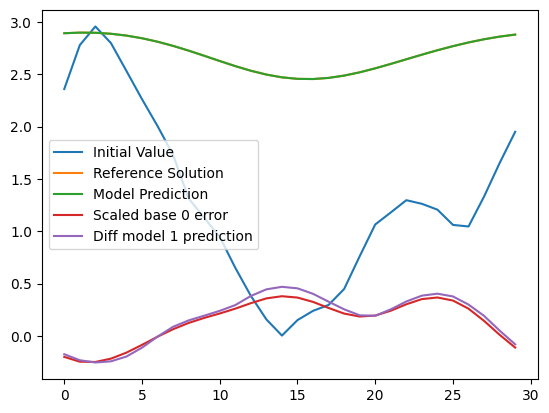

--------------------------------------RUN 37 --------------------------------------
Generated opt_params  29
0  :  3.245e-05
10  :  1.484e-05
20  :  1.293e-05
30  :  1.044e-05
40  :  9.222e-06
50  :  8.124e-06
60  :  7.125e-06
70  :  6.979e-06
80  :  6.605e-06
90  :  6.293e-06
100  :  5.851e-06
110  :  5.149e-06
120  :  5.351e-06
130  :  4.764e-06
140  :  4.808e-06
150  :  4.518e-06
160  :  3.999e-06
170  :  4.151e-06
180  :  4.218e-06
190  :  3.819e-06
200  :  3.511e-06
210  :  3.359e-06
220  :  3.459e-06
230  :  3.201e-06
240  :  3.104e-06
250  :  2.8e-06
260  :  2.791e-06
270  :  2.492e-06
280  :  2.559e-06
290  :  2.531e-06
300  :  2.279e-06
310  :  2.229e-06
320  :  2.107e-06
330  :  2.045e-06
340  :  2.08e-06
350  :  2.088e-06
360  :  1.773e-06
370  :  1.762e-06
380  :  1.916e-06
390  :  1.746e-06
400  :  1.749e-06
410  :  1.582e-06
420  :  1.542e-06
430  :  1.552e-06
440  :  1.477e-06
450  :  1.376e-06
460  :  1.286e-06
470  :  1.219e-06
480  :  1.278e-06
490  :  1.327e-06
500  

2023-01-25 23:21:47.266048: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 23:21:47.639430: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 23:21:48.013116: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.053
10  :  1.009
20  :  0.7706
30  :  0.8233
40  :  0.4673
50  :  0.3382
60  :  0.3188
70  :  0.2456
80  :  0.1883
90  :  0.1621
100  :  0.1466
110  :  0.1106
120  :  0.09631
130  :  0.1367
140  :  0.1666
150  :  0.1137
160  :  0.07806
170  :  0.07906
180  :  0.07627
190  :  0.06368
200  :  0.054
210  :  0.07238
220  :  0.06546
230  :  0.09555
240  :  0.08479
250  :  0.09118
260  :  0.1108
270  :  0.09682
280  :  0.09228
290  :  0.08847
300  :  0.08527
310  :  0.07544
320  :  0.06206
330  :  0.06251
    New learning rate:  0.002
    New Batch size:  1024
340  :  0.05619
350  :  0.05201
360  :  0.04789
370  :  0.03663
380  :  0.0525
390  :  0.05396
400  :  0.04246
410  :  0.04009
420  :  0.03445
430  :  0.03506
440  :  0.03745
450  :  0.03265
460  :  0.0427
470  :  0.03876
480  :  0.03108
490  :  0.5426
500  :  0.03941
510  :  0.02837
520  :  0.02813
530  :  0.05618
540  :  0.04196
550  :  0.03404
560  :  0.02542
570  :  0.03347
580  :  0.03015
590  :  0.02284
600  :  0.02559
61

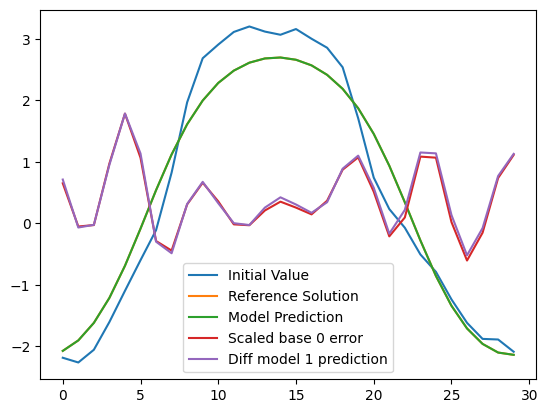

--------------------------------------RUN 38 --------------------------------------
Generated opt_params  30
0  :  4.047e-05
10  :  1.943e-05
20  :  1.684e-05
30  :  1.464e-05
40  :  1.305e-05
50  :  1.12e-05
60  :  1.187e-05
70  :  1.037e-05
80  :  1.003e-05
90  :  9.238e-06
100  :  8.858e-06
110  :  8.973e-06
120  :  7.961e-06
130  :  8.46e-06
140  :  8.091e-06
150  :  7.571e-06
160  :  7.465e-06
170  :  7.429e-06
180  :  7.117e-06
190  :  7.073e-06
200  :  6.267e-06
210  :  5.97e-06
220  :  6.319e-06
230  :  6.255e-06
240  :  6.031e-06
250  :  5.056e-06
260  :  5.287e-06
270  :  5.137e-06
280  :  5.022e-06
290  :  5.167e-06
300  :  4.464e-06
310  :  4.424e-06
320  :  4.55e-06
330  :  4.192e-06
340  :  4.213e-06
350  :  4.035e-06
360  :  3.922e-06
370  :  4.14e-06
380  :  4.206e-06
390  :  3.756e-06
400  :  3.805e-06
410  :  3.695e-06
420  :  3.017e-06
430  :  4.329e-06
440  :  3.322e-06
450  :  3.114e-06
460  :  3.204e-06
470  :  2.756e-06
480  :  2.825e-06
490  :  2.881e-06
500  : 

2023-01-25 23:26:35.701213: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 23:26:36.083246: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 23:26:36.457754: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.025
10  :  0.9615
20  :  0.8774
30  :  0.6018
40  :  0.4147
50  :  0.3274
60  :  0.2631
70  :  0.2227
80  :  0.2045
90  :  0.1456
100  :  0.1324
110  :  0.1291
120  :  0.09424
130  :  0.07997
140  :  0.08262
150  :  0.102
160  :  0.09465
170  :  0.07325
180  :  0.0671
190  :  0.05647
200  :  0.04876
210  :  0.06178
220  :  0.05499
230  :  0.05708
240  :  0.06983
250  :  0.06678
260  :  0.0811
270  :  0.07565
280  :  0.06161
290  :  0.09735
300  :  0.08048
310  :  0.0921
320  :  0.08467
    New learning rate:  0.002
    New Batch size:  1024
330  :  0.07877
340  :  0.04852
350  :  0.04406
360  :  0.03838
370  :  0.03601
380  :  0.05053
390  :  0.03334
400  :  0.0287
410  :  0.03156
420  :  0.03151
430  :  0.03133
440  :  0.03567
450  :  0.02955
460  :  0.0292
470  :  0.02741
480  :  0.02927
490  :  0.03758
500  :  0.03042
510  :  0.03151
520  :  0.02486
530  :  0.02925
540  :  0.02556
550  :  0.02349
560  :  0.0267
570  :  0.03335
580  :  0.02738
590  :  0.0332
600  :  0.0227
61

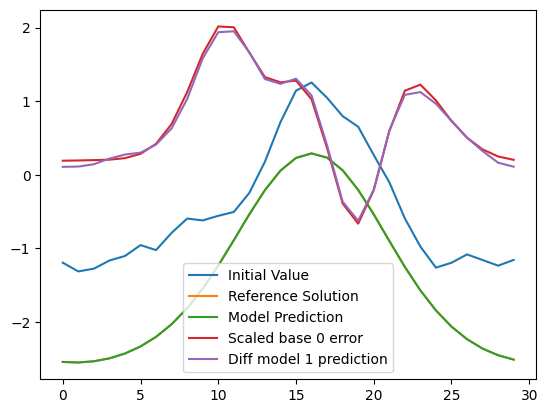

--------------------------------------RUN 39 --------------------------------------
Generated opt_params  31
0  :  2.891e-05
10  :  1.132e-05
20  :  9.985e-06
30  :  8.108e-06
40  :  6.995e-06
50  :  5.693e-06
60  :  5.439e-06
70  :  4.964e-06
80  :  4.415e-06
90  :  4.263e-06
100  :  3.882e-06
110  :  3.704e-06
120  :  3.31e-06
130  :  3.408e-06
140  :  3.423e-06
150  :  2.898e-06
160  :  2.906e-06
170  :  2.713e-06
180  :  2.659e-06
190  :  2.469e-06
200  :  2.642e-06
210  :  2.243e-06
220  :  2.064e-06
230  :  2.147e-06
240  :  2.068e-06
250  :  1.885e-06
260  :  1.945e-06
270  :  1.744e-06
280  :  1.732e-06
290  :  1.692e-06
300  :  1.699e-06
310  :  1.55e-06
320  :  1.548e-06
330  :  1.474e-06
340  :  1.451e-06
350  :  1.358e-06
360  :  1.284e-06
370  :  1.188e-06
380  :  1.107e-06
390  :  1.213e-06
400  :  1.128e-06
410  :  1.137e-06
420  :  1.074e-06
430  :  1.103e-06
440  :  1.076e-06
450  :  9.517e-07
460  :  9.172e-07
470  :  9.61e-07
480  :  9.491e-07
490  :  9.22e-07
500  :

2023-01-25 23:32:29.176575: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 23:32:29.551645: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 23:32:29.925715: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.08
10  :  0.8285
20  :  0.7273
30  :  0.667
40  :  0.587
50  :  0.4206
60  :  0.3704
70  :  0.3268
80  :  0.2891
90  :  0.2766
100  :  0.2576
110  :  0.25
120  :  0.2604
130  :  0.1784
140  :  0.1618
150  :  0.1435
160  :  0.124
170  :  0.1927
180  :  0.1012
190  :  0.1197
200  :  0.09996
210  :  0.1033
220  :  0.1166
230  :  0.1412
240  :  0.1082
250  :  0.1004
260  :  0.08867
270  :  0.07479
280  :  0.08698
290  :  0.06997
300  :  0.07476
310  :  0.06196
320  :  0.05699
330  :  0.06224
340  :  0.06587
350  :  0.05275
360  :  0.08199
370  :  0.0523
380  :  0.05054
390  :  0.05506
400  :  0.06042
410  :  0.03979
420  :  0.04143
430  :  0.03771
440  :  0.03977
450  :  0.03314
460  :  0.03796
470  :  0.04713
480  :  0.03724
490  :  0.0517
500  :  0.05714
510  :  0.03903
520  :  0.03637
530  :  0.0394
540  :  0.09293
550  :  0.04002
560  :  0.03957
570  :  0.03504
580  :  0.04193
590  :  0.03665
600  :  0.03838
610  :  0.04253
620  :  0.03551
630  :  0.04328
640  :  0.0441
650  : 

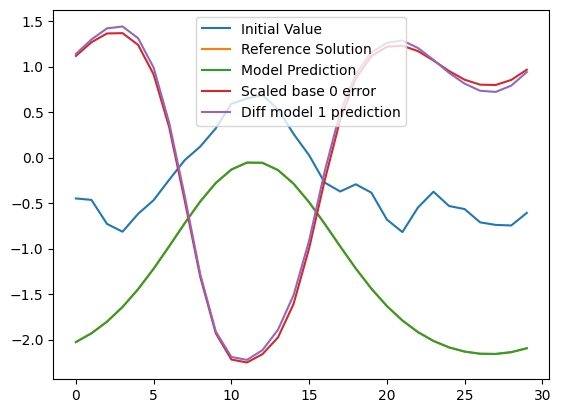

--------------------------------------RUN 40 --------------------------------------
Generated opt_params  32
0  :  3.312e-05
10  :  1.279e-05
20  :  1.097e-05
30  :  8.759e-06
40  :  7.338e-06
50  :  6.955e-06
60  :  5.904e-06
70  :  5.278e-06
80  :  5.07e-06
90  :  4.639e-06
100  :  4.458e-06
110  :  4.001e-06
120  :  3.987e-06
130  :  3.565e-06
140  :  3.417e-06
150  :  3.428e-06
160  :  3.217e-06
170  :  3.349e-06
180  :  3.133e-06
190  :  2.996e-06
200  :  2.874e-06
210  :  2.759e-06
220  :  2.556e-06
230  :  2.552e-06
240  :  2.366e-06
250  :  2.308e-06
260  :  2.375e-06
270  :  2.163e-06
280  :  2.246e-06
290  :  2.096e-06
300  :  2.12e-06
310  :  1.909e-06
320  :  1.878e-06
330  :  1.69e-06
340  :  1.694e-06
350  :  1.706e-06
360  :  1.655e-06
370  :  1.556e-06
380  :  1.57e-06
390  :  1.52e-06
400  :  1.421e-06
410  :  1.368e-06
420  :  1.449e-06
430  :  1.313e-06
440  :  1.359e-06
450  :  1.255e-06
460  :  1.276e-06
470  :  1.181e-06
480  :  1.206e-06
490  :  1.127e-06
500  : 

2023-01-25 23:38:36.772593: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 23:38:37.193915: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 23:38:37.616307: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  0.9957
10  :  0.8167
20  :  0.6607
30  :  0.5372
40  :  0.4372
50  :  0.3609
60  :  0.3245
70  :  0.2742
80  :  0.2065
90  :  0.2579
100  :  0.173
110  :  0.152
120  :  0.1479
130  :  0.1159
140  :  0.1074
150  :  0.1201
160  :  0.1347
170  :  0.1386
180  :  0.1162
190  :  0.09235
200  :  0.07206
210  :  0.06618
220  :  0.07049
230  :  0.05413
240  :  0.08933
250  :  0.06517
260  :  0.05305
270  :  0.04748
280  :  0.04809
290  :  0.03498
300  :  0.03578
310  :  0.05882
320  :  0.05079
330  :  0.03198
340  :  0.03393
350  :  0.02631
360  :  0.0275
370  :  0.04775
380  :  0.04628
390  :  0.02806
400  :  0.03059
410  :  0.02986
420  :  0.02827
430  :  0.1071
440  :  0.03198
450  :  0.03367
460  :  0.03953
470  :  0.0414
480  :  0.03704
490  :  0.04912
500  :  0.04703
510  :  0.04434
520  :  0.03489
530  :  0.03788
540  :  0.03719
    New learning rate:  0.002
    New Batch size:  1024
550  :  0.0352
560  :  0.02343
570  :  0.01998
580  :  0.01685
590  :  0.0183
600  :  0.01663
610  

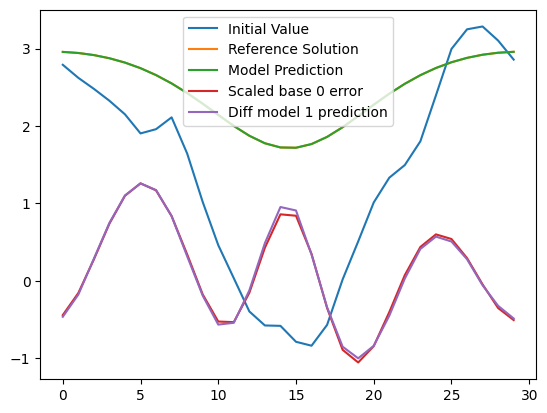

--------------------------------------RUN 41 --------------------------------------
Generated opt_params  33
0  :  3.183e-05
10  :  1.222e-05
20  :  1.074e-05
30  :  8.402e-06
40  :  6.856e-06
50  :  6.388e-06
60  :  5.737e-06
70  :  4.796e-06
80  :  4.667e-06
90  :  4.379e-06
100  :  4.224e-06
110  :  3.999e-06
120  :  3.701e-06
130  :  3.642e-06
140  :  3.155e-06
150  :  3.333e-06
160  :  2.977e-06
170  :  3.013e-06
180  :  2.68e-06
190  :  2.548e-06
200  :  2.386e-06
210  :  2.302e-06
220  :  2.115e-06
230  :  2.161e-06
240  :  2.003e-06
250  :  1.914e-06
260  :  1.901e-06
270  :  1.659e-06
280  :  1.553e-06
290  :  1.533e-06
300  :  1.569e-06
310  :  1.578e-06
320  :  1.396e-06
330  :  1.306e-06
340  :  1.3e-06
350  :  1.49e-06
360  :  1.221e-06
370  :  1.075e-06
380  :  1.15e-06
390  :  1.047e-06
400  :  1.091e-06
410  :  9.658e-07
420  :  1.04e-06
430  :  9.177e-07
440  :  1.028e-06
450  :  9.204e-07
460  :  9.22e-07
470  :  8.607e-07
480  :  7.804e-07
490  :  8.052e-07
500  :  8

Est. L2-error:  0.0002843901500288712


2023-01-25 23:46:07.144572: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 23:46:07.525041: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 23:46:07.903254: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.051
10  :  1.047
20  :  0.9467
30  :  0.8913
40  :  0.822
50  :  0.7945
60  :  0.6645
70  :  0.5282
80  :  0.4545
90  :  0.3709
100  :  0.3798
110  :  0.277
120  :  0.3074
130  :  0.265
140  :  0.1754
150  :  0.1997
160  :  0.1548
170  :  0.1345
180  :  0.132
190  :  0.1361
200  :  0.1213
210  :  0.1378
220  :  0.1446
230  :  0.1208
240  :  0.1297
250  :  0.1145
260  :  0.1139
270  :  0.1502
280  :  0.1047
290  :  0.1014
300  :  0.1745
310  :  0.1095
320  :  0.08593
330  :  0.0852
340  :  0.08669
350  :  0.08729
360  :  0.06836
370  :  0.07238
380  :  0.06275
390  :  0.0928
400  :  0.08549
410  :  0.08751
420  :  0.08527
430  :  0.08765
440  :  0.08271
450  :  0.08642
460  :  0.12
470  :  0.1837
480  :  0.07784
490  :  0.06741
500  :  0.0705
510  :  0.0573
520  :  0.05581
530  :  0.05969
540  :  0.07456
550  :  0.05193
560  :  0.05261
570  :  0.05998
580  :  0.08409
590  :  0.08235
600  :  0.07079
610  :  0.07059
620  :  0.08497
630  :  0.0672
640  :  0.06274
650  :  0.0753
660

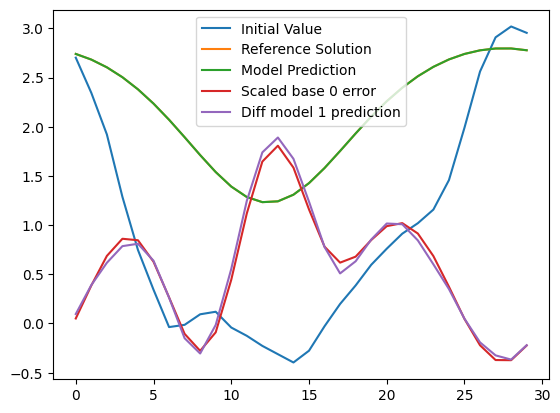

--------------------------------------RUN 42 --------------------------------------
Generated opt_params  34
0  :  3.753e-05
10  :  1.502e-05
20  :  1.264e-05
30  :  9.484e-06
40  :  8.894e-06
50  :  7.815e-06
60  :  7.729e-06
70  :  6.427e-06
80  :  6.172e-06
90  :  5.682e-06
100  :  5.246e-06
110  :  4.807e-06
120  :  4.843e-06
130  :  4.583e-06
140  :  4.596e-06
150  :  4.437e-06
160  :  4.387e-06
170  :  3.906e-06
180  :  4.011e-06
190  :  3.54e-06
200  :  3.608e-06
210  :  3.546e-06
220  :  3.21e-06
230  :  3.159e-06
240  :  3.175e-06
250  :  3.027e-06
260  :  2.738e-06
270  :  2.855e-06
280  :  2.818e-06
290  :  2.493e-06
300  :  2.641e-06
310  :  2.369e-06
320  :  2.276e-06
330  :  2.306e-06
340  :  2.266e-06
350  :  2.122e-06
360  :  2.014e-06
370  :  1.98e-06
380  :  2.021e-06
390  :  2.043e-06
400  :  1.903e-06
410  :  1.802e-06
420  :  1.781e-06
430  :  1.658e-06
440  :  1.745e-06
450  :  1.52e-06
460  :  1.567e-06
470  :  1.562e-06
480  :  1.518e-06
490  :  1.463e-06
500  :

2023-01-25 23:51:43.630177: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 23:51:44.014585: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 23:51:44.401108: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.036
10  :  0.9833
20  :  0.8862
30  :  0.7496
40  :  0.597
50  :  0.4413
60  :  0.4243
70  :  0.2928
80  :  0.276
90  :  0.272
100  :  0.2301
110  :  0.1548
120  :  0.2026
130  :  0.1619
140  :  0.142
150  :  0.1405
160  :  0.3427
170  :  0.1538
180  :  0.1104
190  :  0.1266
200  :  0.3503
210  :  0.1316
220  :  0.1243
230  :  0.09883
240  :  0.09136
250  :  0.1063
260  :  0.0753
270  :  0.07523
280  :  0.06613
290  :  0.06389
300  :  0.07216
310  :  0.07054
320  :  0.05595
330  :  0.04917
340  :  0.05391
350  :  0.05901
360  :  0.0594
370  :  0.04585
380  :  0.05078
390  :  0.05013
400  :  0.0417
410  :  0.04578
420  :  0.05099
430  :  0.04491
440  :  0.04793
450  :  0.0441
460  :  0.05078
470  :  0.05327
480  :  0.03608
490  :  0.03784
500  :  0.05259
510  :  0.04737
520  :  0.03624
530  :  0.04192
540  :  0.03418
550  :  0.03301
560  :  0.03274
570  :  0.02773
580  :  0.03113
590  :  0.03484
600  :  0.04683
610  :  0.03542
620  :  0.04191
630  :  0.03252
640  :  0.0347
650  

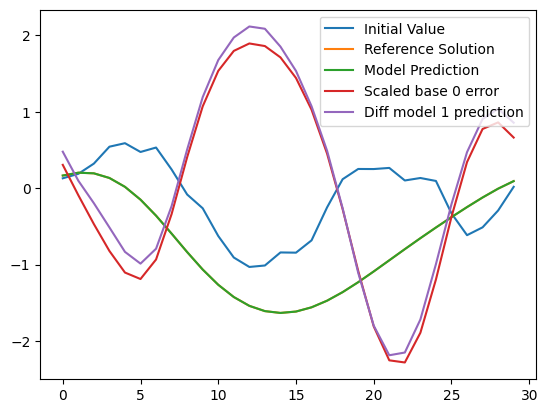

--------------------------------------RUN 43 --------------------------------------
Use opt_params  16  for the  2 th time
------ TRAINING BASE------
------ TRAINING DIFF 0 ------
Est. L2-error:  0.00033170135593211045


2023-01-25 23:54:21.188806: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 23:54:21.564738: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-25 23:54:21.941543: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  0.9946
10  :  0.872
20  :  0.7818
30  :  0.7765
40  :  0.5988
50  :  0.4476
60  :  0.2813
70  :  0.3113
80  :  0.2748
90  :  0.2206
100  :  0.1651
110  :  0.1675
120  :  0.1761
130  :  0.1765
140  :  0.1185
150  :  0.09979
160  :  0.1143
170  :  0.08657
180  :  0.1045
190  :  0.07078
200  :  0.05583
210  :  0.07773
220  :  0.102
230  :  0.1124
240  :  0.06312
250  :  0.06406
260  :  0.07219
270  :  0.06791
280  :  0.0649
290  :  0.06734
300  :  0.04716
310  :  0.05615
320  :  0.06815
330  :  0.06209
340  :  0.05607
350  :  0.1352
360  :  0.04925
370  :  0.05075
380  :  0.03528
390  :  0.03684
400  :  0.03711
410  :  0.02981
420  :  0.03338
430  :  0.03539
440  :  0.02744
450  :  0.08842
460  :  0.03106
470  :  0.03123
480  :  0.06891
490  :  0.03819
500  :  0.03257
510  :  0.03388
520  :  0.03764
530  :  0.03775
540  :  0.03704
550  :  0.02918
560  :  0.03903
570  :  0.03694
580  :  0.08808
    New learning rate:  0.002
    New Batch size:  1024
590  :  0.03419
600  :  0.02382
61

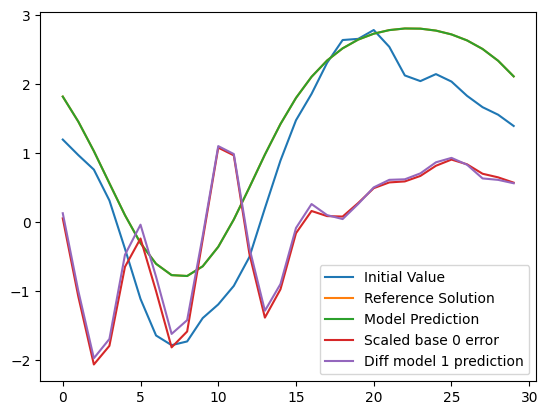

--------------------------------------RUN 44 --------------------------------------
Generated opt_params  35
0  :  2.816e-05
10  :  1.138e-05
20  :  9.774e-06
30  :  8.139e-06
40  :  7.024e-06
50  :  5.954e-06
60  :  5.512e-06
70  :  4.887e-06
80  :  4.596e-06
90  :  4.119e-06
100  :  3.918e-06
110  :  3.697e-06
120  :  3.316e-06
130  :  3.167e-06
140  :  3.253e-06
150  :  2.923e-06
160  :  2.84e-06
170  :  2.74e-06
180  :  2.471e-06
190  :  2.341e-06
200  :  2.337e-06
210  :  2.37e-06
220  :  2.046e-06
230  :  2.226e-06
240  :  1.972e-06
250  :  1.882e-06
260  :  1.775e-06
270  :  1.731e-06
280  :  1.757e-06
290  :  1.551e-06
300  :  1.575e-06
310  :  1.526e-06
320  :  1.485e-06
330  :  1.422e-06
340  :  1.349e-06
350  :  1.311e-06
360  :  1.251e-06
370  :  1.277e-06
380  :  1.214e-06
390  :  1.086e-06
400  :  1.111e-06
410  :  1.098e-06
420  :  1.028e-06
430  :  1.101e-06
440  :  1.007e-06
450  :  9.176e-07
460  :  9.637e-07
470  :  8.895e-07
480  :  9.416e-07
490  :  8.978e-07
500  

2023-01-26 00:01:36.312441: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-26 00:01:36.687343: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-26 00:01:37.063633: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.0
10  :  0.8535
20  :  0.7956
30  :  0.6835
40  :  0.4488
50  :  0.3881
60  :  0.3248
70  :  0.2844
80  :  0.2397
90  :  0.2211
100  :  0.1979
110  :  0.2019
120  :  0.1341
130  :  0.1313
140  :  0.1325
150  :  0.1375
160  :  0.09441
170  :  0.114
180  :  0.09795
190  :  0.1043
200  :  0.1129
210  :  0.07324
220  :  0.06959
230  :  0.06946
240  :  0.07131
250  :  0.08619
260  :  0.1157
270  :  0.08518
280  :  0.07305
290  :  0.05944
300  :  0.08441
310  :  0.05811
320  :  0.05357
330  :  0.04807
340  :  0.05116
350  :  0.06661
360  :  0.05157
370  :  0.04422
380  :  0.05822
390  :  0.04125
400  :  0.05357
410  :  0.0393
420  :  0.04802
430  :  0.06062
440  :  0.04285
450  :  0.04366
460  :  0.04141
470  :  0.06077
480  :  0.0491
490  :  0.04489
500  :  0.04018
510  :  0.03456
520  :  0.03377
530  :  0.05056
540  :  0.0481
550  :  0.03183
560  :  0.04355
570  :  0.03383
580  :  0.03857
590  :  0.04432
600  :  0.02804
610  :  0.03545
620  :  0.1064
630  :  0.02773
640  :  0.02845

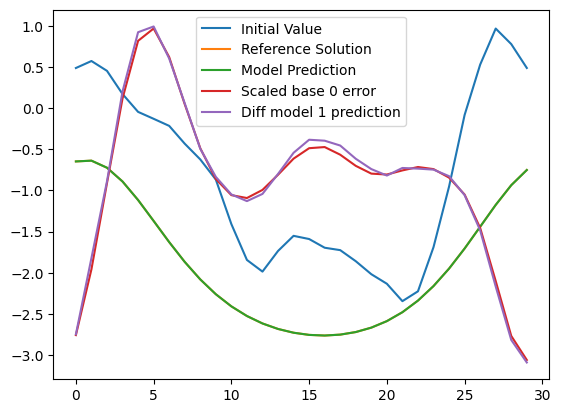

--------------------------------------RUN 45 --------------------------------------
Generated opt_params  36
0  :  4.179e-05
10  :  2.086e-05
20  :  1.692e-05
30  :  1.381e-05
40  :  1.306e-05
50  :  1.377e-05
60  :  1.221e-05
70  :  1.112e-05
80  :  1.116e-05
90  :  1.075e-05
100  :  9.65e-06
110  :  9.457e-06
120  :  1.011e-05
130  :  8.405e-06
140  :  9.645e-06
150  :  8.757e-06
160  :  8.674e-06
170  :  7.819e-06
180  :  7.225e-06
190  :  7.606e-06
200  :  7.764e-06
210  :  7.05e-06
220  :  7.004e-06
230  :  7.141e-06
240  :  6.942e-06
250  :  6.824e-06
260  :  6.068e-06
270  :  6.14e-06
280  :  5.498e-06
290  :  5.383e-06
300  :  5.749e-06
310  :  5.528e-06
320  :  5.576e-06
330  :  5.141e-06
340  :  4.587e-06
350  :  4.608e-06
360  :  4.604e-06
370  :  4.568e-06
380  :  4.846e-06
390  :  5.09e-06
400  :  4.251e-06
410  :  4.222e-06
420  :  4.295e-06
430  :  3.825e-06
440  :  3.828e-06
450  :  3.767e-06
460  :  3.695e-06
470  :  3.46e-06
480  :  3.595e-06
490  :  3.625e-06
500  : 

2023-01-26 00:06:55.369027: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-26 00:06:55.744947: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-26 00:06:56.120398: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.023
10  :  0.9692
20  :  0.7683
30  :  0.4425
40  :  0.3041
50  :  0.2966
60  :  0.2266
70  :  0.2113
80  :  0.1542
90  :  0.1509
100  :  0.1647
110  :  0.1476
120  :  0.1254
130  :  0.1008
140  :  0.105
150  :  0.1315
160  :  0.1591
170  :  0.1092
180  :  0.105
190  :  0.1011
200  :  0.08028
210  :  0.06293
220  :  0.0609
230  :  0.05386
240  :  0.06295
250  :  0.05201
260  :  0.06035
270  :  0.06709
280  :  0.05804
290  :  0.05935
300  :  0.04009
310  :  0.04719
320  :  0.03955
330  :  0.0541
340  :  0.0325
350  :  0.04575
360  :  0.04511
370  :  0.04356
380  :  0.2812
390  :  0.05972
400  :  0.03217
410  :  0.03465
420  :  0.0409
430  :  0.03575
440  :  0.03711
450  :  0.03407
460  :  0.03712
470  :  0.05267
480  :  0.08836
490  :  0.1112
500  :  0.0998
510  :  0.07722
520  :  0.07082
530  :  0.05198
540  :  0.04461
550  :  0.07836
560  :  0.0435
570  :  0.0306
    New learning rate:  0.002
    New Batch size:  1024
580  :  0.02827
590  :  0.02026
600  :  0.02087
610  :  0.0

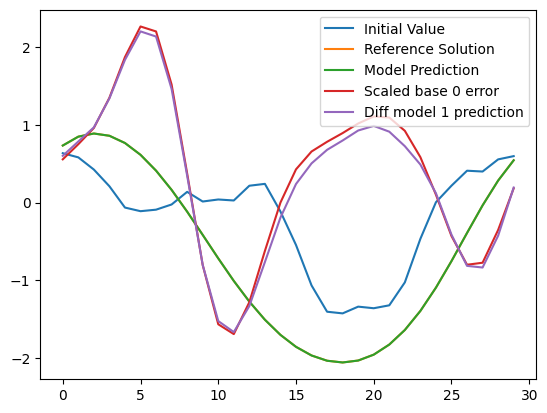

--------------------------------------RUN 46 --------------------------------------
Generated opt_params  37
0  :  4.195e-05
10  :  1.845e-05
20  :  1.552e-05
30  :  1.344e-05
40  :  1.268e-05
50  :  1.211e-05
60  :  1.142e-05
70  :  1.004e-05
80  :  9.376e-06
90  :  9.336e-06
100  :  9.094e-06
110  :  7.811e-06
120  :  7.671e-06
130  :  7.47e-06
140  :  7.026e-06
150  :  7.588e-06
160  :  7.01e-06
170  :  6.271e-06
180  :  6.436e-06
190  :  6.846e-06
200  :  6.073e-06
210  :  5.614e-06
220  :  5.515e-06
230  :  6.037e-06
240  :  5.997e-06
250  :  5.499e-06
260  :  5.074e-06
270  :  5.115e-06
280  :  4.911e-06
290  :  5.067e-06
300  :  4.987e-06
310  :  4.281e-06
320  :  4.651e-06
330  :  4.314e-06
340  :  4.338e-06
350  :  4.153e-06
360  :  4.053e-06
370  :  3.731e-06
380  :  3.973e-06
390  :  3.554e-06
400  :  3.163e-06
410  :  3.599e-06
420  :  3.355e-06
430  :  3.37e-06
440  :  3.299e-06
450  :  3.277e-06
460  :  3.183e-06
470  :  3.067e-06
480  :  2.992e-06
490  :  2.989e-06
500  

2023-01-26 00:12:08.221792: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-26 00:12:08.595625: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-26 00:12:08.969910: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  0.991
10  :  0.943
20  :  0.7314
30  :  0.5332
40  :  0.3994
50  :  0.2598
60  :  0.2436
70  :  0.1883
80  :  0.1582
90  :  0.1382
100  :  0.114
110  :  0.08813
120  :  0.07265
130  :  0.07071
140  :  0.09466
150  :  0.08588
160  :  1.337
170  :  0.09722
180  :  0.08681
190  :  0.09196
200  :  0.09442
210  :  0.07779
220  :  0.06814
230  :  0.06777
240  :  0.06381
250  :  0.05038
260  :  0.04538
270  :  0.03925
280  :  0.03896
290  :  0.0434
300  :  0.03754
310  :  0.03679
320  :  0.04769
330  :  0.03658
340  :  0.03433
350  :  0.1898
360  :  0.02692
370  :  0.04472
380  :  0.02581
390  :  0.03226
400  :  0.02736
410  :  0.02279
420  :  0.02169
430  :  0.05122
440  :  0.0226
450  :  0.02021
460  :  0.02228
470  :  0.03225
480  :  0.01799
490  :  0.0259
500  :  0.02452
510  :  0.01986
520  :  0.03468
530  :  0.04618
540  :  0.02036
550  :  0.01878
560  :  0.01839
570  :  0.02023
580  :  0.02233
590  :  0.02432
600  :  0.01866
610  :  0.01707
620  :  0.01496
630  :  0.0176
640  :  

--------------------------------------RUN 47 --------------------------------------
Generated opt_params  38
0  :  2.912e-05
10  :  1.246e-05
20  :  9.68e-06
30  :  8.422e-06
40  :  6.957e-06
50  :  6.368e-06
60  :  5.604e-06
70  :  4.93e-06
80  :  3.964e-06
90  :  3.831e-06
100  :  3.856e-06
110  :  3.276e-06
120  :  3.251e-06
130  :  3.138e-06
140  :  2.573e-06
150  :  2.631e-06
160  :  2.619e-06
170  :  2.204e-06
180  :  2.163e-06
190  :  1.916e-06
200  :  1.85e-06
210  :  1.776e-06
220  :  1.71e-06
230  :  1.618e-06
240  :  1.531e-06
250  :  1.337e-06
260  :  1.265e-06
270  :  1.251e-06
280  :  1.139e-06
290  :  1.114e-06
300  :  1.114e-06
310  :  1.052e-06
320  :  1.023e-06
330  :  9.627e-07
340  :  9.557e-07
350  :  9.77e-07
360  :  8.555e-07
370  :  9.315e-07
380  :  8.108e-07
390  :  8.103e-07
400  :  8.275e-07
410  :  8.229e-07
420  :  7.982e-07
430  :  7.09e-07
440  :  7.1e-07
450  :  6.585e-07
460  :  7.437e-07
470  :  6.533e-07
480  :  6.599e-07
490  :  6.728e-07
500  :  7.

2023-01-26 00:17:43.364162: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-26 00:17:43.738190: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-26 00:17:44.111545: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.055
10  :  0.8931
20  :  0.7756
30  :  0.718
40  :  0.8221
50  :  0.6422
60  :  0.5014
70  :  0.4345
80  :  0.4057
90  :  0.3833
100  :  0.4089
110  :  0.3326
120  :  0.3601
130  :  0.2901
140  :  0.2609
150  :  0.2763
160  :  0.2834
170  :  0.1745
180  :  0.1902
190  :  0.1773
200  :  0.149
210  :  0.1359
220  :  0.1091
230  :  0.1113
240  :  0.1016
250  :  0.09956
260  :  0.1026
270  :  0.1134
280  :  0.07873
290  :  0.08371
300  :  0.09924
310  :  0.09487
320  :  0.08886
330  :  0.08407
340  :  0.08772
350  :  0.07692
360  :  0.0857
370  :  0.08474
380  :  0.06985
390  :  0.1383
400  :  0.05189
410  :  0.05803
420  :  0.06114
430  :  0.09649
440  :  0.0579
450  :  0.06816
460  :  0.06482
470  :  0.05303
480  :  0.05355
490  :  0.04719
500  :  0.04837
510  :  0.08054
520  :  0.04784
530  :  0.05649
540  :  0.03868
550  :  0.04272
560  :  0.06368
570  :  0.04044
580  :  0.03725
590  :  0.03522
600  :  0.04774
610  :  0.04519
620  :  0.05041
630  :  0.03355
640  :  0.03308
650 

--------------------------------------RUN 48 --------------------------------------
Generated opt_params  39
0  :  3.361e-05
10  :  1.306e-05
20  :  1.119e-05
30  :  8.751e-06
40  :  8.506e-06
50  :  7.028e-06
60  :  6.347e-06
70  :  6.064e-06
80  :  5.478e-06
90  :  5.265e-06
100  :  4.346e-06
110  :  4.198e-06
120  :  4.171e-06
130  :  4.142e-06
140  :  3.778e-06
150  :  3.457e-06
160  :  3.168e-06
170  :  2.947e-06
180  :  3.092e-06
190  :  2.631e-06
200  :  2.677e-06
210  :  2.588e-06
220  :  2.546e-06
230  :  2.166e-06
240  :  2.188e-06
250  :  2.051e-06
260  :  2.059e-06
270  :  1.809e-06
280  :  1.728e-06
290  :  1.67e-06
300  :  1.607e-06
310  :  1.529e-06
320  :  1.428e-06
330  :  1.432e-06
340  :  1.359e-06
350  :  1.35e-06
360  :  1.33e-06
370  :  1.3e-06
380  :  1.153e-06
390  :  1.115e-06
400  :  1.049e-06
410  :  1.097e-06
420  :  1.051e-06
430  :  9.631e-07
440  :  9.718e-07
450  :  9.828e-07
460  :  9.191e-07
470  :  8.767e-07
480  :  9.19e-07
490  :  1.115e-06
500  :  

2023-01-26 00:22:37.588960: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-26 00:22:37.961693: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-26 00:22:38.341871: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.035
10  :  0.9464
20  :  0.8569
30  :  0.8684
40  :  0.6921
50  :  0.6287
60  :  0.4744
70  :  0.4161
80  :  0.3393
90  :  0.273
100  :  0.2627
110  :  0.2136
120  :  0.2453
130  :  0.3004
140  :  0.3027
150  :  0.2261
160  :  0.2532
170  :  0.1918
180  :  0.1634
190  :  0.1483
200  :  0.1414
210  :  0.1353
220  :  0.1073
230  :  0.09775
240  :  0.1146
250  :  0.08693
260  :  0.08575
270  :  0.07237
280  :  0.06905
290  :  0.06303
300  :  0.06676
310  :  0.07794
320  :  0.06847
330  :  0.08214
340  :  0.0691
350  :  0.1185
360  :  0.1009
370  :  0.07343
380  :  0.08694
390  :  0.07655
400  :  0.08259
410  :  0.05622
420  :  0.08491
430  :  0.05718
440  :  0.04876
450  :  0.06243
460  :  0.06769
470  :  0.0732
480  :  0.06414
490  :  0.05181
500  :  0.06063
510  :  0.07473
520  :  0.05655
530  :  0.06281
540  :  0.04184
550  :  0.03635
560  :  0.04571
570  :  0.03745
580  :  0.04716
590  :  0.05025
600  :  0.05449
610  :  0.07139
620  :  0.04431
630  :  0.05764
640  :  0.04304
6

--------------------------------------RUN 49 --------------------------------------
Generated opt_params  40
0  :  3.168e-05
10  :  1.348e-05
20  :  1.177e-05
30  :  9.392e-06
40  :  7.795e-06
50  :  7.346e-06
60  :  6.466e-06
70  :  5.994e-06
80  :  5.559e-06
90  :  5.28e-06
100  :  5.084e-06
110  :  4.567e-06
120  :  4.273e-06
130  :  4.25e-06
140  :  4.038e-06
150  :  3.882e-06
160  :  3.669e-06
170  :  3.466e-06
180  :  3.456e-06
190  :  3.34e-06
200  :  3.232e-06
210  :  3.009e-06
220  :  3.266e-06
230  :  2.95e-06
240  :  2.904e-06
250  :  2.835e-06
260  :  2.559e-06
270  :  2.427e-06
280  :  2.446e-06
290  :  2.27e-06
300  :  2.188e-06
310  :  2.31e-06
320  :  2.243e-06
330  :  2.073e-06
340  :  2.006e-06
350  :  1.833e-06
360  :  1.921e-06
370  :  1.854e-06
380  :  1.702e-06
390  :  1.773e-06
400  :  1.593e-06
410  :  1.64e-06
420  :  1.583e-06
430  :  1.495e-06
440  :  1.421e-06
450  :  1.552e-06
460  :  1.478e-06
470  :  1.41e-06
480  :  1.305e-06
490  :  1.316e-06
500  :  1.

2023-01-26 00:27:35.166110: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-26 00:27:35.539852: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-26 00:27:35.911679: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  1.01
10  :  1.006
20  :  0.9157
30  :  0.6916
40  :  0.4884
50  :  0.3069
60  :  0.2224
70  :  0.2226
80  :  0.1886
90  :  0.1302
100  :  0.1126
110  :  0.1198
120  :  0.07892
130  :  0.083
140  :  0.08653
150  :  0.07848
160  :  0.05657
170  :  0.06046
180  :  0.0536
190  :  0.05691
200  :  0.05353
210  :  0.06348
220  :  0.05849
230  :  0.04177
240  :  0.03965
250  :  0.05002
260  :  0.05393
270  :  0.05149
280  :  0.04406
290  :  0.05121
300  :  0.04338
310  :  0.02898
320  :  0.03531
330  :  0.03297
340  :  0.02776
350  :  0.02899
360  :  0.04121
370  :  0.03232
380  :  0.02475
390  :  0.02661
400  :  0.02583
410  :  0.02526
420  :  0.02568
430  :  0.03527
440  :  0.0302
450  :  0.02152
460  :  0.01983
470  :  0.03106
480  :  0.03655
490  :  0.04062
500  :  0.02503
510  :  0.04115
520  :  0.04161
530  :  0.03872
540  :  0.02756
550  :  0.02723
560  :  0.02599
570  :  0.03279
580  :  0.03122
590  :  0.02637
600  :  0.02612
610  :  0.02032
620  :  0.0458
630  :  0.02387
640  : 

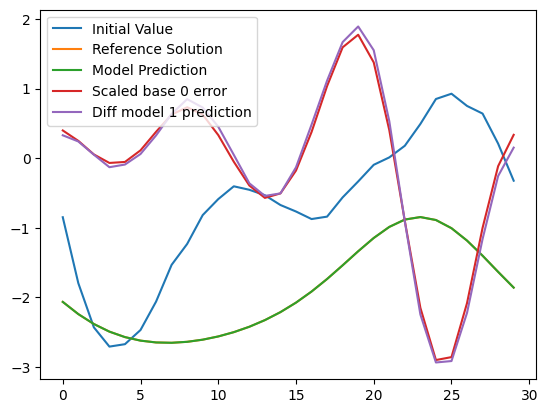

In [9]:
next_step_decider = LIRK2_uniform_sampler(opt_p1_low, opt_p1_high, opt_p2_low, opt_p2_high, opt_nr_of_runs)

base_models = []
full_models = []
opt_params = []
opt_start_errors = []
opt_end_errors_base = []
opt_end_errors = []
base_traintimes = []
diff_traintimes = []


#Store the results
opt_foldername = "Results_opt"
opt_foldername_full = os.getcwd() + "/" + opt_foldername #for shutil.copyfile
if not os.path.exists(opt_foldername):
        os.makedirs(opt_foldername)

with open(opt_foldername + '/opt_simulation_results.txt', 'w+') as f:
    start_time = time.perf_counter()
    
    current_run_nr = 0
    while current_run_nr < opt_nr_of_runs:
        
        print("--------------------------------------RUN", current_run_nr, "--------------------------------------")
        print("--------------------------------------RUN", str(current_run_nr) + "--------------------------------------", file = f)
        
        this_run_base_nr, new_opt_params = next_step_decider(opt_end_errors)        
        
        if this_run_base_nr == -1:
            this_run_base_nr = len(base_models)
            
            print("Generated opt_params ", this_run_base_nr, file = f)
            print("Generated opt_params ", this_run_base_nr)
            
            new_base_model = base_model_class(T, pde, nr_spacediscr, nr_timesteps, new_opt_params, training_samples_generator, learning_rate = base_initial_lr)
            
            start_error = evaluate(new_base_model, evaluate_samples = end_eval_samples) 
            csv_summary(new_base_model, opt_foldername + "/Z_start_error_" + str(this_run_base_nr))

            base_traintime = whole_training(new_base_model, 
                                            base_initial_lr, 
                                            base_initial_batchsize, 
                                            base_tolerance, 
                                            base_max_trainsteps, 
                                            evaluate_steps = eval_steps, 
                                            evaluate_samples = eval_samples)
            
            end_error_base = evaluate(new_base_model, evaluate_samples = end_eval_samples)
            csv_summary(new_base_model, opt_foldername + "/Z_end_error_base_" + str(this_run_base_nr))            
            
            base_models = base_models + [new_base_model]
            opt_params = opt_params + [new_opt_params]
            opt_start_errors = opt_start_errors + [start_error]
            opt_end_errors_base = opt_end_errors_base + [end_error_base]
            opt_end_errors = opt_end_errors + [[]]
            base_traintimes = base_traintimes + [base_traintime]
            diff_traintimes = diff_traintimes + [[]]
            full_models = full_models + [[]]
            
        else:
            print("Use opt_params ", this_run_base_nr, " for the ", len(opt_end_errors[this_run_base_nr])+1, "th time", file = f)
            print("Use opt_params ", this_run_base_nr, " for the ", len(opt_end_errors[this_run_base_nr])+1, "th time")
            
    
        difference_learning_model = Difference_learning_model(T, 
                                                              pde, 
                                                              nr_spacediscr,
                                                              base = base_models[this_run_base_nr], 
                                                              nr_timesteps_base = 0,
                                                              params_base = None, 
                                                              diff_classes = [diff_model_class], 
                                                              diff_params = [diff_model_params], 
                                                              training_samples_generator = training_samples_generator)
        
        
        base_traintime, diff_traintime = multi_difference_model_training(difference_learning_model, 
                                                                        initial_learning_rates = [base_initial_lr, diff_initial_lr], 
                                                                        initial_batch_sizes = [base_initial_batchsize, diff_initial_batchsize], 
                                                                        tolerances = [base_tolerance, diff_tolerance], 
                                                                        max_trainsteps = [0, diff_max_trainsteps], 
                                                                        evaluate_steps = eval_steps, 
                                                                        estimate_samples = est_samples,
                                                                        evaluate_samples = eval_samples)
        
        end_error = evaluate(difference_learning_model, evaluate_samples = end_eval_samples)   
        csv_summary(difference_learning_model, opt_foldername + "/Z_end_error_" + str(this_run_base_nr) + "_" + str(len(opt_end_errors[this_run_base_nr])))
        
        opt_end_errors[this_run_base_nr] = opt_end_errors[this_run_base_nr] + [end_error]
        diff_traintimes[this_run_base_nr] = diff_traintimes[this_run_base_nr] + [diff_traintime]
        full_models[this_run_base_nr] = full_models[this_run_base_nr] + [difference_learning_model]

        summary(difference_learning_model, multidiff_model = True, write_file = f, plot_file_name = opt_foldername + "/Z_plot_" + str(this_run_base_nr) + "_" + str(len(opt_end_errors[this_run_base_nr])))
        print("\n\n", file = f)
        
        current_run_nr = current_run_nr + 1
    
    
    best_start = opt_start_errors.index(min(opt_start_errors))
    best_trained_base = opt_end_errors_base.index(min(opt_end_errors_base))
    best_full_adann = minimal_index(opt_end_errors)
    
    total_time = time.perf_counter() - start_time 
    
    #Remember best model
    best_full_adann_model = full_models[best_full_adann[0]][best_full_adann[1]]
    
    #Copy best error files
    shutil.copyfile(opt_foldername + "/Z_start_error_" + str(best_start) + ".csv", opt_foldername + "/opt_best_start_error_" + str(best_start) + ".csv")
    shutil.copyfile(opt_foldername + "/Z_end_error_base_" + str(best_trained_base) + ".csv", opt_foldername + "/opt_best_end_error_base_" + str(best_trained_base) + ".csv")
    shutil.copyfile(opt_foldername + "/Z_end_error_" + str(best_full_adann[0]) + "_" + str(best_full_adann[1]) + ".csv", opt_foldername + "/opt_best_end_error_" + str(best_full_adann[0]) + "_" + str(best_full_adann[1]) + ".csv")

    
    #Print some summary values
    
    print("\n\n\n--------------------------------------", file = f)
    
    print("Best errors:", file = f)
    print("    Best start: ", opt_start_errors[best_start], "(" + str(best_start) + ")", file = f)
    print("    Best trained base: ", opt_end_errors_base[best_trained_base], "(" + str(best_trained_base) + ")", file = f)
    print("    Best full ADANN: ", opt_end_errors[best_full_adann[0]][best_full_adann[1]], best_full_adann, file = f)
    
    
    print("\nTrain times:", file = f)
    print("    Total time : ", total_time, file = f)
    print("    Total train time: ", np.sum(base_traintimes) + np.sum([np.sum(times) for times in diff_traintimes]), file = f)
    print("    Total base train time: ", np.sum(base_traintimes), file = f)
    print("    Total diff train time: ", np.sum([np.sum(times) for times in diff_traintimes]), file = f)
    print("\n    Average base train time: ", np.mean(base_traintimes), file = f)
    print("    Average diff train time: ",np.sum([np.sum(times) for times in diff_traintimes])/opt_nr_of_runs, file = f)


    
with open(opt_foldername + "/Y_opt_params.txt", 'w+') as f:
    print(opt_params, file = f)
with open(opt_foldername + "/Y_opt_start_errors.txt", 'w+') as f:
    print(opt_start_errors, file = f)
with open(opt_foldername + "/Y_opt_end_errors_base.txt", 'w+') as f:
    print(opt_end_errors_base, file = f)
with open(opt_foldername + "/Y_opt_end_errors.txt", 'w+') as f:
    print(opt_end_errors, file = f)

In [10]:
start_errors_stretched = [[opt_start_errors[i] for _ in range(len(opt_end_errors[i]))] for i in range(len(opt_end_errors))]
end_errors_base_stretched = [[opt_end_errors_base[i] for _ in range(len(opt_end_errors[i]))] for i in range(len(opt_end_errors))]

lengths = [len(errors) for errors in opt_end_errors]
line_locations = np.cumsum(lengths)

plt.figure()
for l in line_locations[:-1]:
    plt.axvline(x = l - 0.5, color = 'navajowhite')
plt.semilogy([classical_reference_error for ss in start_errors_stretched for s in ss], label = "Classical approx. error")
plt.semilogy([s for ss in start_errors_stretched for s in ss], label = "Start errors")
plt.semilogy([s for ss in end_errors_base_stretched for s in ss], label = "Trained base errors")
plt.semilogy([s for ss in opt_end_errors for s in ss], label = "Trained full ADANN errors")
plt.xlabel("Run number")
plt.ylabel("Estimated " + r'$L^2$'+ "-error")
plt.legend(loc = "upper left")
plt.savefig(opt_foldername + "/opt_end_errors.pdf")
plt.show()

#### ANN Experiment

--------------------------------------RUN 0 --------------------------------------
0  :  4.491
10  :  0.2407
20  :  0.1056
30  :  0.06058
40  :  0.03478
50  :  0.02501
60  :  0.01645
70  :  0.01355
80  :  0.008871
90  :  0.007597
100  :  0.006594
110  :  0.005812
120  :  0.006168
130  :  0.005396
140  :  0.009188
150  :  0.005071
160  :  0.004968
170  :  0.00444
180  :  0.003844
190  :  0.003677
200  :  0.002901
210  :  0.003234
220  :  0.002818
230  :  0.002423
240  :  0.002398
250  :  0.002336
260  :  0.002836
270  :  0.002569
280  :  0.002583
290  :  0.002545
300  :  0.001916
310  :  0.003083
320  :  0.003082
330  :  0.002854
340  :  0.001765
350  :  0.002517
360  :  0.002615
370  :  0.002199
380  :  0.001889
390  :  0.002698
400  :  0.004651
410  :  0.002911
420  :  0.00289
430  :  0.002239
440  :  0.002309
450  :  0.002023
460  :  0.0017
470  :  0.00241
480  :  0.00318
490  :  0.002635
500  :  0.003723
510  :  0.002243
520  :  0.003003
530  :  0.005181
540  :  0.003118
550  :  0.0

--------------------------------------RUN 1 --------------------------------------
0  :  4.212
10  :  0.2934
20  :  0.1275
30  :  0.06665
40  :  0.03999
50  :  0.02394
60  :  0.01916
70  :  0.01388
80  :  0.01265
90  :  0.01048
100  :  0.009866
110  :  0.007063
120  :  0.006802
130  :  0.007136
140  :  0.006065
150  :  0.005855
160  :  0.004963
170  :  0.004395
180  :  0.004228
190  :  0.003935
200  :  0.003923
210  :  0.003477
220  :  0.003452
230  :  0.003424
240  :  0.002802
250  :  0.003194
260  :  0.003286
270  :  0.002988
280  :  0.002973
290  :  0.002413
300  :  0.002336
310  :  0.002164
320  :  0.002258
330  :  0.002032
340  :  0.002566
350  :  0.002268
360  :  0.002322
370  :  0.002207
380  :  0.002051
390  :  0.001741
400  :  0.00163
410  :  0.001644
420  :  0.002102
430  :  0.001857
440  :  0.001852
450  :  0.001473
460  :  0.001763
470  :  0.00197
480  :  0.002642
490  :  0.002184
500  :  0.002251
510  :  0.002024
520  :  0.002111
530  :  0.002068
540  :  0.001645
550  :  0

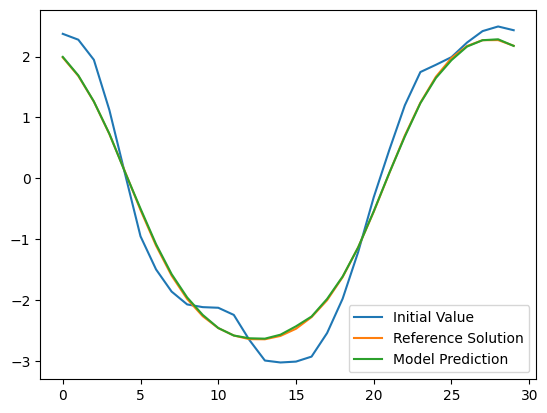

--------------------------------------RUN 2 --------------------------------------
0  :  4.693
10  :  0.3754
20  :  0.1615
30  :  0.07632
40  :  0.04118
50  :  0.02633
60  :  0.02006
70  :  0.01568
80  :  0.01178
90  :  0.01033
100  :  0.008077
110  :  0.007079
120  :  0.006507
130  :  0.006615
140  :  0.005794
150  :  0.004658
160  :  0.004535
170  :  0.004391
180  :  0.004281
190  :  0.003574
200  :  0.003166
210  :  0.003252
220  :  0.003037
230  :  0.002758
240  :  0.003096
250  :  0.00276
260  :  0.002511
270  :  0.002656
280  :  0.002313
290  :  0.002712
300  :  0.00236
310  :  0.002888
320  :  0.00278
330  :  0.003899
340  :  0.003596
350  :  0.002553
360  :  0.002162
370  :  0.00194
380  :  0.002204
390  :  0.002054
400  :  0.001795
410  :  0.004139
420  :  0.002121
430  :  0.0024
440  :  0.003433
450  :  0.003271
460  :  0.002058
470  :  0.002555
480  :  0.001304
490  :  0.001398
500  :  0.001627
510  :  0.001995
520  :  0.001914
530  :  0.001416
540  :  0.001845
550  :  0.001

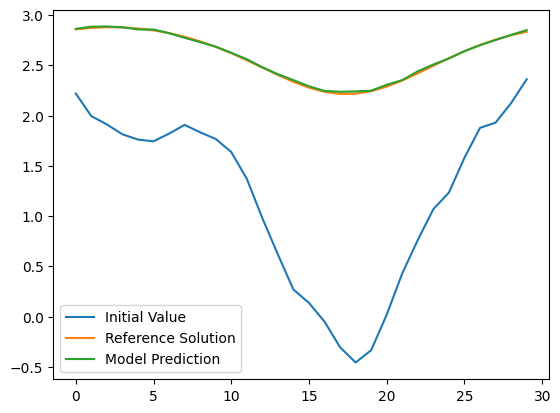

--------------------------------------RUN 3 --------------------------------------
0  :  4.565
10  :  0.2583
20  :  0.1179
30  :  0.05758
40  :  0.03117
50  :  0.02333
60  :  0.01499
70  :  0.01038
80  :  0.008771
90  :  0.007787
100  :  0.006246
110  :  0.005744
120  :  0.006027
130  :  0.004827
140  :  0.004246
150  :  0.004509
160  :  0.004241
170  :  0.003416
180  :  0.00399
190  :  0.003238
200  :  0.003292
210  :  0.002885
220  :  0.003084
230  :  0.003781
240  :  0.0026
250  :  0.002958
260  :  0.003102
270  :  0.002083
280  :  0.002264
290  :  0.002136
300  :  0.001977
310  :  0.002154
320  :  0.002581
330  :  0.002283
340  :  0.002411
350  :  0.002398
360  :  0.002577
370  :  0.002493
380  :  0.00211
390  :  0.001852
400  :  0.002066
410  :  0.002228
420  :  0.001699
430  :  0.002109
440  :  0.002446
450  :  0.002503
460  :  0.002753
470  :  0.002993
480  :  0.0018
490  :  0.002155
500  :  0.001477
510  :  0.001418
520  :  0.001499
530  :  0.001925
540  :  0.001316
550  :  0.0

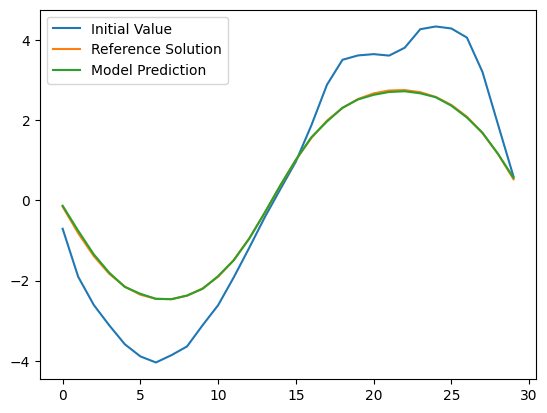

--------------------------------------RUN 4 --------------------------------------
0  :  4.644
10  :  0.18
20  :  0.1127
30  :  0.05285
40  :  0.02906
50  :  0.01873
60  :  0.01386
70  :  0.01124
80  :  0.008882
90  :  0.007683
100  :  0.006879
110  :  0.007146
120  :  0.005886
130  :  0.004626
140  :  0.004643
150  :  0.004071
160  :  0.00385
170  :  0.003468
180  :  0.003131
190  :  0.002889
200  :  0.003247
210  :  0.003689
220  :  0.004256
230  :  0.005809
240  :  0.005532
250  :  0.004039
260  :  0.004345
270  :  0.004703
280  :  0.002977
290  :  0.00299
300  :  0.002515
310  :  0.002259
320  :  0.002525
330  :  0.002629
340  :  0.002394
350  :  0.002143
360  :  0.002981
370  :  0.00231
380  :  0.001546
390  :  0.00181
400  :  0.00238
410  :  0.002748
420  :  0.003683
430  :  0.002533
440  :  0.002727
450  :  0.00249
460  :  0.007502
470  :  0.00705
480  :  0.009973
490  :  0.007428
500  :  0.003797
    New learning rate:  0.002
    New Batch size:  1024
510  :  0.002351
520  :  0

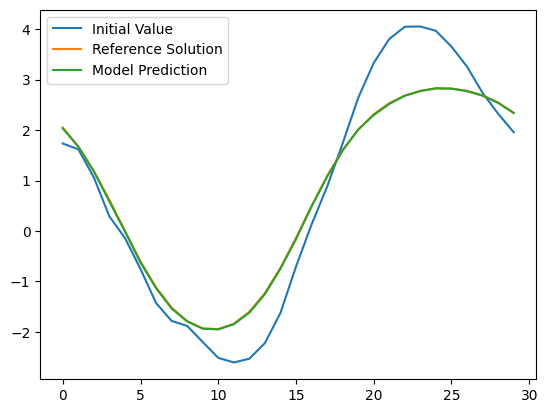

In [11]:
ann_errors = []
train_times = []
ann_models = []

#Create forlder to store results
ann_foldername = "Results_ANN"
if not os.path.exists(ann_foldername):
    os.makedirs(ann_foldername)


#Run the experiment
start_time = time.perf_counter() 
with open(ann_foldername + '/ANN_simulation_results.txt', 'w+') as f:
    for current_run_nr in range(ann_nr_of_runs):
        
        print("--------------------------------------RUN", current_run_nr, "--------------------------------------")
        print("--------------------------------------RUN", str(current_run_nr) + "--------------------------------------", file = f)

        ann_model = ANN_Model(layer_dims, training_samples_generator)

        train_time = whole_training(ann_model, ann_initial_lr, ann_initial_batchsize, tolerance = ann_tolerance, max_trainsteps = ann_max_trainsteps, evaluate_steps = eval_steps, evaluate_samples = eval_samples)
        error = evaluate(ann_model, end_eval_samples)

        ann_errors = ann_errors + [error]
        train_times = train_times + [train_time]
        ann_models = ann_models + [ann_model]
        
        summary(ann_model, write_file=f, plot_file_name = ann_foldername + "/ANN_plot_" + str(current_run_nr))
        print("\n\n", file = f)
    
    best_ann_index = ann_errors.index(min(ann_errors))
    best_ann_model = ann_models[best_ann_index]
    csv_summary(best_ann_model, ann_foldername + "/ANN_best_error")

    total_time = time.perf_counter() - start_time 
    


    print("\n\n\n--------------------------------------\nTrain times:", file = f)
    print("    Best error: ", ann_errors[best_ann_index], "(" + str(best_ann_index) + ")", file = f)
    print("    Total time : ", total_time, file = f)
    print("    Total train time: ", sum(train_times), file = f)


    
with open(ann_foldername + "/Y_ann_errors.txt", 'w+') as f:
    print(ann_errors, file = f)

#### FNO Experiment

--------------------------------------RUN 0 --------------------------------------


2023-01-26 00:33:59.221901: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-26 00:33:59.594767: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-26 00:33:59.974350: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-26 00:34:00.347433: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  4.38
10  :  0.2237
20  :  0.09238
30  :  0.03197
40  :  0.01191
50  :  0.003658
60  :  0.00266
70  :  0.002001
80  :  0.001174
90  :  0.001056
100  :  0.0009419
110  :  0.0007424
120  :  0.0006074
130  :  0.000728
140  :  0.0006388
150  :  0.0004991
160  :  0.000448
170  :  0.0003967
180  :  0.000367
190  :  0.0004174
200  :  0.0002906
210  :  0.0002628
220  :  0.0003005
230  :  0.0002562
240  :  0.000247
250  :  0.0002295
260  :  0.0002174
270  :  0.0003786
280  :  0.0008916
290  :  0.0002286
300  :  0.001351
310  :  0.0001983
320  :  0.001233
330  :  0.0003392
340  :  0.0019
350  :  0.005648
360  :  0.0009013
370  :  0.0007485
380  :  0.001621
390  :  0.0006729
400  :  0.0001911
410  :  0.0002914
420  :  0.000269
430  :  0.0001614
440  :  0.004445
450  :  0.002328
460  :  0.001393
470  :  0.0004028
480  :  0.0001643
490  :  0.0001395
500  :  0.0001117
510  :  0.0001666
520  :  0.0002436
530  :  0.0002985
540  :  9.79e-05
550  :  0.0002515
560  :  0.003278
570  :  0.0002493
580 

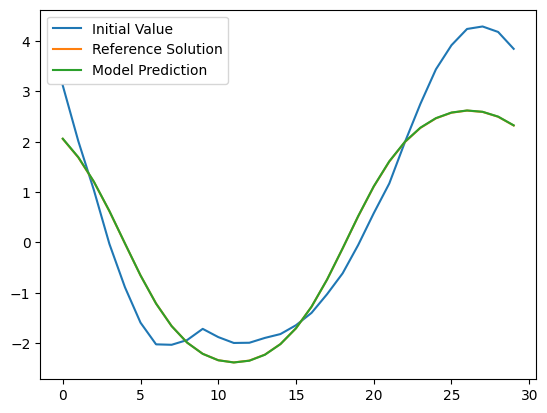

--------------------------------------RUN 1 --------------------------------------


2023-01-26 00:38:42.402153: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-26 00:38:42.779008: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-26 00:38:43.153960: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-26 00:38:43.527354: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  4.374
10  :  0.3615
20  :  0.07205
30  :  0.02428
40  :  0.009471
50  :  0.003946
60  :  0.002145
70  :  0.002057
80  :  0.001591
90  :  0.001298
100  :  0.00103
110  :  0.00082
120  :  0.0007653
130  :  0.0006402
140  :  0.0005673
150  :  0.0004869
160  :  0.0009298
170  :  0.0003935
180  :  0.0003767
190  :  0.0003355
200  :  0.0003032
210  :  0.0002569
220  :  0.0002587
230  :  0.0002719
240  :  0.0002082
250  :  0.0001655
260  :  0.0001853
270  :  0.0001844
280  :  0.0001917
290  :  0.0001939
300  :  0.0001437
310  :  0.0002772
320  :  0.0001269
330  :  0.0001352
340  :  0.0001925
350  :  9.92e-05
360  :  0.0001495
370  :  0.0002871
380  :  0.0001324
390  :  0.0001828
400  :  0.0001226
410  :  8.964e-05
420  :  8.593e-05
430  :  7.413e-05
440  :  8.918e-05
450  :  0.0001963
460  :  0.0001803
470  :  0.0002057
480  :  0.0001434
490  :  0.0006501
500  :  0.002049
510  :  0.001729
520  :  0.0001129
530  :  9.037e-05
540  :  0.0003088
550  :  0.0001335
560  :  0.0003226
570  :  0

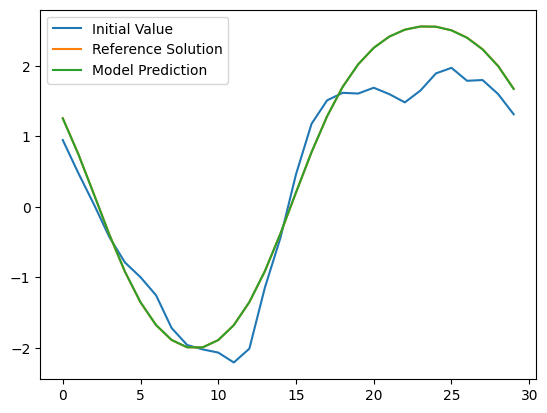

--------------------------------------RUN 2 --------------------------------------


2023-01-26 00:41:28.635741: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-26 00:41:29.009791: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-26 00:41:29.382524: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-26 00:41:29.756871: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  4.43
10  :  0.5468
20  :  0.07674
30  :  0.04208
40  :  0.02106
50  :  0.007814
60  :  0.003671
70  :  0.002348
80  :  0.001538
90  :  0.001357
100  :  0.0009875
110  :  0.0009249
120  :  0.0007477
130  :  0.001181
140  :  0.0006342
150  :  0.000555
160  :  0.0007389
170  :  0.0004662
180  :  0.0004171
190  :  0.0003996
200  :  0.0005159
210  :  0.0005143
220  :  0.0002928
230  :  0.0003957
240  :  0.0003845
250  :  0.0002591
260  :  0.0003468
270  :  0.000244
280  :  0.0002779
290  :  0.0004198
300  :  0.0002778
310  :  0.0002363
320  :  0.0003237
330  :  0.0001878
340  :  0.0001797
350  :  0.0001554
360  :  0.0001781
370  :  0.0001371
380  :  0.000166
390  :  0.0001696
400  :  0.000207
410  :  0.000313
420  :  0.0002145
430  :  0.0001738
440  :  0.0002111
450  :  0.0002063
460  :  0.0001342
470  :  0.0002143
480  :  0.0001816
490  :  0.0002273
500  :  0.0001432
510  :  0.0001595
520  :  9.806e-05
530  :  0.02624
540  :  0.01338
550  :  0.001217
560  :  0.001176
570  :  0.000558

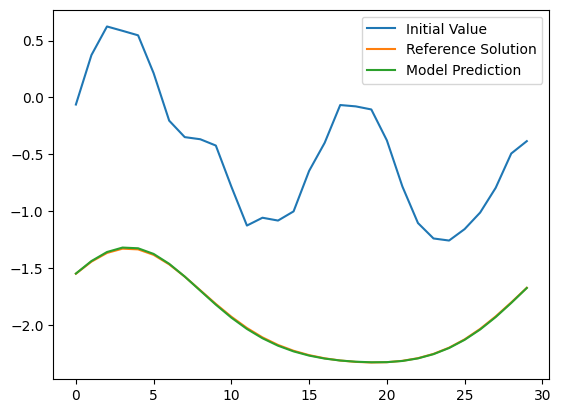

--------------------------------------RUN 3 --------------------------------------


2023-01-26 00:43:39.923755: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-26 00:43:40.296591: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-26 00:43:40.670592: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-26 00:43:41.052236: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  4.339
10  :  0.4199
20  :  0.05034
30  :  0.0172
40  :  0.009876
50  :  0.006008
60  :  0.002764
70  :  0.001469
80  :  0.001058
90  :  0.00086
100  :  0.0006196
110  :  0.0006804
120  :  0.0005921
130  :  0.000492
140  :  0.000453
150  :  0.0005066
160  :  0.0004186
170  :  0.0003726
180  :  0.0003831
190  :  0.0004736
200  :  0.0003064
210  :  0.0004416
220  :  0.0002322
230  :  0.0002961
240  :  0.0003218
250  :  0.0002653
260  :  0.003805
270  :  0.002257
280  :  0.0006585
290  :  0.0001938
300  :  0.0002283
310  :  0.0003421
320  :  0.0002925
330  :  0.0002271
340  :  0.0001788
350  :  0.0001723
360  :  0.0001927
370  :  0.0006943
380  :  0.0004852
390  :  0.002102
400  :  0.003246
410  :  0.0003019
420  :  0.0002204
430  :  0.0001242
440  :  0.00044
450  :  0.0001419
460  :  0.0001417
470  :  0.0001392
480  :  0.0001138
490  :  0.0001257
500  :  9.684e-05
510  :  8.99e-05
520  :  0.0001069
530  :  0.002061
540  :  0.0002816
550  :  0.001057
560  :  0.0001254
570  :  0.00186

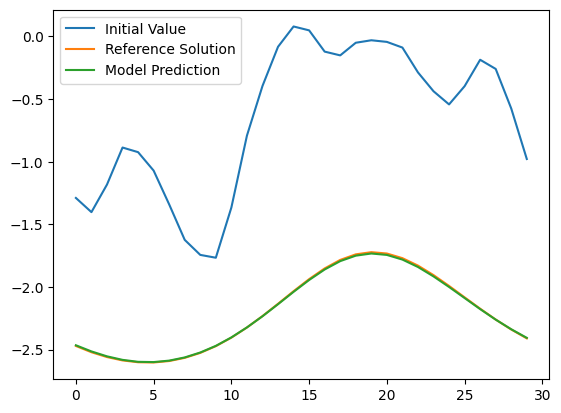

--------------------------------------RUN 4 --------------------------------------


2023-01-26 00:47:03.434660: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-26 00:47:03.810113: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-26 00:47:04.183092: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'

2023-01-26 00:47:04.556412: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion'



0  :  4.493
10  :  1.273
20  :  0.2455
30  :  0.1369
40  :  0.03451
50  :  0.01067
60  :  0.006729
70  :  0.004893
80  :  0.003123
90  :  0.002368
100  :  0.002777
110  :  0.001309
120  :  0.001306
130  :  0.001076
140  :  0.0009547
150  :  0.0009251
160  :  0.000781
170  :  0.000776
180  :  0.0007287
190  :  0.0008162
200  :  0.0008195
210  :  0.0007835
220  :  0.0005133
230  :  0.0006982
240  :  0.0005367
250  :  0.0005012
260  :  0.0004549
270  :  0.000408
280  :  0.0004969
290  :  0.0004252
300  :  0.0003703
310  :  0.0004528
320  :  0.0003811
330  :  0.001541
340  :  0.0004414
350  :  0.0003758
360  :  0.0003784
370  :  0.0003816
380  :  0.0003875
390  :  0.000311
400  :  0.0002856
410  :  0.0002619
420  :  0.0002374
430  :  0.0003529
440  :  0.0002888
450  :  0.0002264
460  :  0.0001916
470  :  0.0002086
480  :  0.0002059
490  :  0.0002164
500  :  0.0002981
510  :  0.0002031
520  :  0.0001621
530  :  0.0001877
540  :  0.0001841
550  :  0.0008735
560  :  0.0001937
570  :  0.000217

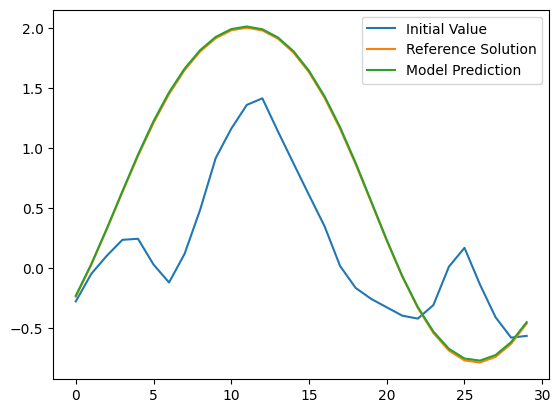

In [12]:
fno_errors = []
train_times = []
fno_models = []

#Store the results
fno_foldername = "Results_FNO"
if not os.path.exists(fno_foldername):
    os.makedirs(fno_foldername)


#Run the experiment
start_time = time.perf_counter() 
with open(fno_foldername + '/FNO_simulation_results.txt', 'w+') as f:

    for current_run_nr in range(fno_nr_of_runs):
        
        print("--------------------------------------RUN", current_run_nr, "--------------------------------------")
        print("--------------------------------------RUN", str(current_run_nr) + "--------------------------------------", file = f)

        fno_model = FNO_Model([nr_fourier_modes, width, depth], training_samples_generator)

        train_time = whole_training(fno_model, fno_initial_lr, fno_initial_batchsize, tolerance = fno_tolerance, max_trainsteps = fno_max_trainsteps, evaluate_steps = eval_steps, evaluate_samples = eval_samples)
        error = evaluate(fno_model, end_eval_samples)

        fno_errors = fno_errors + [error]
        train_times = train_times + [train_time]
        fno_models = fno_models + [fno_model]
        
        summary(fno_model, write_file=f, plot_file_name = fno_foldername + "/FNO_plot_" + str(current_run_nr))
        print("\n\n", file = f)
    
    best_fno_index = fno_errors.index(min(fno_errors))
    best_fno_model = fno_models[best_fno_index]
    csv_summary(best_fno_model, fno_foldername + "/FNO_best_error")

    total_time = time.perf_counter() - start_time 
    


    print("\n\n\n--------------------------------------\nTrain times:", file = f)
    print("    Best error: ", fno_errors[best_fno_index], "(" + str(best_fno_index) + ")", file = f)
    print("    Total time : ", total_time, file = f)
    print("    Total train time: ", sum(train_times), file = f)


with open(fno_foldername + "/Y_fno_errors.txt", 'w+') as f:
    print(fno_errors, file = f)

### Final plot

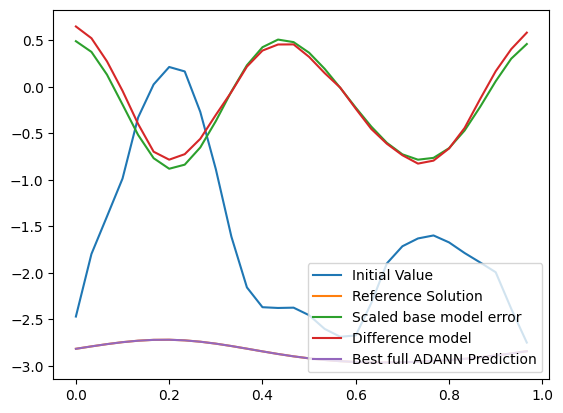

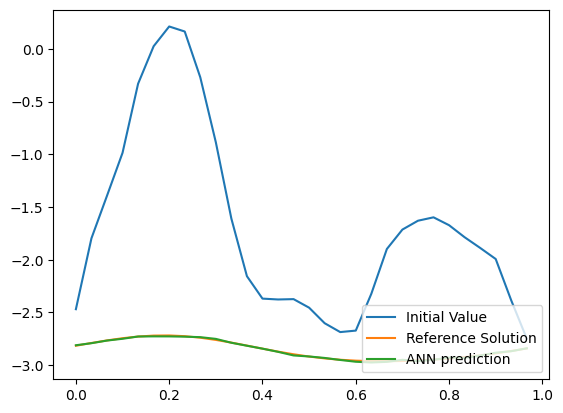

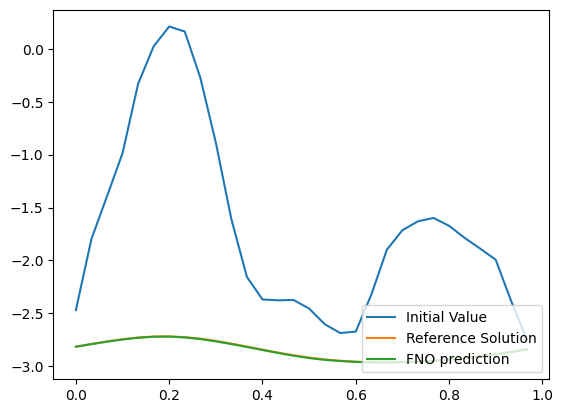

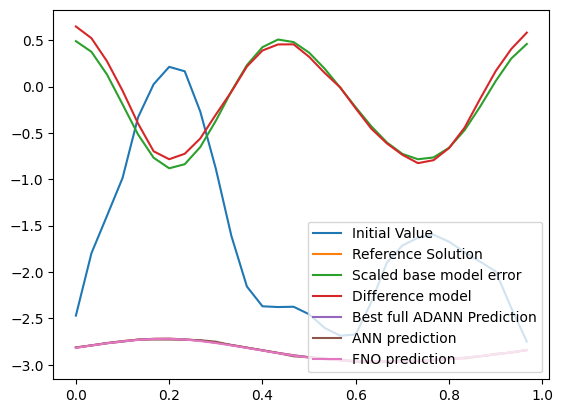

In [13]:
#Store the results
plots_foldername = "Results_plots"
if not os.path.exists(plots_foldername):
    os.makedirs(plots_foldername)

x_values = pde.x_values(nr_spacediscr)

initial_values, reference_solutions, finer_initial_values = training_samples_generator.generate(1, finer_resolution = True)

best_adann_predictions = best_full_adann_model(initial_values)
scaled_base_model_errors = best_full_adann_model.difference_models[0].training_samples_generator.get_label(initial_values, finer_initial_values)
difference_predictions = best_full_adann_model.difference_models[0](initial_values)

ann_predictions = best_ann_model(initial_values)
fno_prediction = best_fno_model(initial_values)


plt.figure()
plt.plot(x_values, initial_values[0], label = "Initial Value")
plt.plot(x_values, reference_solutions[0], label = "Reference Solution")

plt.plot(x_values, scaled_base_model_errors[0], label = "Scaled base model error")
plt.plot(x_values, difference_predictions[0], label = "Difference model")
plt.plot(x_values, best_adann_predictions[0], label = "Best full ADANN Prediction")

plt.legend(loc = "lower right")
# plt.title("Error plot", fontsize=10)
plt.savefig(plots_foldername + "/Results_approx_error_plot_ADANN.pdf", bbox_inches='tight')
plt.show()

plt.figure()
plt.plot(x_values, initial_values[0], label = "Initial Value")
plt.plot(x_values, reference_solutions[0], label = "Reference Solution")

plt.plot(x_values, ann_predictions[0], label = "ANN prediction")

plt.legend(loc = "lower right")
# plt.title("Error plot", fontsize=10)
plt.savefig(plots_foldername + "/Results_approx_error_plot_ANN.pdf", bbox_inches='tight')
plt.show()

plt.figure()
plt.plot(x_values, initial_values[0], label = "Initial Value")
plt.plot(x_values, reference_solutions[0], label = "Reference Solution")

plt.plot(x_values, fno_prediction[0], label = "FNO prediction")

plt.legend(loc = "lower right")
# plt.title("Error plot", fontsize=10)
plt.savefig(plots_foldername + "/Results_approx_error_plot_FNO.pdf", bbox_inches='tight')
plt.show()

plt.figure()
plt.plot(x_values, initial_values[0], label = "Initial Value")
plt.plot(x_values, reference_solutions[0], label = "Reference Solution")

plt.plot(x_values, scaled_base_model_errors[0], label = "Scaled base model error")
plt.plot(x_values, difference_predictions[0], label = "Difference model")
plt.plot(x_values, best_adann_predictions[0], label = "Best full ADANN Prediction")

plt.plot(x_values, ann_predictions[0], label = "ANN prediction")
plt.plot(x_values, fno_prediction[0], label = "FNO prediction")

plt.legend(loc = "lower right")
# plt.title("Error plot", fontsize=10)
plt.savefig(plots_foldername + "/Results_approx_error_plot_together.pdf", bbox_inches='tight')
plt.show()




### Testing zone